                                    ** Test Technique **


# Sommaire

1. [Présentation de la problématique et importation des données.](#data-présentation)

2. [Nettoyage des données.](#data-cleaning)
    
   - [Formatage 'isMale','yTotalHouseholdSpendings', 'yTotalHouseholdSpendingsUSD', 'nYearsEducation', 'LaborStatus'.](#data-format)
   - [La signification de la variable 'GDP_variation'.](#data-gdp)
   - [Traitement des données manquantes.](#data-manq)
   - [Traitement des doublons.](#data-doub)
   - [Codage de la variable catégorielle LaborStatus.](#data-codage)
   - [Traitement des outliers.](#data-out)
    
3. [Analyse des données.](#data-analysis)
    
    - Analyse univariée des variables.
    - [Analyse bivariée des variables.](#data-biv)
    - Etude de corrélation entre variables.
    - [Création d'une nouvelle variable isUnmarriedMale.](#data-cr)
    
4. [Préparation des données pour la modélisation.](#data-préparation)
    
    - [Définir la variable cible et les prédicteurs.](#data-pred)
    - [Normalisation des données.](#data-stand)
    - [Log transform la variable cible.](#data-log)
    - [Division des données en ensemble d'entraînement et ensemble de test.](#data-test)
    
5. [Modélisation et évaluation de modèles.](#data-modélisation)
    
    - [Optimisation des hyperparamètres.](#data-optim)
    - Calcul des métriques.
    - [Analyse de l'importance des variables.](#data-varia)
    
6. [Conclusions et prochaines étapes.](#data-conclusions)


<a id='data-présentation'></a>

# Présentation de la problématique et importation des données

### Consignes

L’objectif est de développer un modèle performant pour prédire la variable yTotalHouseholdSpendings en fonction des autres variables pertinentes. La plupart des variables ont un nom décrivant l’information contenue.

Il faut développer dans un Jupyter Notebook en Python un code contenant les différentes étapes que tu suivrais si tu étais face à ce dataset dans la vraie vie pour aboutir à un modèle performant. Merci d’écrire tes commentaires / réflexions / conclusions dans du texte dans le notebook. Les visuels sont utiles.


  

In [165]:
# Chargement des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
from sklearn.model_selection import train_test_split,cross_val_score, KFold, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, plot_importance
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
pd.set_option('display.max_columns', None)
%matplotlib inline

In [17]:
#Chargement des données
data = pd.read_csv('spendings_dataset.csv', sep=';')

In [18]:
data.head()

GDP_variation  weight   age  householdSize isMale  isMarried  isLiterate   
0       0.093446     187  34.0              4    1,0        1.0         1.0  \
1       0.093446      95  39.0              8    1,0        1.0         1.0   
2       0.093446     225  53.0             10    1,0        1.0         1.0   
3       0.093446     148  54.0              1    1,0        0.0         1.0   
4       0.093446     221  69.0              5    1,0        1.0         1.0   

  nYearsEducation  isUrban laborStatus  hasAccount  hasLoan  isHouseOwner   
0             4.0        1    employed         0.0      1.0           1.0  \
1             0.0        1    employed         0.0      0.0           1.0   
2             4.0        1    employed         0.0      0.0           1.0   
3             5.0        1    inactive         0.0      0.0           1.0   
4             0.0        0    employed         0.0      1.0           1.0   

  yTotalHouseholdSpendings yTotalHouseholdSpendingsUSD      id  
0                    518.4           48.44235229492184  408112  
1                  12000.0               1121.35078125   99522  
2                  80160.0                7490.6234375  450411  
3                  13584.0          1269.3690429687522  230464  
4                   3200.0           299.0268798828128  187256

## Affichage des informations générales sur le DataFrame

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GDP_variation                4024 non-null   float64
 1   weight                       4024 non-null   int64  
 2   age                          4024 non-null   float64
 3   householdSize                4024 non-null   int64  
 4   isMale                       4024 non-null   object 
 5   isMarried                    4024 non-null   float64
 6   isLiterate                   4000 non-null   float64
 7   nYearsEducation              4000 non-null   object 
 8   isUrban                      4024 non-null   int64  
 9   laborStatus                  3991 non-null   object 
 10  hasAccount                   4024 non-null   float64
 11  hasLoan                      4015 non-null   float64
 12  isHouseOwner                 4024 non-null   float64
 13  yTotalHouseholdSpe

In [20]:
print(f"Nombre de lignes: {data.shape[0]}, Nombre de colonnes: {data.shape[1]}")


Nombre de lignes: 4024, Nombre de colonnes: 16


In [21]:
df=data.copy()
df.columns

Index(['GDP_variation', 'weight', 'age', 'householdSize', 'isMale',
       'isMarried', 'isLiterate', 'nYearsEducation', 'isUrban', 'laborStatus',
       'hasAccount', 'hasLoan', 'isHouseOwner', 'yTotalHouseholdSpendings',
       'yTotalHouseholdSpendingsUSD', 'id'],
      dtype='object')

In [22]:
# Affichage du nombre de valeurs uniques pour chaque variable
print(df.nunique())

GDP_variation                     1
weight                          231
age                              85
householdSize                    21
isMale                            2
isMarried                         2
isLiterate                        2
nYearsEducation                  19
isUrban                           2
laborStatus                       5
hasAccount                        2
hasLoan                           2
isHouseOwner                      2
yTotalHouseholdSpendings       2577
yTotalHouseholdSpendingsUSD    2574
id                             4012
dtype: int64


# Contenu de la base de données

**GDP_variation**: Cela semble être la variation du PIB (produit intérieur brut) sur une période de temps donnée.

**weight**: Un poids statistique utilisé pour ajuster l'échantillonnage dans la recherche socio-économique. Cette pondération permet de représenter la population générale, en tenant compte d'éventuelles irrégularités dans les données.

**age**: L'âge du répondant ou du chef de ménage en années, ou peut-être l'âge moyen des membres du ménage.

**householdSize**: Le nombre de personnes dans le ménage. Autrement dit, toutes les personnes vivant dans le ménage (pas seulement les membres de la famille).

**isMale**: Sexe du répondant. Une valeur de 1 signifie un homme, 0 signifie une femme (type booléen).

**isMarried**: État civil du répondant. Une valeur de 1 signifie que le répondant est marié, 0 signifie qu'il n'est pas marié (type booléen).

**isLiterate**: Alphabétisation du répondant. Une valeur de 1 signifie que le répondant est alphabétisé, 0 signifie qu'il est analphabète (type booléen).

**nYearsEducation** n: Nombre d'années d'éducation formelle reçues par le répondant.

**isUrban**: Lieu de résidence du répondant. Une valeur de 1 signifie que le répondant vit dans une ville, 0 - dans une zone rurale (type booléen).

**laborStatus**:Situation d'emploi du répondant. Il s'agit d'une variable catégorielle où chaque valeur correspond à un statut d'emploi spécifique.

**hasAccount**: Le ménage a-t-il un compte bancaire. La valeur 1 signifie la présence d'un compte, 0 signifie l'absence(type booléen).

**hasLoan**: Le ménage a-t-il un prêt. La valeur 1 signifie la présence d'un compte, 0 signifie l'absence (type booléen).

**isHouseOwner**: Le ménage possède-t-il une propriété résidentielle. La valeur 1 signifie la présence d'un compte, 0 signifie l'absence (type booléen).

**yTotalHouseholdSpendings**: Les dépenses totales du ménage (peut-être en monnaie locale).

**yTotalHouseholdSpendingsUSD**: Les dépenses totales du ménage en dollars américains.
                                                     
**id**: Identifiant unique du répondant ou du ménage.
                                                    

## Voici quelques observations sur les paramètres :

**id** : C'est un identifiant unique du client/du ménage. Cette colonne ne sera probablement pas utile pour la modélisation car elle ne contient aucune information qui pourrait être utile pour prédire les dépenses du ménage.

**GDP_variation** : Ce paramètre peut être important car la variation du PIB peut influencer le niveau de dépenses du ménage.

**weight, age, householdSize** : Ces variables peuvent être des facteurs importants influençant les dépenses du ménage. Le poids-utilisé pour pondérer les résultats d’une étude afin de mieux refléter la population générale. L'âge peuvent refléter les caractéristiques et les besoins des individus dans le ménage, tandis que la taille du ménage peut refléter la taille globale et les besoins du ménage.

**isMale, isMarried, isLiterate, nYearsEducation, laborStatus, hasAccount, hasLoan, isHouseOwner** : Ces paramètres peuvent également influencer les dépenses du ménage en raison de leur lien avec le statut socio-économique et la situation des membres de la famille.

**isUrban** : On sait que la vie en milieu urbain peut entraîner des dépenses différentes par rapport aux zones rurales, donc cette variable peut également être importante pour prédire les dépenses.

**yTotalHouseholdSpendings, yTotalHouseholdSpendingsUSD** : Ces paramètres sont notre variable cible, c'est-à-dire les dépenses du ménage, et ils sont essentiels pour la modélisation.

<a id='data-cleaning'></a>

#  Nettoyage des données

In [23]:
# Déplacer la colonne "id" au début
first_column = df.pop('id') 
df.insert(0, 'ID', first_column)  


In [24]:
# Renommer certaines variables pour rendre leurs noms plus clairs
df = df.rename(columns={'laborStatus': 'LaborStatus', 
                             'weight': 'Weight', 
                             'age': 'Age', 
                             'householdSize': 'HouseholdSize'})


In [25]:
df.describe(include='all')

ID  GDP_variation       Weight          Age  HouseholdSize   
count     4024.000000   4.024000e+03  4024.000000  4024.000000    4024.000000  \
unique            NaN            NaN          NaN          NaN            NaN   
top               NaN            NaN          NaN          NaN            NaN   
freq              NaN            NaN          NaN          NaN            NaN   
mean    500792.953529   9.344590e-02   220.400099    45.581262       5.489811   
std     288684.661346   2.775903e-17   179.829930    16.030370       2.785281   
min        106.000000   9.344590e-02  -213.000000    -2.000000       1.000000   
25%     253752.250000   9.344590e-02   137.000000    33.000000       4.000000   
50%     492770.000000   9.344590e-02   176.000000    43.000000       5.000000   
75%     756278.750000   9.344590e-02   233.500000    56.000000       7.000000   
max     999934.000000   9.344590e-02  2150.000000   220.000000      22.000000   

       isMale    isMarried   isLiterate nYearsEducation      isUrban   
count    4024  4024.000000  4000.000000            4000  4024.000000  \
unique      2          NaN          NaN              19          NaN   
top       1,0          NaN          NaN             0.0          NaN   
freq     2961          NaN          NaN            1367          NaN   
mean      NaN     0.713469     0.684250             NaN     0.539761   
std       NaN     0.452197     0.464872             NaN     0.498478   
min       NaN     0.000000     0.000000             NaN     0.000000   
25%       NaN     0.000000     0.000000             NaN     0.000000   
50%       NaN     1.000000     1.000000             NaN     1.000000   
75%       NaN     1.000000     1.000000             NaN     1.000000   
max       NaN     1.000000     1.000000             NaN     1.000000   

       LaborStatus   hasAccount      hasLoan  isHouseOwner   
count         3991  4024.000000  4015.000000   4024.000000  \
unique           5          NaN          NaN           NaN   
top       employed          NaN          NaN           NaN   
freq          3156          NaN          NaN           NaN   
mean           NaN     0.047714     0.156164      0.782555   
std            NaN     0.213186     0.363056      0.412559   
min            NaN     0.000000     0.000000      0.000000   
25%            NaN     0.000000     0.000000      1.000000   
50%            NaN     0.000000     0.000000      1.000000   
75%            NaN     0.000000     0.000000      1.000000   
max            NaN     1.000000     1.000000      1.000000   

       yTotalHouseholdSpendings yTotalHouseholdSpendingsUSD  
count                      4021                        4021  
unique                     2577                        2574  
top                         0.0                         0.0  
freq                         72                          72  
mean                        NaN                         NaN  
std                         NaN                         NaN  
min                         NaN                         NaN  
25%                         NaN                         NaN  
50%                         NaN                         NaN  
75%                         NaN                         NaN  
max                         NaN                         NaN

<a id='data-format'></a>
## Analyse du format  

In [ ]:
### Reformatting 'isMale'

In [26]:
df['isMale'].unique()

array(['1,0', '0,0'], dtype=object)

In [27]:
df['isMale'] = df['isMale'].map({'1,0': 1, '0,0': 0})

In [28]:
df['isMale'].value_counts()

isMale
1    2961
0    1063
Name: count, dtype: int64

In [29]:
df['isMale'].unique()

array([1, 0])

###  Formatage 'yTotalHouseholdSpendings', 'yTotalHouseholdSpendingsUSD'

In [30]:
df[['yTotalHouseholdSpendingsUSD', 'yTotalHouseholdSpendingsUSD']]

yTotalHouseholdSpendingsUSD yTotalHouseholdSpendingsUSD
0              48.44235229492184           48.44235229492184
1                  1121.35078125               1121.35078125
2                   7490.6234375                7490.6234375
3             1269.3690429687522          1269.3690429687522
4              299.0268798828128           299.0268798828128
...                          ...                         ...
4019           554.3958007812504           554.3958007812504
4020          326.53735351562483          326.53735351562483
4021           2067.770898437504           2067.770898437504
4022           400.6959960937504           400.6959960937504
4023          1345.6208984375044          1345.6208984375044

[4024 rows x 2 columns]

In [31]:
def select_rows_with_missing_values(df, columns):
    """
    Sélectionnez les lignes avec des valeurs manquantes dans les colonnes spécifiées et renvoyez un DataFrame contenant uniquement les colonnes sélectionnées.
    Paramètres :
    df: DataFrame à partir duquel sélectionner les lignes
    columns: Liste des noms de colonnes à vérifier pour les valeurs manquantes
    Returns:
    selected_rows_df : DataFrame contenant les lignes avec des valeurs manquantes dans les colonnes spécifiées
    """

    selected_rows_df = df[df[columns].isna().any(axis=1)]
    selected_rows_df = selected_rows_df[columns]

    return selected_rows_df

In [32]:
df1=df.copy()

In [33]:
# Convertir une colonne 'yTotalHouseholdSpendings', 'yTotalHouseholdSpendingsUSD' au format numérique
df1['yTotalHouseholdSpendings'] = pd.to_numeric(df1['yTotalHouseholdSpendings'], errors='coerce')

df1['yTotalHouseholdSpendingsUSD'] = pd.to_numeric(df1['yTotalHouseholdSpendingsUSD'], errors='coerce')


Dans ce code, **error='coerce'** signifie que s'il n'y a aucun moyen de convertir les valeurs au format numérique, elles seront remplacées par **NaN**. Cela évite les erreurs lors de la conversion et garantit que les données incorrectes sont traitées correctement.

In [34]:
select_rows_with_missing_values(df1, ['yTotalHouseholdSpendingsUSD', 'yTotalHouseholdSpendingsUSD'])

yTotalHouseholdSpendingsUSD  yTotalHouseholdSpendingsUSD
1040                          NaN                          NaN
1723                          NaN                          NaN
1917                          NaN                          NaN
3133                          NaN                          NaN
3611                          NaN                          NaN
3684                          NaN                          NaN

In [ ]:
# Certaines valeurs provoquent une erreur lors de la conversion et ont donc été remplacées par NaN.

In [35]:
# Sélection de lignes et de colonnes spécifiques par leurs indices numériques
selected_rows = data.iloc[[1917, 3611, 3684], [13, 14]]  # 13 та 14 - les index de colonnes 'yTotalHouseholdSpendings' та 'yTotalHouseholdSpendingsUSD'
selected_rows

yTotalHouseholdSpendings yTotalHouseholdSpendingsUSD
1917              noSpendings                 noSpendings
3611              noSpendings                 noSpendings
3684              noSpendings                 noSpendings

Si ces valeurs n'indiquent aucun coût, il est utile de les remplacer par 0 avant de les convertir au format numérique.

In [36]:
df.iloc[[1917, 3611, 3684], ]

ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
1917  953216       0.093446      46  31.0              7       1        0.0  \
3611  549187       0.093446     221  37.0              7       1        1.0   
3684  437871       0.093446     232  36.0              3       0        0.0   

      isLiterate nYearsEducation  isUrban LaborStatus  hasAccount  hasLoan   
1917         1.0            11.0        1  unemployed         0.0      0.0  \
3611         NaN             NaN        1         NaN         0.0      0.0   
3684         0.0             0.0        0    inactive         0.0      0.0   

      isHouseOwner yTotalHouseholdSpendings yTotalHouseholdSpendingsUSD  
1917           1.0              noSpendings                 noSpendings  
3611           1.0              noSpendings                 noSpendings  
3684           0.0              noSpendings                 noSpendings

In [37]:
# Remplacement des valeurs "noSendings" par 0
df['yTotalHouseholdSpendings'] = df['yTotalHouseholdSpendings'].replace('noSpendings', 0)
df['yTotalHouseholdSpendingsUSD'] = df['yTotalHouseholdSpendingsUSD'].replace('noSpendings', 0)

# Convertir les colonnes au format numérique
df['yTotalHouseholdSpendings'] = pd.to_numeric(df['yTotalHouseholdSpendings'])
df['yTotalHouseholdSpendingsUSD'] = pd.to_numeric(df['yTotalHouseholdSpendingsUSD'])


In [38]:
select_rows_with_missing_values(df, ['yTotalHouseholdSpendingsUSD', 'yTotalHouseholdSpendingsUSD'])

yTotalHouseholdSpendingsUSD  yTotalHouseholdSpendingsUSD
1040                          NaN                          NaN
1723                          NaN                          NaN
3133                          NaN                          NaN

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           4024 non-null   int64  
 1   GDP_variation                4024 non-null   float64
 2   Weight                       4024 non-null   int64  
 3   Age                          4024 non-null   float64
 4   HouseholdSize                4024 non-null   int64  
 5   isMale                       4024 non-null   int64  
 6   isMarried                    4024 non-null   float64
 7   isLiterate                   4000 non-null   float64
 8   nYearsEducation              4000 non-null   object 
 9   isUrban                      4024 non-null   int64  
 10  LaborStatus                  3991 non-null   object 
 11  hasAccount                   4024 non-null   float64
 12  hasLoan                      4015 non-null   float64
 13  isHouseOwner      

## Reformatting 'nYearsEducation'

In [40]:
df['nYearsEducation'].unique()

array(['4.0', '0.0', '5.0', '1.0', '6.0', '11.0', '3.0', '8.0', '9.0',
       '7.0', nan, '2.0', 'noEducation', '16.0', '10.0', '17.0', '12.0',
       '14.0', '13.0', '15.0'], dtype=object)

In [41]:
df['nYearsEducation'].value_counts()

nYearsEducation
0.0            1367
6.0             474
3.0             404
4.0             306
2.0             267
11.0            190
5.0             188
9.0             164
7.0             142
8.0             126
16.0             89
1.0              77
12.0             62
10.0             58
15.0             36
14.0             19
17.0             17
13.0             12
noEducation       2
Name: count, dtype: int64

In [42]:
# Remplacement des valeurs 'noEducation' на 0
df['nYearsEducation'] = df['nYearsEducation'].replace('noEducation', 0)

In [43]:
# Conversion de la colonne 'nYearsEducation' en type numérique
df['nYearsEducation'] = pd.to_numeric(df['nYearsEducation'], errors='coerce')

In [44]:
df['nYearsEducation'].isna().sum()

24

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           4024 non-null   int64  
 1   GDP_variation                4024 non-null   float64
 2   Weight                       4024 non-null   int64  
 3   Age                          4024 non-null   float64
 4   HouseholdSize                4024 non-null   int64  
 5   isMale                       4024 non-null   int64  
 6   isMarried                    4024 non-null   float64
 7   isLiterate                   4000 non-null   float64
 8   nYearsEducation              4000 non-null   float64
 9   isUrban                      4024 non-null   int64  
 10  LaborStatus                  3991 non-null   object 
 11  hasAccount                   4024 non-null   float64
 12  hasLoan                      4015 non-null   float64
 13  isHouseOwner      

## 'GDP_variation' <a id='data-gdp'></a>

La « GDP_variation » indique l'évolution du produit intérieur brut (PIB) au cours d'une certaine période de temps. Il peut s'agir d'une variation positive ou négative, reflétant la croissance ou le déclin de l'activité économique du pays au cours de la période donnée.

In [340]:
df['GDP_variation'].value_counts()

GDP_variation
0.093446    4024
Name: count, dtype: int64

""""
GDP_variation: 0.093446 (9.3446%)
Cela signifie que le PIB a augmenté de 9,3446% par rapport à la période précédente.
Il s'agit d'un indicateur positif qui indique la croissance de l'économie.

Ces connaissances peuvent être utiles pour prévoir les dépenses totales des ménages, 
car la croissance économique affecte souvent les dépenses de consommation.
Par exemple, un taux de croissance plus élevé du PIB peut indiquer une augmentation du revenu des ménages et, 
par conséquent, une augmentation des dépenses.

 Des variables supplémentaires peuvent être créées sur la base de ces informations, telles que :

(1+GDP_variation) * HouseholdSize : Pour estimer l'impact de la croissance économique sur les dépenses des ménages ajustées en fonction de la taille du ménage.

Interaction entre GDP_variation et d'autres variables pertinentes pour révéler des dépendances plus complexes.
Ces nouvelles variables peuvent améliorer la précision du modèle car elles tiennent compte de l’impact des facteurs macroéconomiques sur les dépenses individuelles.

Pour évaluer l'impact de nouvelles variables, on peux créer un modèle avec et sans ces variables et comparer les résultats.

""""

## Formatage 'LaborStatus' <a id='data-codage'></a>

In [47]:
df['LaborStatus'].unique()

array(['employed', 'inactive', 'unemployed', 'EMPLOYED', nan,
       'un_employed'], dtype=object)

In [48]:
df['LaborStatus'].value_counts()

LaborStatus
employed       3156
inactive        641
unemployed      186
EMPLOYED          5
un_employed       3
Name: count, dtype: int64

In [49]:
# Remplacement et fusion des valeurs dans la colonne 'laborStatus'
df['LaborStatus'] = df['LaborStatus'].replace({'employed': 'EMPLOYED', 'unemployed': 'UNEMPLOYED', 'un_employed':'UNEMPLOYED', 'inactive': 'INACTIVE'})

df['LaborStatus'].value_counts()


LaborStatus
EMPLOYED      3161
INACTIVE       641
UNEMPLOYED     189
Name: count, dtype: int64

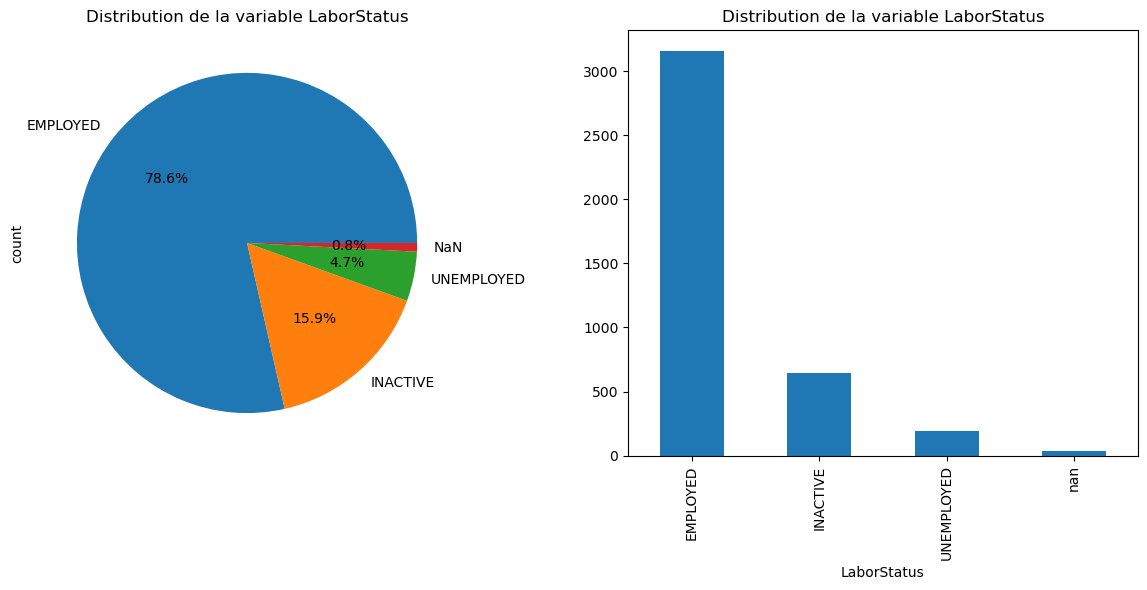

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

labels = ['EMPLOYED','INACTIVE','UNEMPLOYED','NaN']

df['LaborStatus'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', labels=labels, ax=axs[0])
axs[0].set_title('Distribution de la variable LaborStatus')

df['LaborStatus'].value_counts(dropna=False).plot(kind='bar', ax=axs[1])
axs[1].set_title('Distribution de la variable LaborStatus')

plt.tight_layout()
plt.show()

## Analyse des données manquantes <a id='data-manq'></a>

In [52]:
# Tableau des valeurs manquantes par colonne
missing_values = df.isna().sum().sort_values(ascending=False)
missing_percent = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
missing_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print(missing_table)

                             Missing Values  Percentage
LaborStatus                              33    0.820080
isLiterate                               24    0.596421
nYearsEducation                          24    0.596421
hasLoan                                   9    0.223658
yTotalHouseholdSpendings                  3    0.074553
yTotalHouseholdSpendingsUSD               3    0.074553
ID                                        0    0.000000
GDP_variation                             0    0.000000
Weight                                    0    0.000000
Age                                       0    0.000000
HouseholdSize                             0    0.000000
isMale                                    0    0.000000
isMarried                                 0    0.000000
isUrban                                   0    0.000000
hasAccount                                0    0.000000
isHouseOwner                              0    0.000000


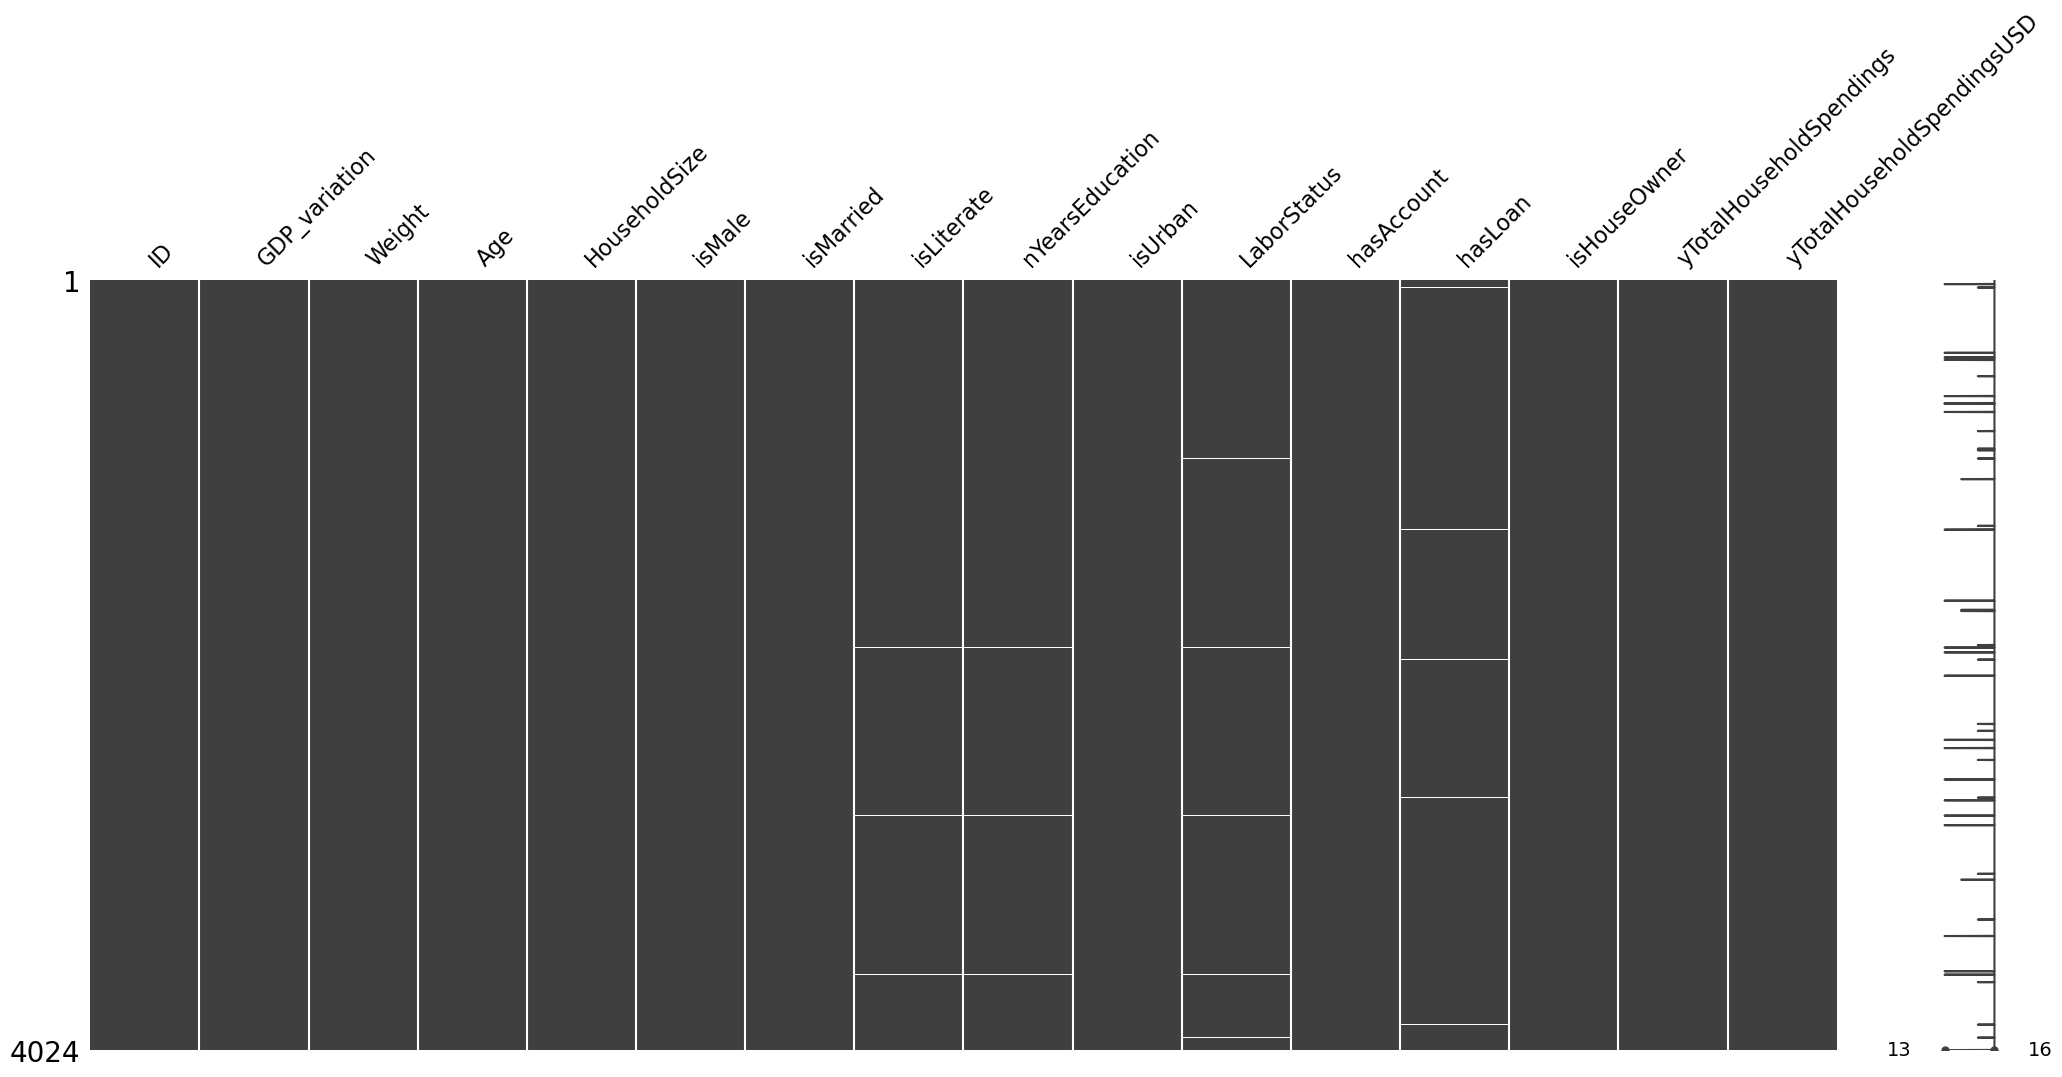

In [53]:
# Visualiser les valeurs manquantes avec missingno
msno.matrix(df)
plt.show();

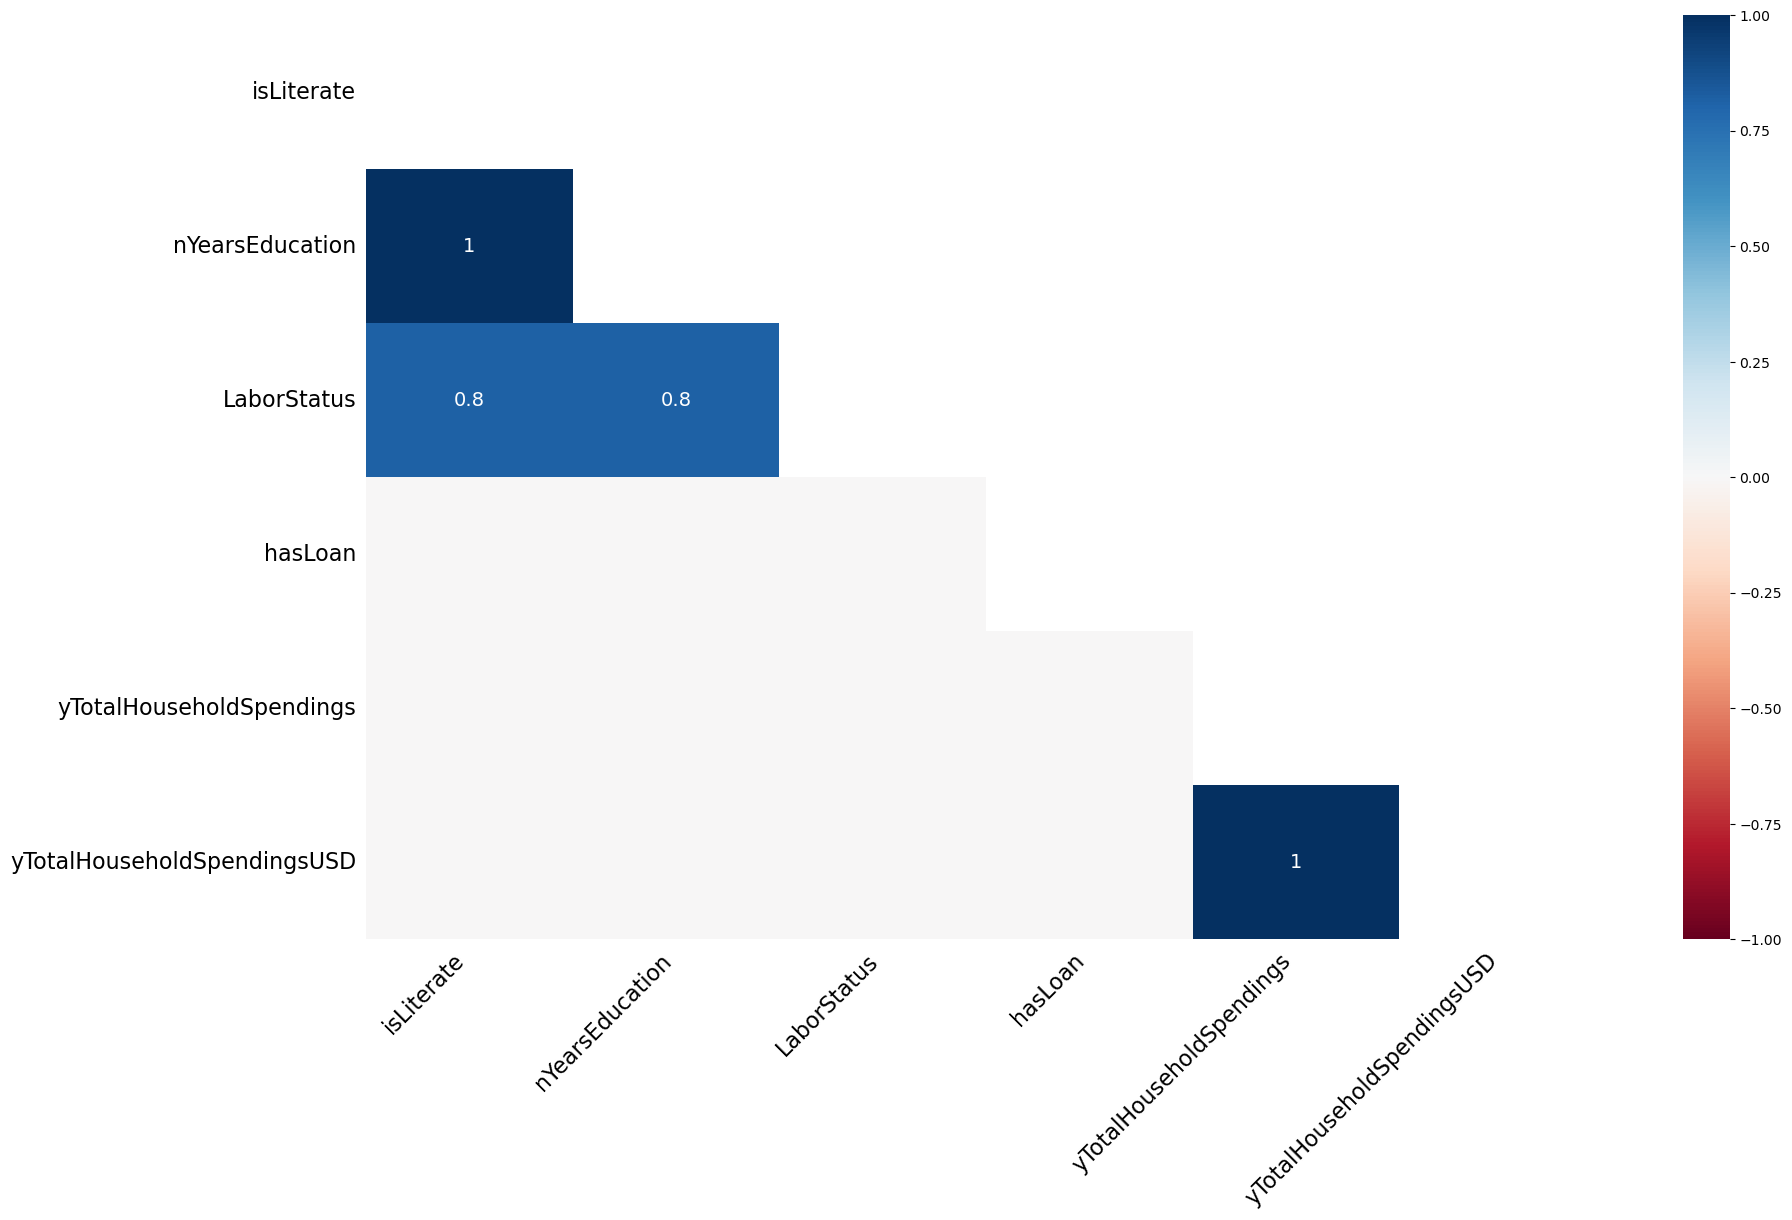

In [54]:
# Analyser la corrélation entre les valeurs manquantes
msno.heatmap(df)
plt.show();

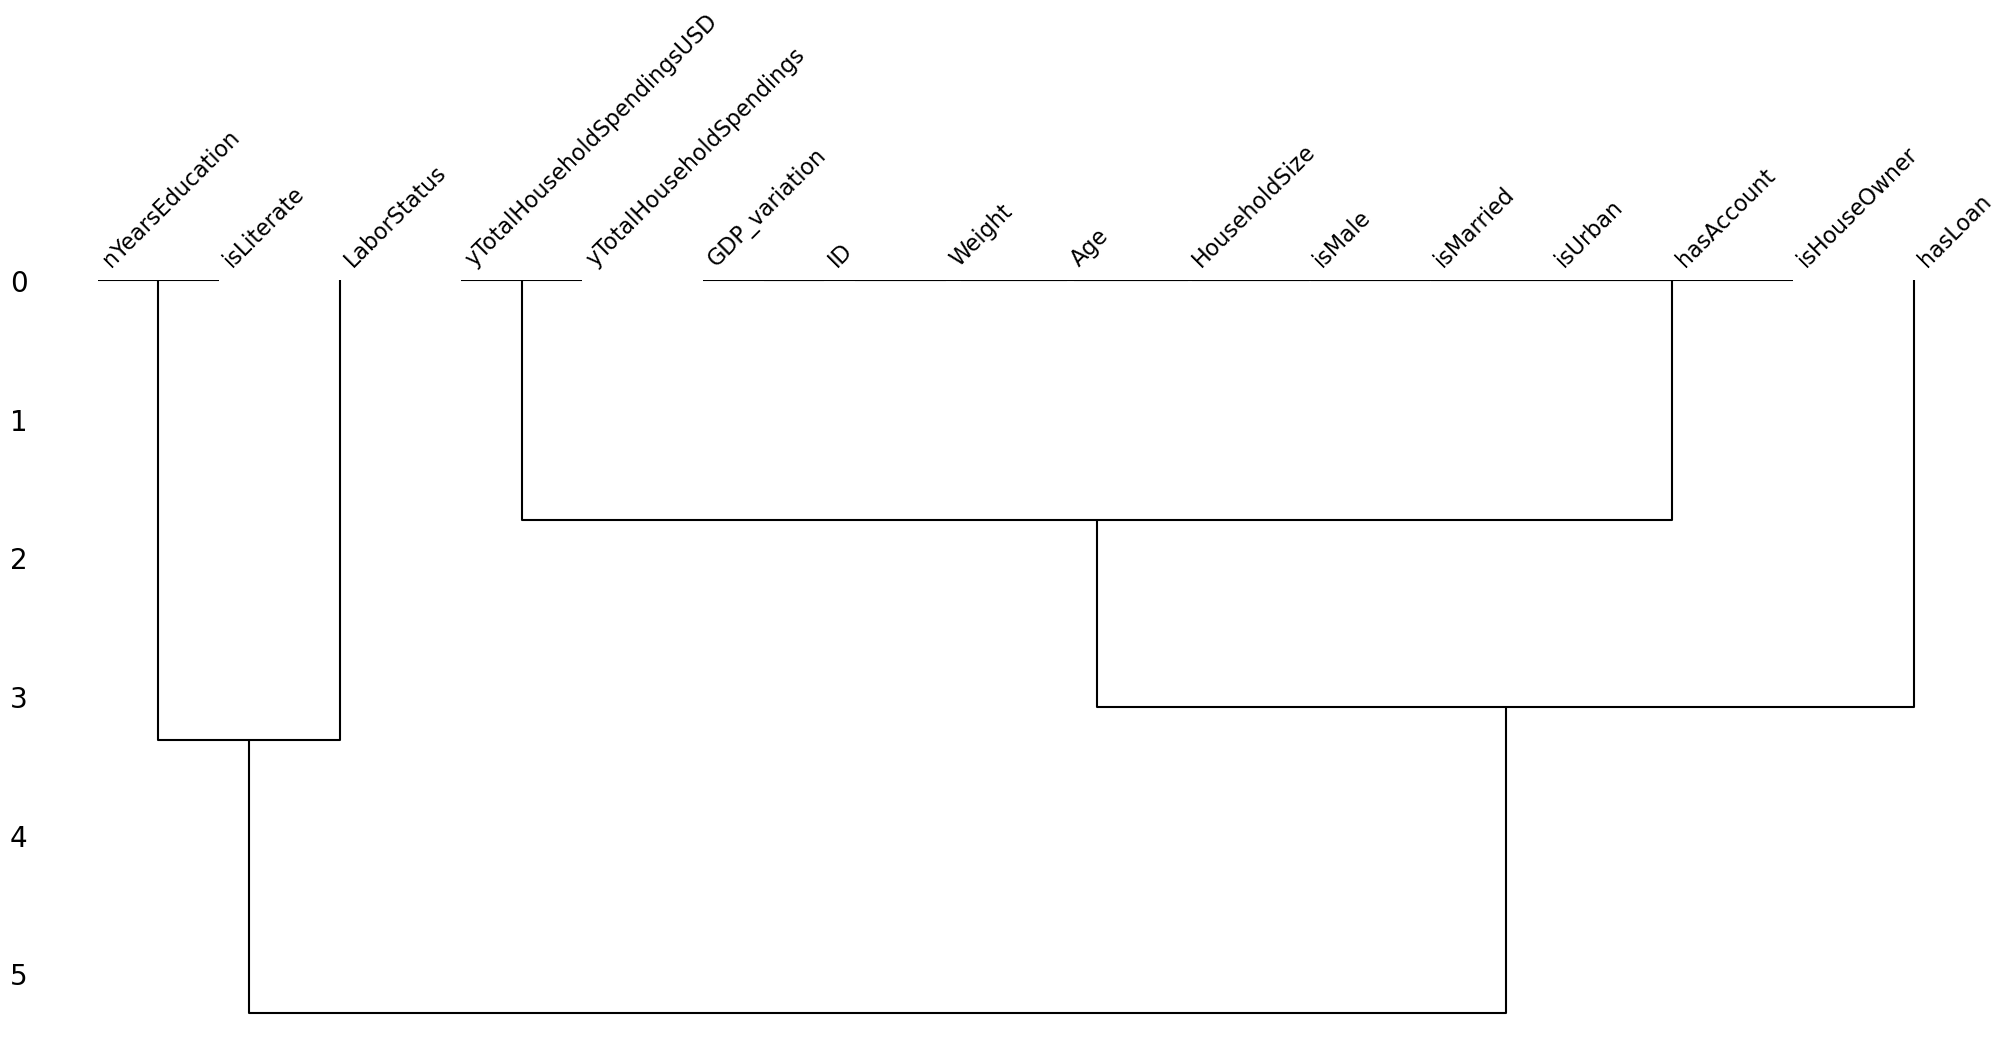

In [55]:
msno.dendrogram(df)
plt.show();

In [56]:
select_rows_with_missing_values(df, ['isLiterate', 'LaborStatus','nYearsEducation'])

isLiterate LaborStatus  nYearsEducation
21           NaN         NaN              NaN
380          NaN         NaN              NaN
404          NaN         NaN              NaN
417          NaN         NaN              NaN
502          0.0         NaN              0.0
606          NaN         NaN              NaN
643          NaN         NaN              NaN
646          NaN         NaN              NaN
689          NaN         NaN              NaN
881          1.0         NaN             11.0
889          1.0         NaN              6.0
932          1.0         NaN             12.0
1284         1.0         NaN              5.0
1304         NaN         NaN              NaN
1675         NaN         NaN              NaN
1729         NaN    EMPLOYED              NaN
1907         1.0         NaN              9.0
1920         NaN         NaN              NaN
1945         NaN         NaN              NaN
2067         NaN         NaN              NaN
2402         NaN         NaN              NaN
2445         NaN         NaN              NaN
2507         1.0         NaN              6.0
2609         NaN         NaN              NaN
2718         NaN         NaN              NaN
2798         NaN         NaN              NaN
2848         NaN         NaN              NaN
3102         1.0         NaN             11.0
3341         1.0         NaN              4.0
3427         NaN         NaN              NaN
3611         NaN         NaN              NaN
3629         NaN         NaN              NaN
3958         1.0         NaN             11.0
4023         NaN         NaN              NaN

In [57]:
# Imputation par KNN Imputer
# KNN imputer avec 3 voisins pour plusieurs colonnes

imputer = KNNImputer(n_neighbors=3)

df[['yTotalHouseholdSpendingsUSD', 'yTotalHouseholdSpendings','nYearsEducation']] = imputer.fit_transform(df[['yTotalHouseholdSpendingsUSD', 'yTotalHouseholdSpendings','nYearsEducation']])

df.isnull().sum()

ID                              0
GDP_variation                   0
Weight                          0
Age                             0
HouseholdSize                   0
isMale                          0
isMarried                       0
isLiterate                     24
nYearsEducation                 0
isUrban                         0
LaborStatus                    33
hasAccount                      0
hasLoan                         9
isHouseOwner                    0
yTotalHouseholdSpendings        0
yTotalHouseholdSpendingsUSD     0
dtype: int64

In [59]:
# Imputation par le mode
imputer_mode = SimpleImputer(strategy='most_frequent')
df['isLiterate'] = imputer_mode.fit_transform(df[['isLiterate']])
df['hasLoan'] = imputer_mode.fit_transform(df[['hasLoan']])

/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or Fals

In [62]:
#Conversion de variables booléennes en int:
df[['isLiterate', 'hasAccount', 'hasLoan', 'isHouseOwner','isMarried']] = df[['isLiterate', 'hasAccount', 'hasLoan', 'isHouseOwner','isMarried']].astype(int)

In [64]:
df.loc[:, 'LaborStatus']  = df['LaborStatus'].fillna('EMPLOYED')


In [66]:
df['LaborStatus'].value_counts()

LaborStatus
EMPLOYED      3194
INACTIVE       641
UNEMPLOYED     189
Name: count, dtype: int64

In [72]:
#Codage de la variable catégorielle LaborStatus
label_encoder = LabelEncoder()
df['LaborStatus'] = label_encoder.fit_transform(df['LaborStatus']).astype(int)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           4024 non-null   int64  
 1   GDP_variation                4024 non-null   float64
 2   Weight                       4024 non-null   int64  
 3   Age                          4024 non-null   float64
 4   HouseholdSize                4024 non-null   int64  
 5   isMale                       4024 non-null   int64  
 6   isMarried                    4024 non-null   int64  
 7   isLiterate                   4024 non-null   int64  
 8   nYearsEducation              4024 non-null   float64
 9   isUrban                      4024 non-null   int64  
 10  LaborStatus                  4024 non-null   int64  
 11  hasAccount                   4024 non-null   int64  
 12  hasLoan                      4024 non-null   int64  
 13  isHouseOwner      

# Traitement des doublons <a id='data-doub'></a>

In [74]:
df[df.duplicated(subset=['ID'], keep=False)].shape[0]

24

In [75]:
df[df.duplicated(subset=['ID'], keep=False)]

ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
208   423581       0.093446     155  62.0              1       0          0  \
231   985189       0.093446     256  57.0              5       1          1   
551    13305       0.093446     104  42.0              9       0          1   
645   633238       0.093446      67  70.0              3       1          0   
1093  985189       0.093446     113  70.0              6       1          1   
1132  219242       0.093446     348  63.0              6       1          1   
1274  866187       0.093446     239  30.0              6       1          1   
1314  786787       0.093446     135  40.0              4       0          0   
1427   35657       0.093446     241  38.0             12       1          0   
2127  633238       0.093446      67  70.0              3       0          0   
2166  786787       0.093446     135  40.0              4       0          0   
2375  298818       0.093446     194  48.0              6       1          1   
2441   35657       0.093446     241  38.0             12       0          0   
2479  219242       0.093446     348  63.0              6       0          1   
2591  798939       0.093446     201  28.0              6       1          1   
2613  866187       0.093446     239  30.0              6       0          1   
2820  298818       0.093446      81  33.0              9       1          1   
2822  995311       0.093446     248  38.0              8       1          1   
2927  995311       0.093446    1431  56.0              6       0          0   
3096  362644       0.093446     205  90.0              5       1          0   
3263  798939       0.093446     201  28.0              6       1          1   
3330  423581       0.093446     369  60.0              4       1          1   
3400   13305       0.093446     104  42.0              9       1          1   
4021  362644       0.093446     205  90.0              5       1          0   

      isLiterate  nYearsEducation  isUrban  LaborStatus  hasAccount  hasLoan   
208            1              0.0        0            1           0        0  \
231            0              0.0        0            0           0        0   
551            1              4.0        0            2           0        0   
645            0              0.0        0            1           0        0   
1093           0              0.0        0            0           0        1   
1132           0              0.0        1            1           0        0   
1274           1              6.0        1            0           0        0   
1314           1             11.0        1            0           0        0   
1427           0              0.0        0            1           0        0   
2127           0              0.0        0            1           0        0   
2166           1             11.0        1            0           0        0   
2375           1             12.0        1            0           1        1   
2441           0              0.0        0            1           0        0   
2479           0              0.0        1            1           0        0   
2591           1              0.0        0            0           0        0   
2613           1              6.0        1            0           0        0   
2820           1              0.0        0            0           0        0   
2822           1             14.0        1            0           0        0   
2927           0              0.0        1            0           0        1   
3096           0              0.0        1            0           0        0   
3263           1              0.0        0            0           0        0   
3330           0              0.0        0            1           0        0   
3400           1              4.0        0            2           0        0   
4021           0              0.0        1            0           0        0   

      isHouseOwner  yTotalHouseho

In [76]:
duplicates_grouped = df[df.duplicated(subset=['ID'], keep=False)].groupby('ID')
for group_id, group_data in duplicates_grouped:
    print(f"ID: {group_id}\n{group_data}\n")
    print('----------------------------------------------------------------------------------------')


ID: 13305
         ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
551   13305       0.093446     104  42.0              9       0          1  \
3400  13305       0.093446     104  42.0              9       1          1   

      isLiterate  nYearsEducation  isUrban  LaborStatus  hasAccount  hasLoan   
551            1              4.0        0            2           0        0  \
3400           1              4.0        0            2           0        0   

      isHouseOwner  yTotalHouseholdSpendings  yTotalHouseholdSpendingsUSD  
551              1                    7200.0                   672.810449  
3400             1                    7200.0                   672.810449  

----------------------------------------------------------------------------------------
ID: 35657
         ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
1427  35657       0.093446     241  38.0             12       1          0  \
2441  35657       0.093446    

In [77]:
duplicates_subset = df[df.duplicated(subset=['ID'], keep=False)]

for idx, row in duplicates_subset.iterrows():
    duplicate_rows = df[df['ID'] == row['ID']]
    for col in df.columns:
        if col != 'ID':
            if len(duplicate_rows[col].unique()) > 1:
                print(f"For ID '{row['ID']} difference in column '{col}': {duplicate_rows[col].unique()}")
    print('----------------------------------------------------------------------------------------')


For ID '423581.0 difference in column 'Weight': [155 369]
For ID '423581.0 difference in column 'Age': [62. 60.]
For ID '423581.0 difference in column 'HouseholdSize': [1 4]
For ID '423581.0 difference in column 'isMale': [0 1]
For ID '423581.0 difference in column 'isMarried': [0 1]
For ID '423581.0 difference in column 'isLiterate': [1 0]
For ID '423581.0 difference in column 'isHouseOwner': [1 0]
For ID '423581.0 difference in column 'yTotalHouseholdSpendings': [585.6   0. ]
For ID '423581.0 difference in column 'yTotalHouseholdSpendingsUSD': [54.72191772  0.        ]
----------------------------------------------------------------------------------------
For ID '985189.0 difference in column 'Weight': [256 113]
For ID '985189.0 difference in column 'Age': [57. 70.]
For ID '985189.0 difference in column 'HouseholdSize': [5 6]
For ID '985189.0 difference in column 'hasLoan': [0 1]
For ID '985189.0 difference in column 'yTotalHouseholdSpendings': [34502.4 16640. ]
For ID '985189.0 dif

1. Données complètement différentes pour ID :
    - 995311 (index 2822 et 2927)
    - 985189 (index 1093, 231)
    - 423581 (index 208 et 3330)
    - 298818 (index 2375 et 2820)
2. Données ne diffèrent que par la valeur de la variable isMale pour ID :
    - 866187 (index 1274 et 2613)
    - 633238 (index 645 et 2127)
    - 219242 (index 1132 et 2479)
    - 35657 (index 1427 et 2441)
    - 13305 (index 551 et 3400)
3. Toutes les valeurs sont égales pour ID :
    - 798939 (index 2591 et 3263)
    - 786787 (index 1314 et 2166)
    - 362644 (index 3096 et 4021)


In [78]:
# Obtenir ID maximum dans les données
max_id = df['ID'].max()

# Changer ID pour le deuxième index de chaque paire de doublons 
df.loc[2927, 'ID'] = max_id + 1
df.loc[231, 'ID'] = max_id + 2
df.loc[3330, 'ID'] = max_id + 3
df.loc[2820, 'ID'] = max_id + 4


In [79]:
df[df.duplicated(subset=['ID'], keep=False)].shape[0]

16

In [80]:
# Nous sélectionnons la première valeur de chaque paire de doublons et la laissons, les autres sont supprimées
df.drop_duplicates(subset=['ID'], keep='first', inplace=True)


In [81]:
df[df.duplicated(subset=['ID'], keep=False)].shape[0]

0

In [82]:
df.shape

(4016, 16)

<a id='data-analysis'></a>
# Analyse des données

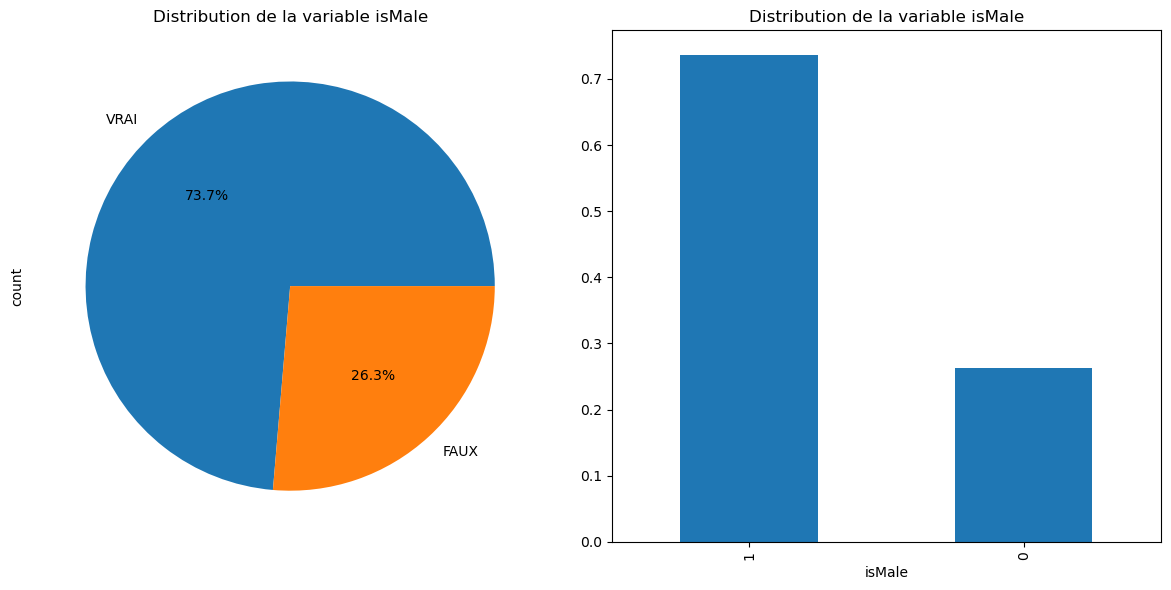

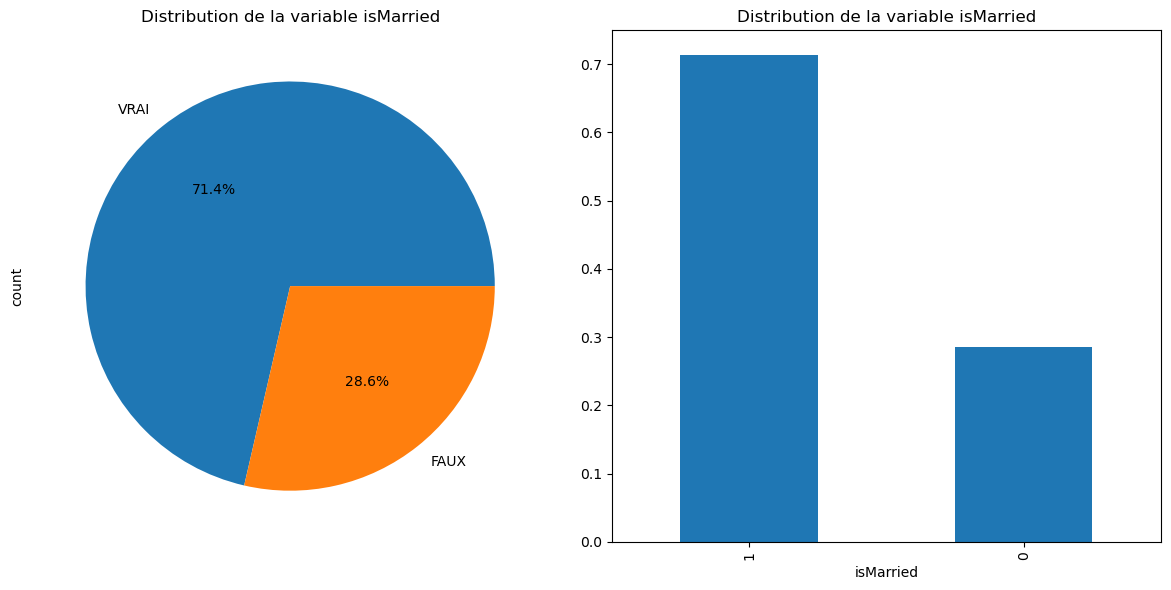

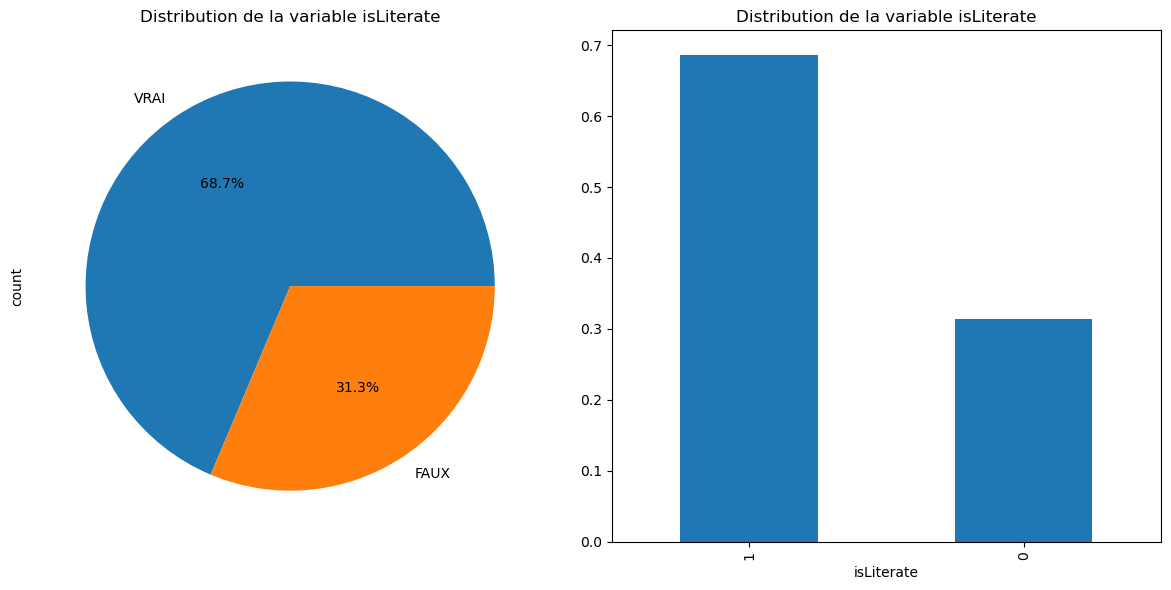

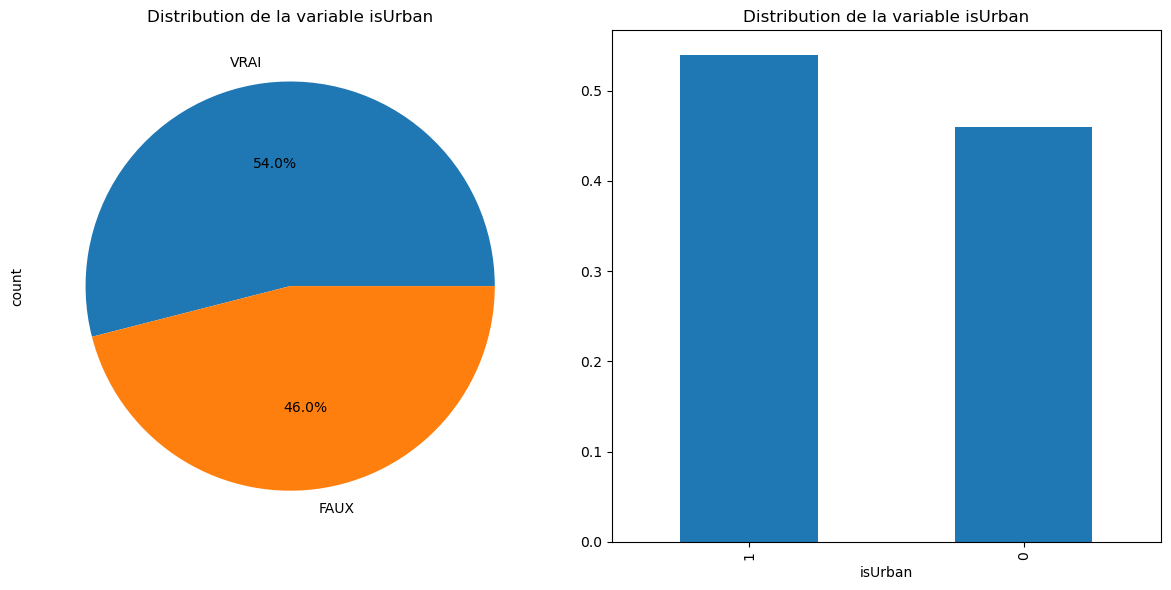

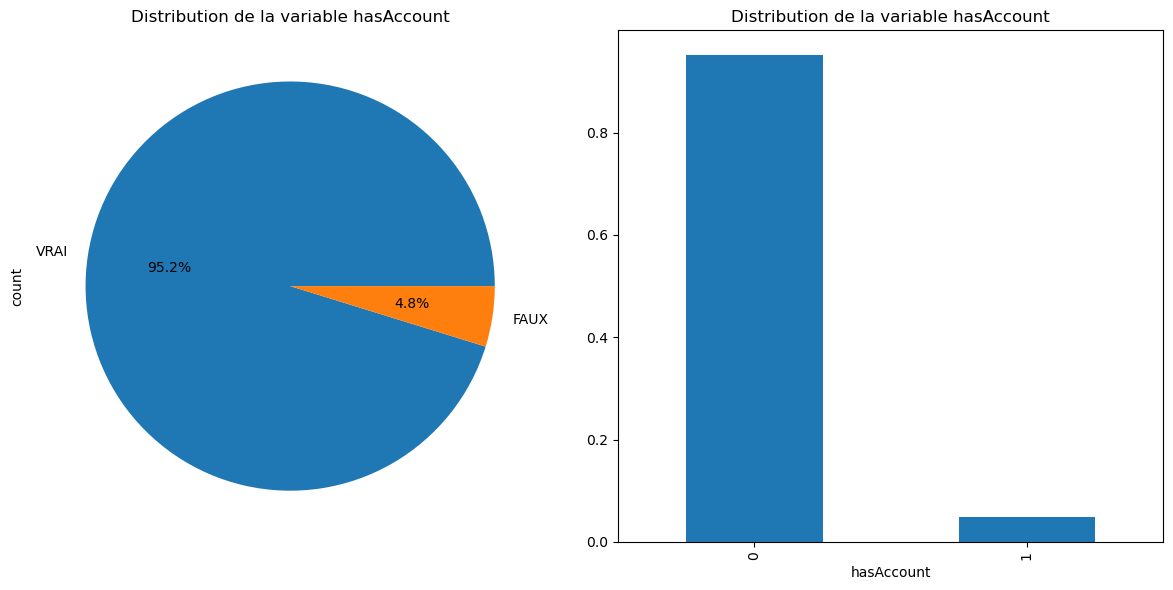

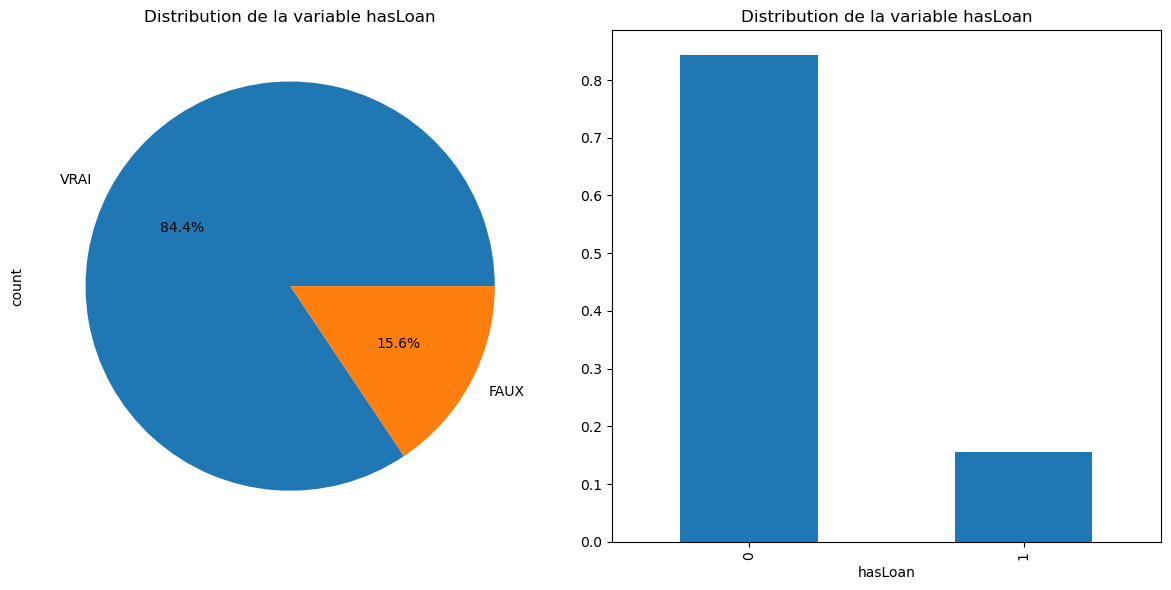

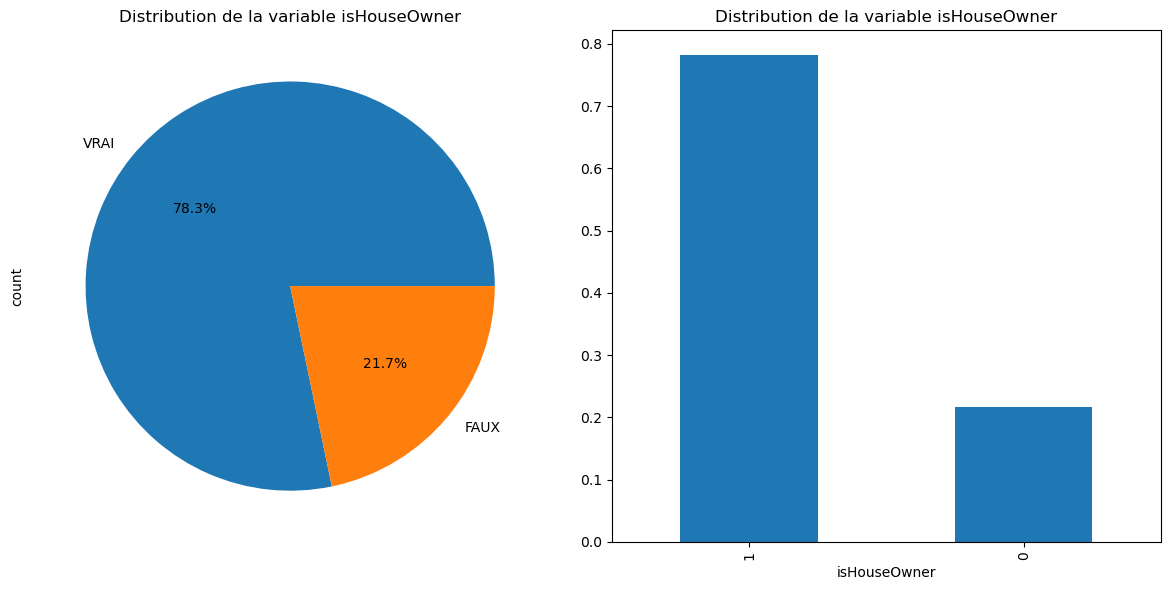

In [83]:
col=['isMale', 'isMarried', 'isLiterate', 'isUrban', 'hasAccount', 'hasLoan', 'isHouseOwner']
for i in col:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    labels = ['VRAI', 'FAUX']
    df[i].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', labels=labels, ax=axs[0])
    axs[0].set_title(f'Distribution de la variable {i}')

    df[i].value_counts(dropna=False, normalize=True).plot(kind='bar', ax=axs[1])
    axs[1].set_title(f'Distribution de la variable {i}')

    plt.tight_layout()
    plt.show()

In [84]:
df.describe()

ID  GDP_variation       Weight          Age  HouseholdSize   
count    4016.000000   4.016000e+03  4016.000000  4016.000000    4016.000000  \
mean   501188.170568   9.344590e-02   220.455677    45.572211       5.488048   
std    288797.931402   2.775903e-17   179.966066    16.018942       2.785187   
min       106.000000   9.344590e-02  -213.000000    -2.000000       1.000000   
25%    254361.000000   9.344590e-02   137.000000    33.000000       4.000000   
50%    492900.500000   9.344590e-02   176.000000    43.000000       5.000000   
75%    757083.000000   9.344590e-02   233.000000    56.000000       7.000000   
max    999938.000000   9.344590e-02  2150.000000   220.000000      22.000000   

            isMale    isMarried   isLiterate  nYearsEducation      isUrban   
count  4016.000000  4016.000000  4016.000000      4016.000000  4016.000000  \
mean      0.736554     0.713894     0.686504         4.091716     0.539841   
std       0.440557     0.451996     0.463972         4.228223     0.498472   
min       0.000000     0.000000     0.000000         0.000000     0.000000   
25%       0.000000     0.000000     0.000000         0.000000     0.000000   
50%       1.000000     1.000000     1.000000         3.000000     1.000000   
75%       1.000000     1.000000     1.000000         6.000000     1.000000   
max       1.000000     1.000000     1.000000        17.000000     1.000000   

       LaborStatus   hasAccount      hasLoan  isHouseOwner   
count  4016.000000  4016.000000  4016.000000   4016.000000  \
mean      0.252490     0.047809     0.156125      0.782620   
std       0.531446     0.213388     0.363019      0.412515   
min       0.000000     0.000000     0.000000      0.000000   
25%       0.000000     0.000000     0.000000      1.000000   
50%       0.000000     0.000000     0.000000      1.000000   
75%       0.000000     0.000000     0.000000      1.000000   
max       2.000000     1.000000     1.000000      1.000000   

       yTotalHouseholdSpendings  yTotalHouseholdSpendingsUSD  
count              4.016000e+03                  4016.000000  
mean               2.267523e+04                  2118.907605  
std                4.075598e+04                  3808.479508  
min                0.000000e+00                     0.000000  
25%                6.925500e+03                   647.159570  
50%                1.357400e+04                  1268.434619  
75%                2.568480e+04                  2400.139160  
max                1.347197e+06                125890.012500

### Répartition des données et outliers <a id='data-out'></a>

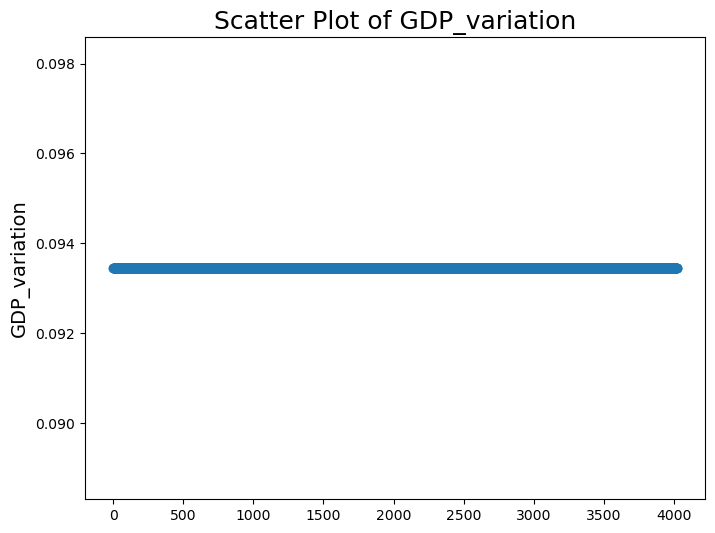

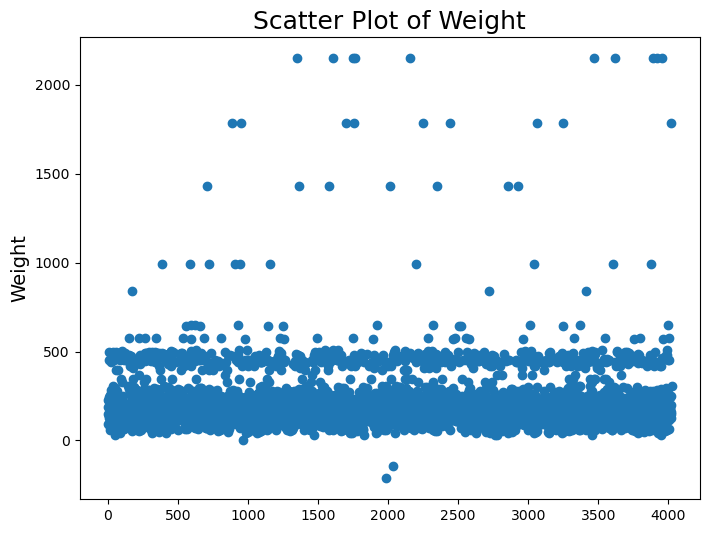

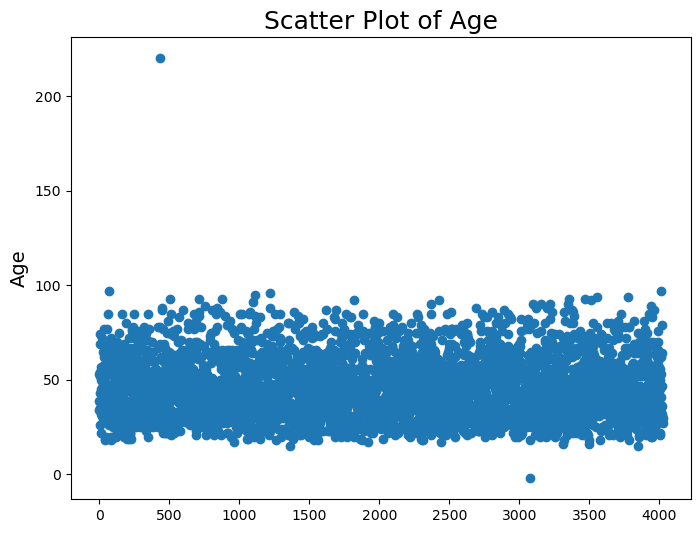

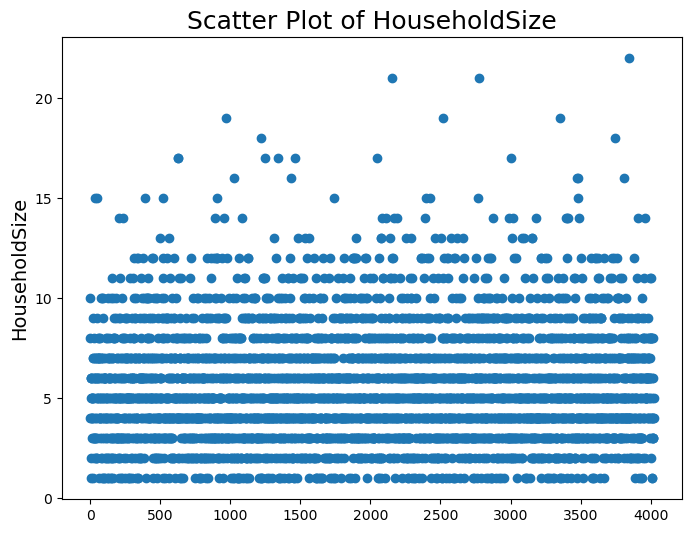

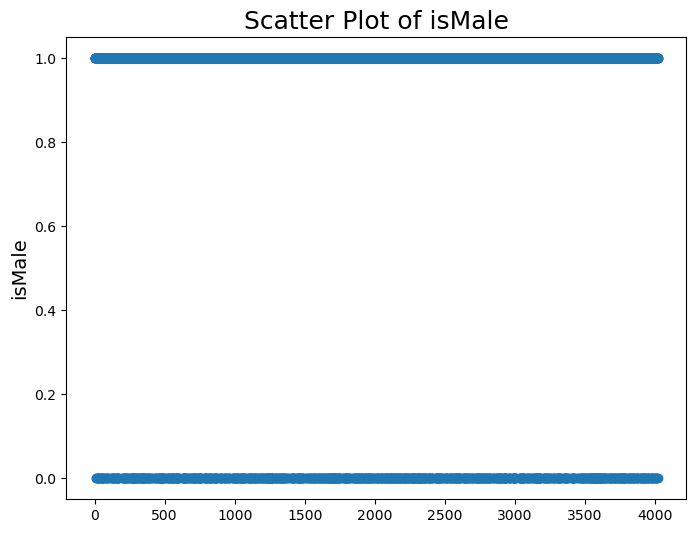

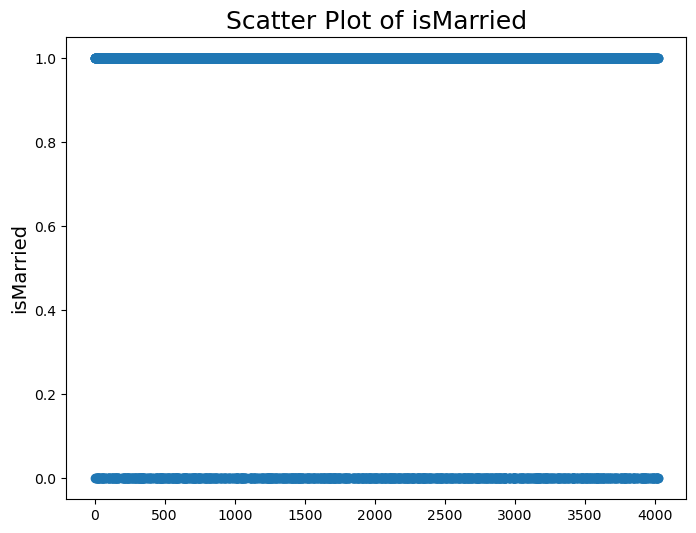

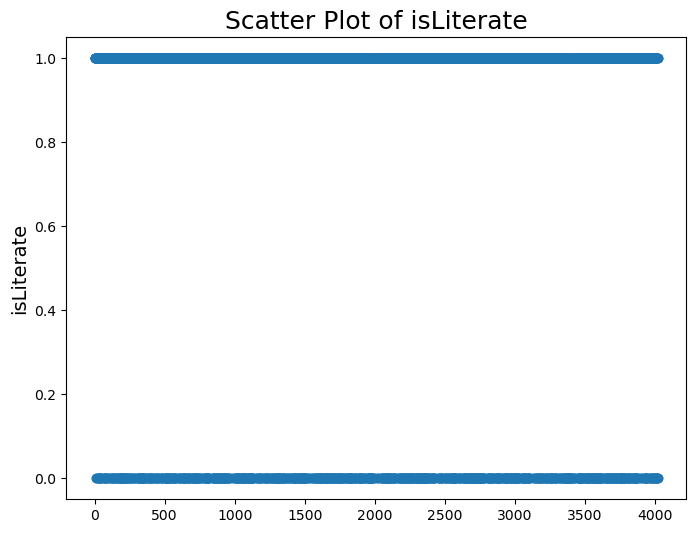

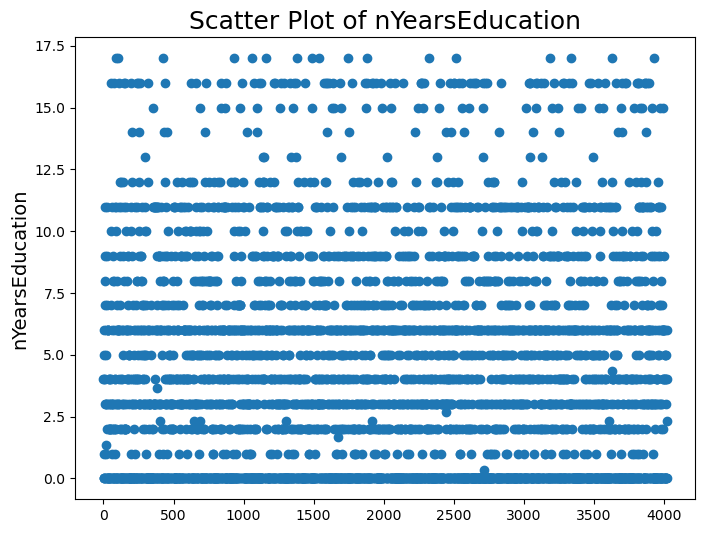

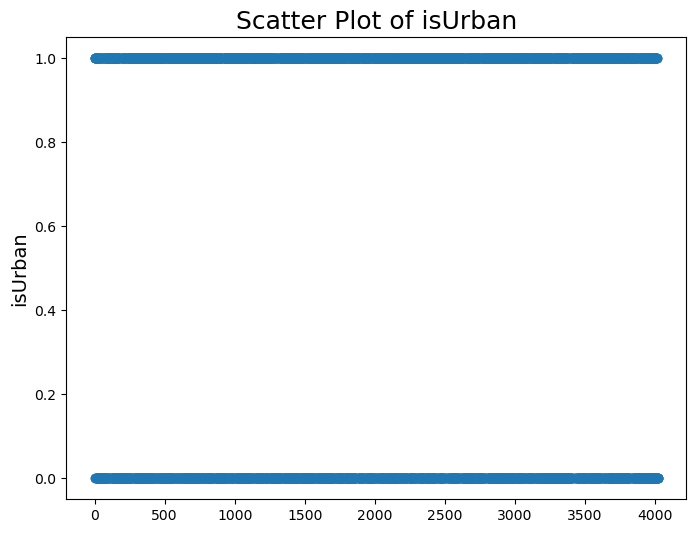

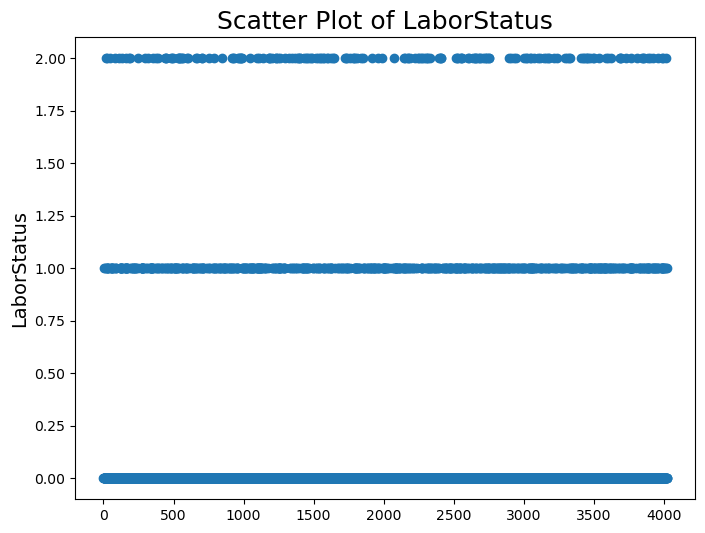

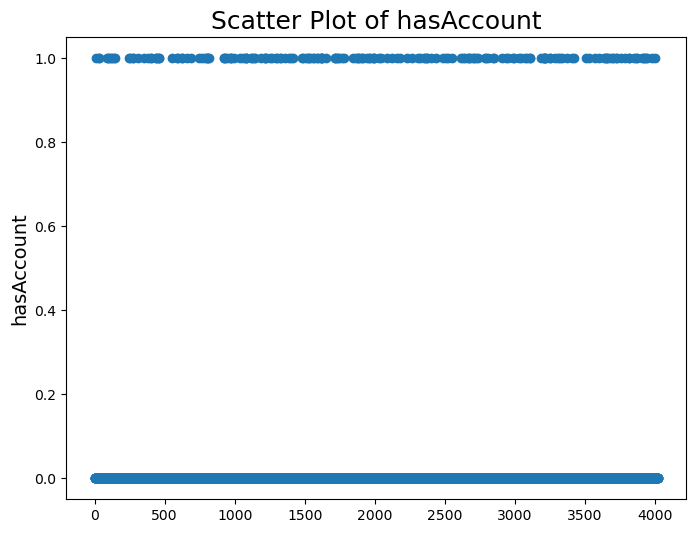

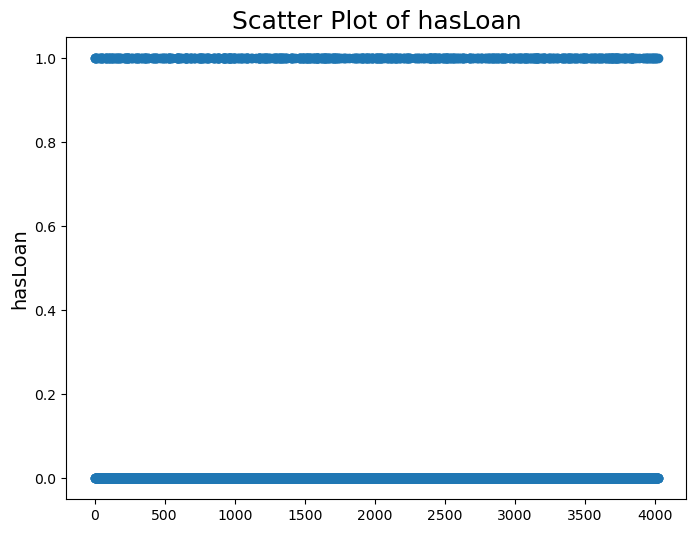

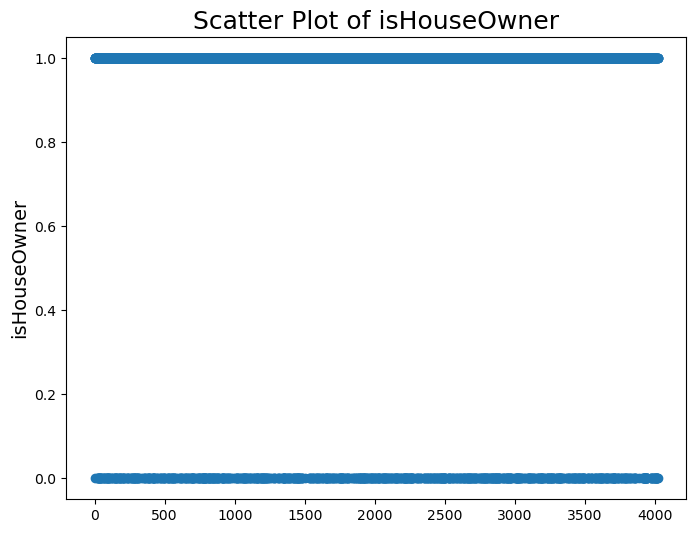

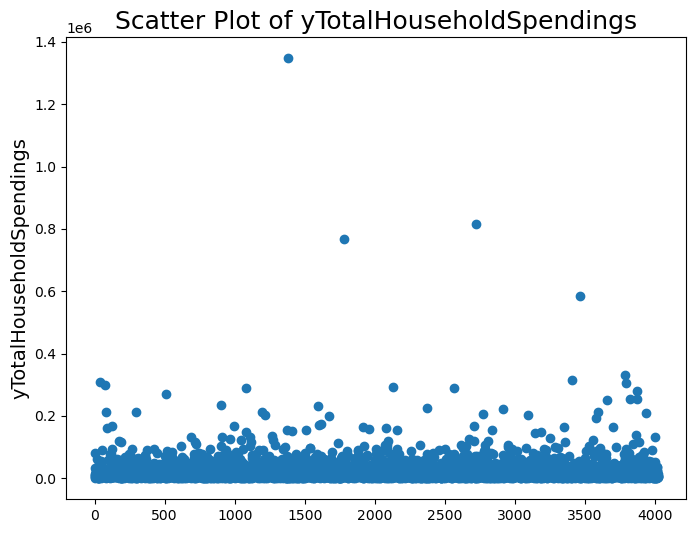

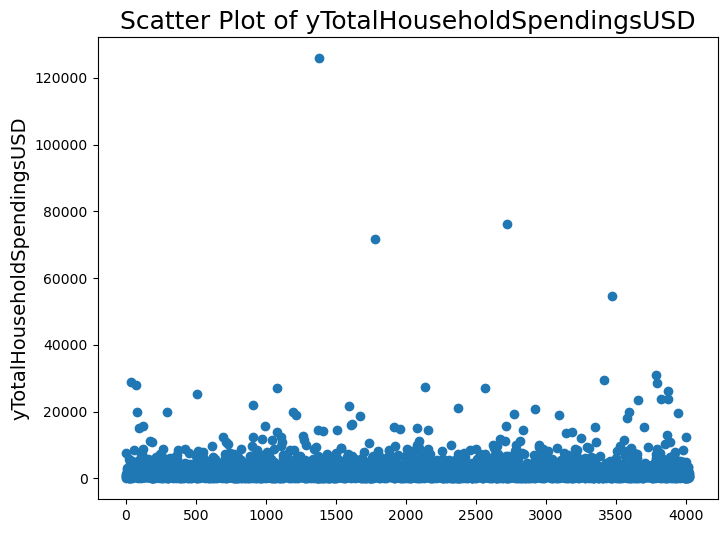

In [85]:
# Afin de se familiariser avec le dataset nous allons afficher chacune des composantes
_df=df.drop(['ID'], axis=1)

for column in _df.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(_df.index, _df[column])
    plt.title(f'Scatter Plot of {column}', fontsize=18)
    plt.ylabel(column, fontsize=14)
    plt.show()

In [87]:
#Analyse skewness 
#Le but est d'analyser la répartition et la symétrie des données pour voir si il y a des outliers
_df.skew()

GDP_variation                   0.000000
Weight                          5.579625
Age                             0.863932
HouseholdSize                   1.045963
isMale                         -1.074420
isMarried                      -0.946916
isLiterate                     -0.804346
nYearsEducation                 0.989879
isUrban                        -0.159931
LaborStatus                     2.022764
hasAccount                      4.240319
hasLoan                         1.895468
isHouseOwner                   -1.370910
yTotalHouseholdSpendings       14.243757
yTotalHouseholdSpendingsUSD    14.243757
dtype: float64

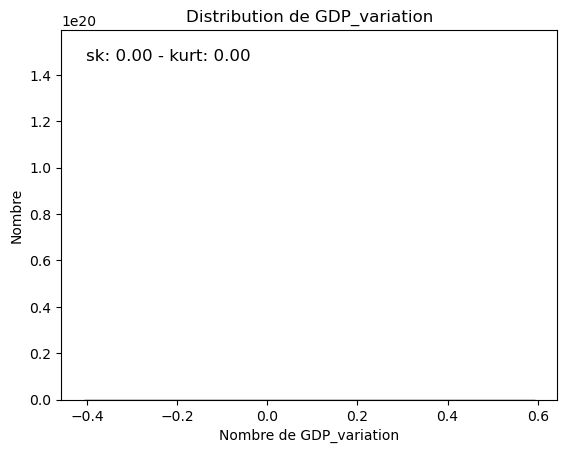

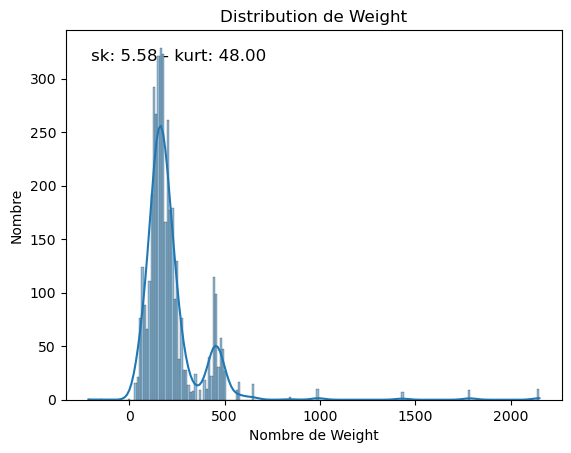

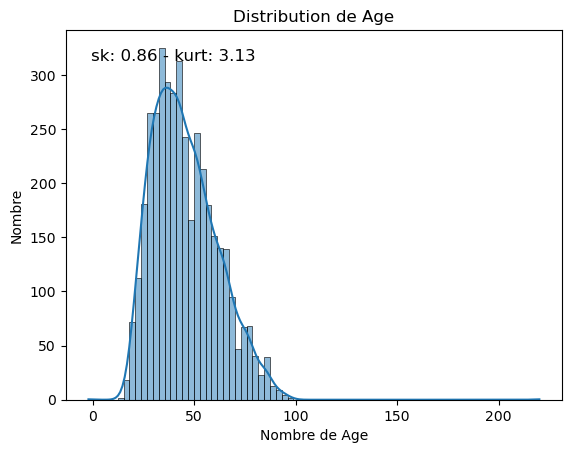

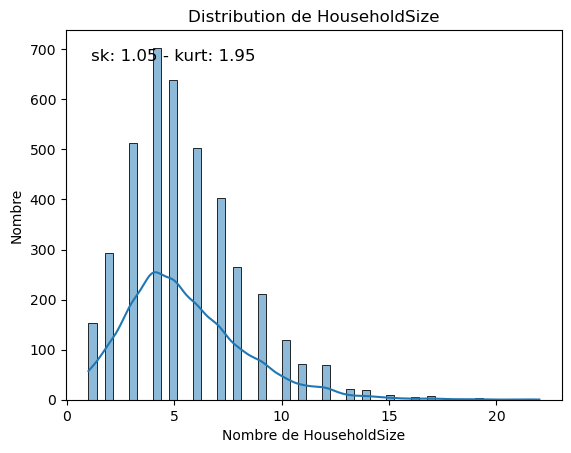

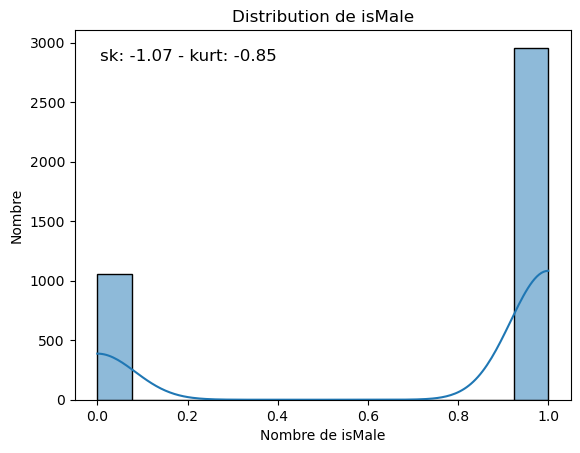

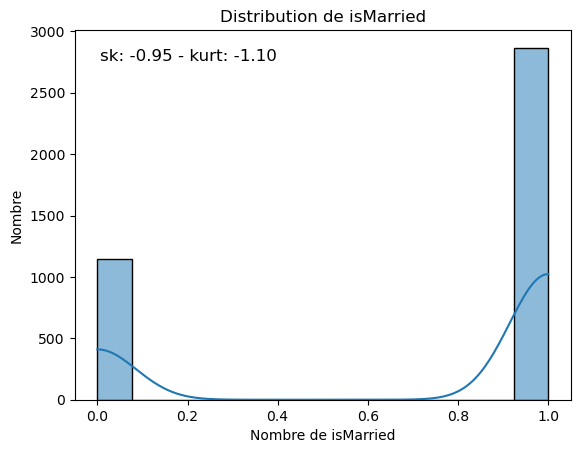

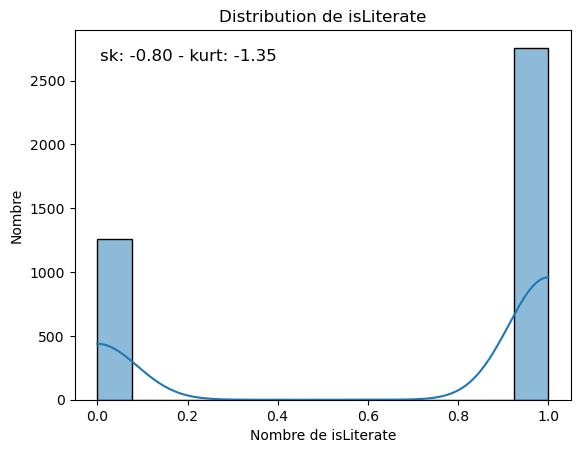

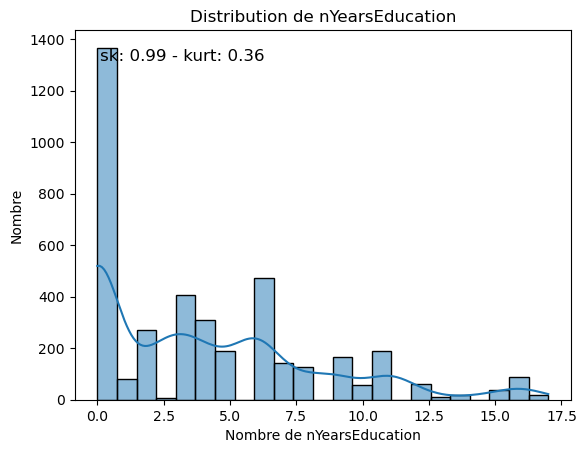

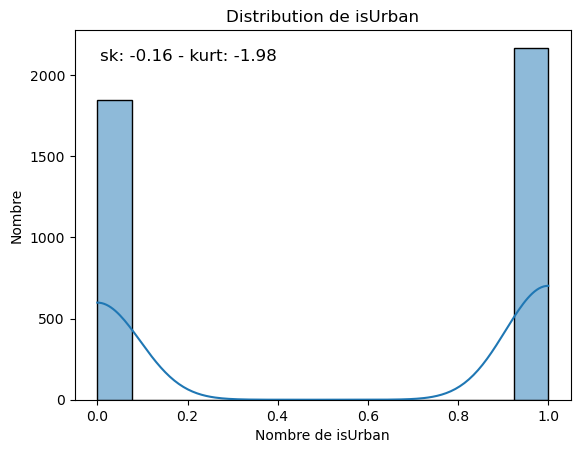

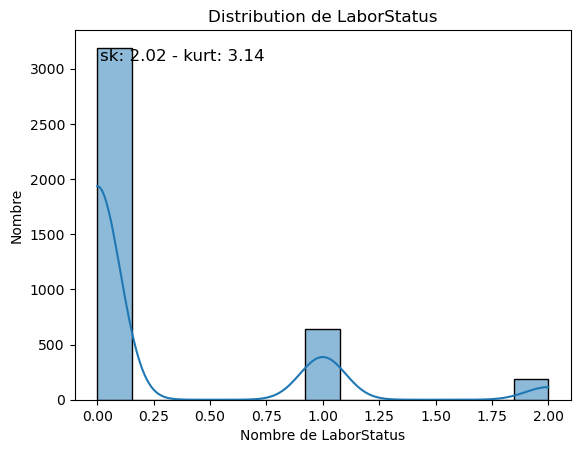

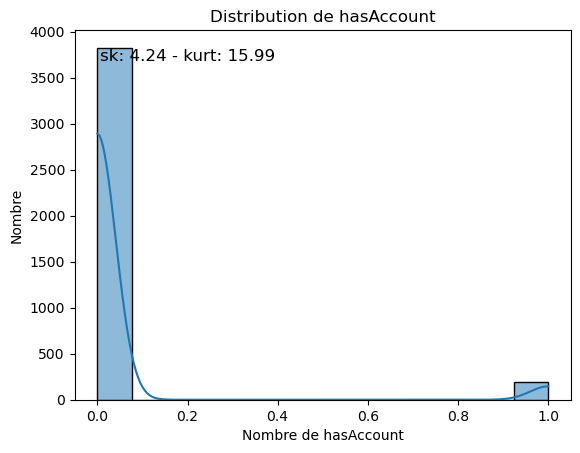

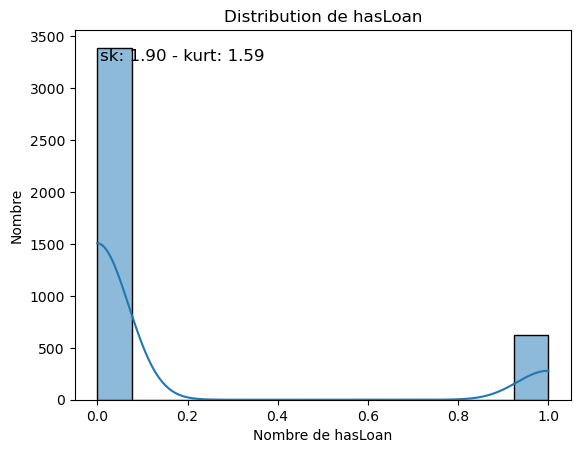

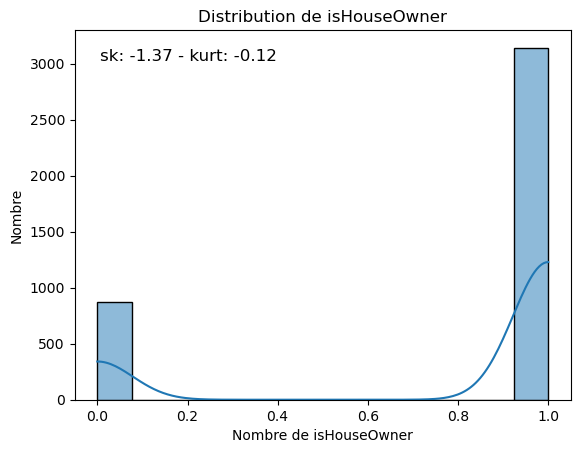

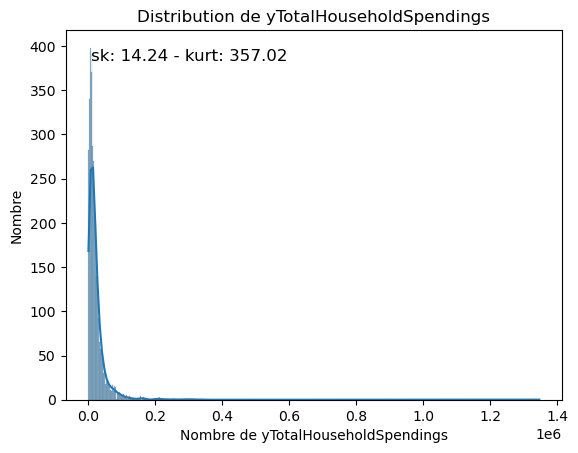

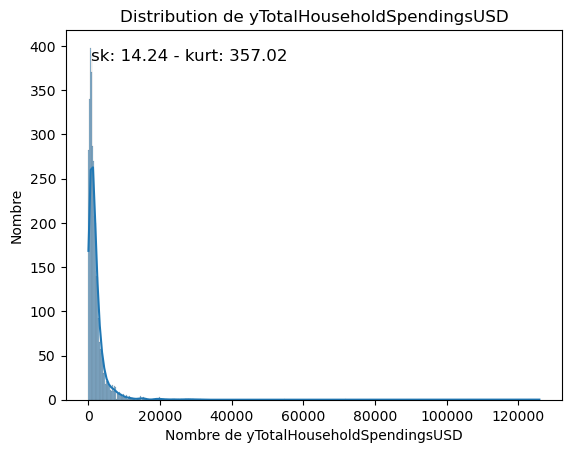

In [88]:
# Histogramme des variables & analyse skewness & kurtosis
for i in _df.columns:
    sns.histplot(_df[i], kde=True)
    plt.title(f'Distribution de {i}')
    plt.xlabel(f'Nombre de {i}')
    plt.ylabel(f'Nombre')
    sk = _df[i].skew() 
    kurt = _df[i].kurtosis() 
    plt.text(0.05, 0.95, f'sk: {sk:.2f} - kurt: {kurt:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.show()


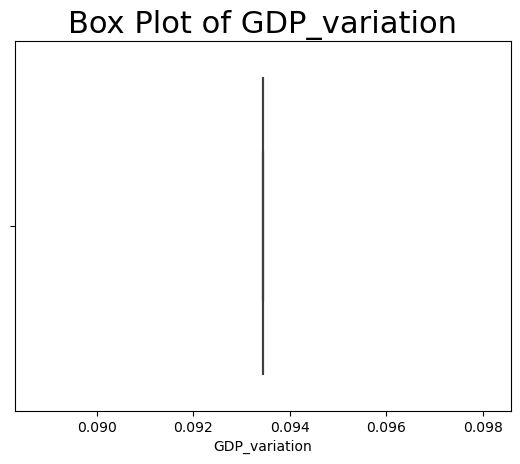

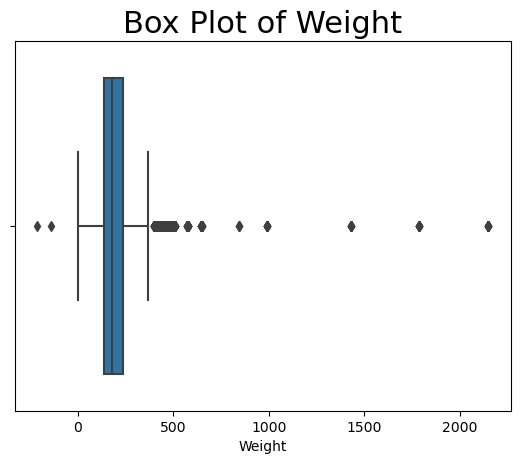

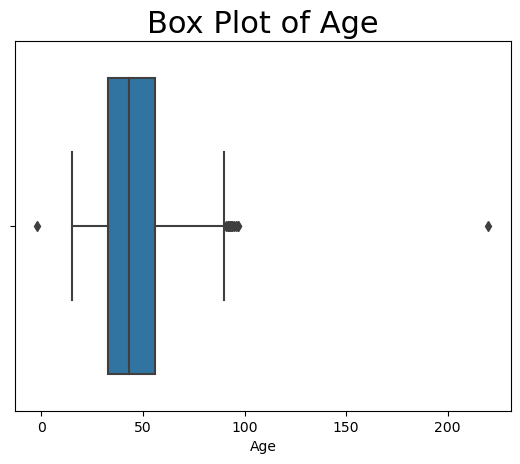

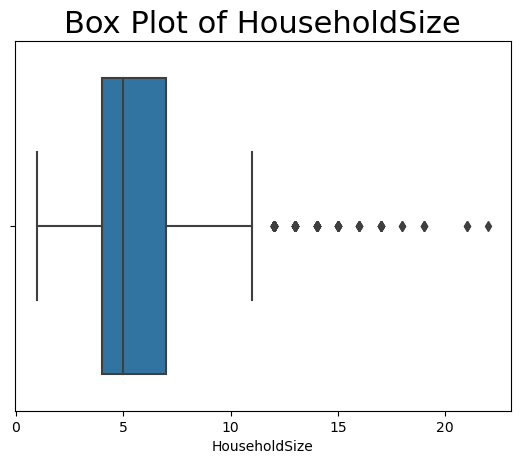

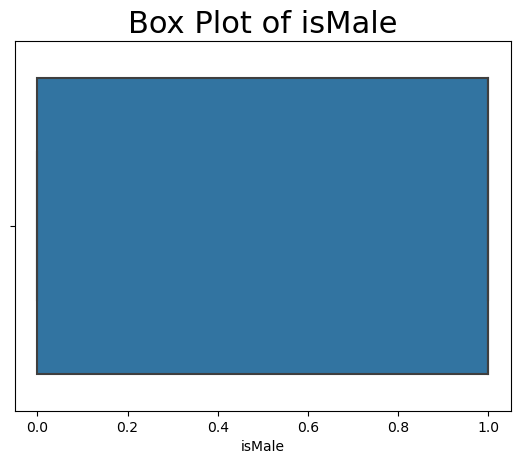

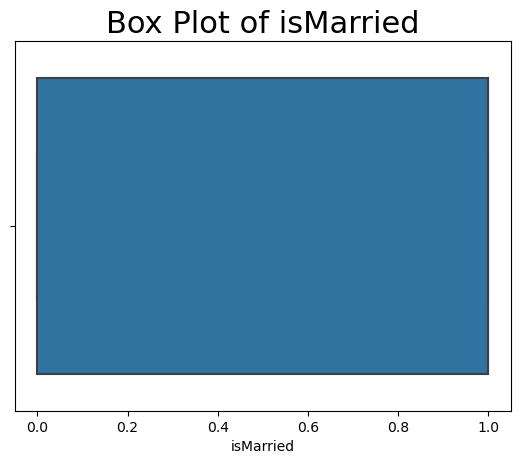

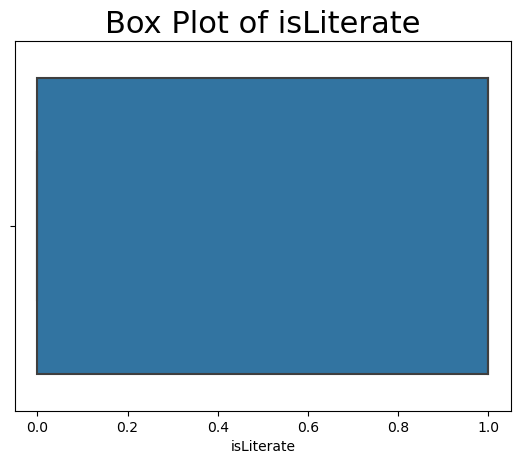

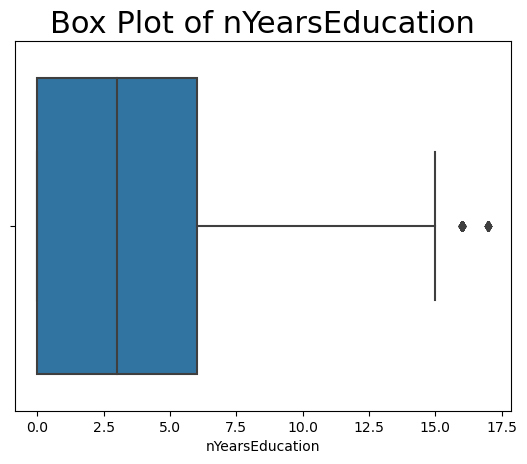

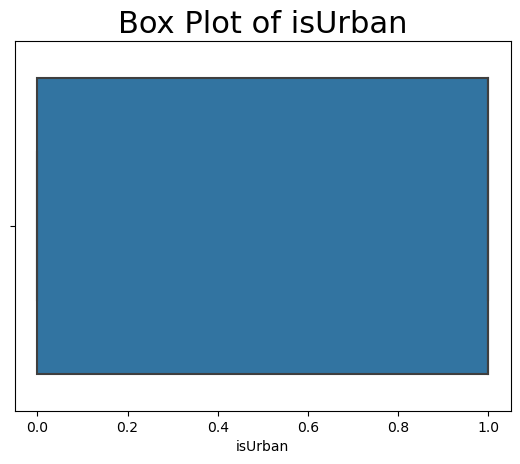

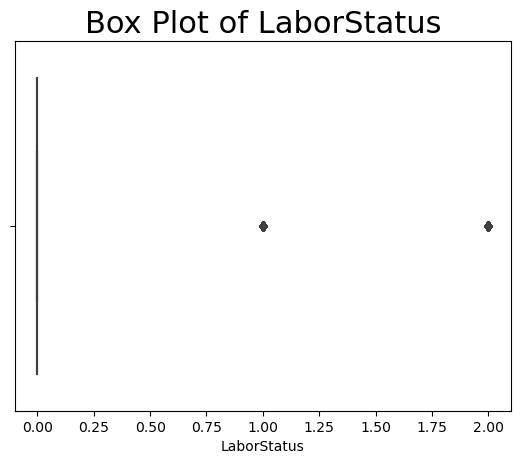

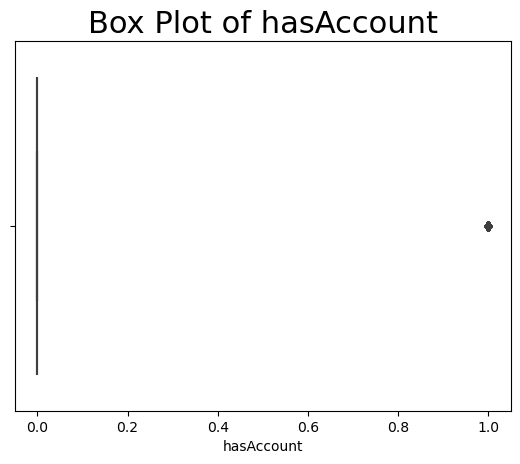

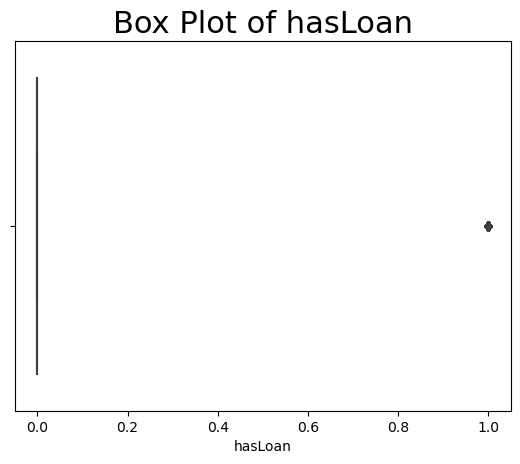

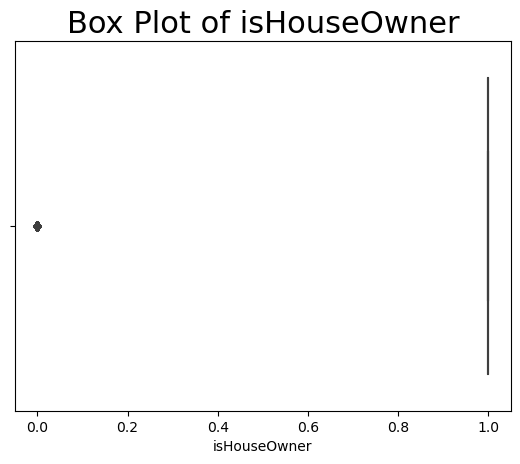

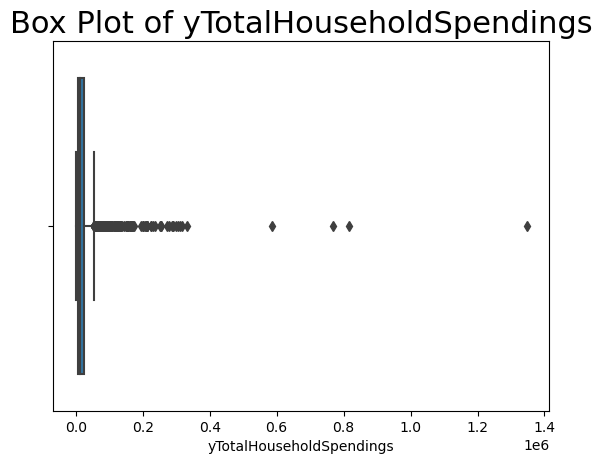

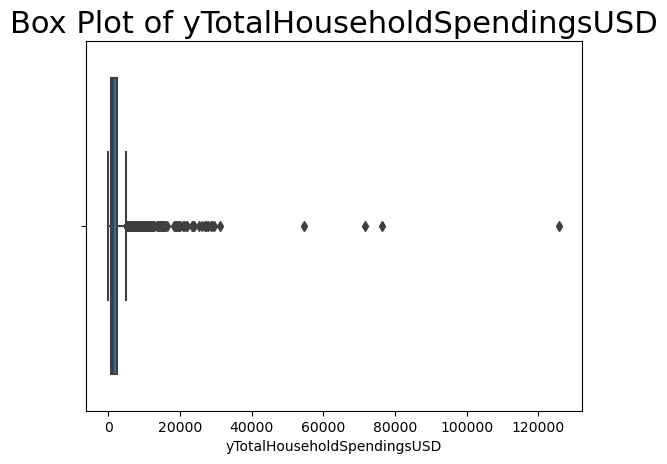

In [89]:
for column in _df.columns:
    sns.boxplot(x=_df[column])
    plt.title(f'Box Plot of {column}', fontsize=22)
    plt.show()

Anomalies dans les données
La variable Weight :

Contient des valeurs négatives.
Contient des valeurs supérieures à 2000 kg.
La variable Age :

Contient des valeurs négatives.
Contient des valeurs supérieures à 110 ans.
La variable HouseholdSize :

Contient des valeurs atteignant 22.
La variable nYearsEducation :

Contient des valeurs atteignant 17,5 années.
La variable yTotalHouseholdSpendingsUSD / yTotalHouseholdSpendings :

Contient des valeurs atteignant 125 890 dollars.
Contient des valeurs atteignant 1 347 197,00 dollars...

## HouseholdSize

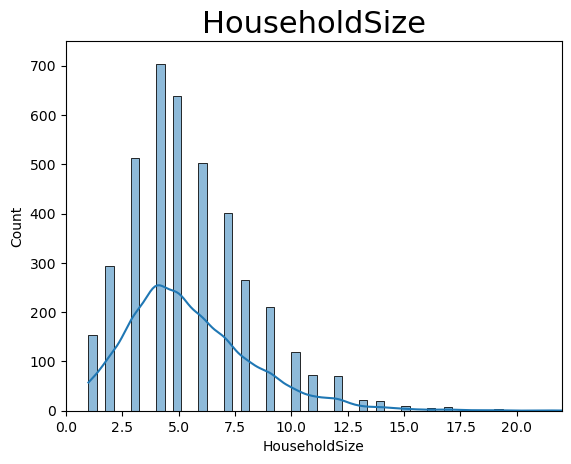

In [93]:
sns.histplot(_df['HouseholdSize'], kde=True)
plt.title('HouseholdSize', fontsize=22)
plt.ylim(0, 750)
plt.xlim(0, 22)
plt.show()

In [94]:
Q1 = df['HouseholdSize'].quantile(0.25)
Q3 = df['HouseholdSize'].quantile(0.75)
IQR = Q3 - Q1

# Définition des limites pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Échantillon des valeurs aberrantes
outliers = df[(df['HouseholdSize'] < lower_bound) | (df['HouseholdSize'] > upper_bound)]
outliers_sorted = outliers.sort_values(by='HouseholdSize', ascending=True)

print("Nombre de valeurs aberrantes:", outliers_sorted.shape[0])
print("Valeurs aberrantes:")
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)
print(outliers_sorted)

Nombre de valeurs aberrantes: 142
Valeurs aberrantes:
lower_bound: -0.5
upper_bound: 11.5
          ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
2153  703850       0.093446     232  33.0             12       1          1  \
1897  879844       0.093446     241  38.0             12       1          1   
1892  572955       0.093446      91  71.0             12       1          1   
1884  903512       0.093446     210  38.0             12       1          1   
1879  451420       0.093446     348  51.0             12       1          1   
...      ...            ...     ...   ...            ...     ...        ...   
2521  718405       0.093446     207  77.0             19       1          1   
3352  625398       0.093446     116  70.0             19       1          1   
2152  216082       0.093446     483  65.0             21       1          1   
2776  664883       0.093446      32  71.0             21       1          1   
3846  511341       0.093446     171  75.0

In [1189]:
df['HouseholdSize'].sort_values(ascending=True).head()

2731    1
3110    1
516     1
3101    1
533     1
Name: HouseholdSize, dtype: int64

In [97]:
df['HouseholdSize'].sort_values(ascending=True).tail(15)

2044    17
1250    17
1343    17
3004    17
630     17
629     17
1463    17
1218    18
3749    18
2521    19
3352    19
967     19
2776    21
2152    21
3846    22
Name: HouseholdSize, dtype: int64

In [95]:
df['HouseholdSize'].unique()

array([ 4,  8, 10,  1,  5,  6,  2,  3,  7,  9, 15, 11, 14, 12, 13, 17, 19,
       16, 18, 21, 22])

Un ménage peut comprendre non seulement des membres d’une même famille, mais aussi d’autres personnes. Je ne supprimerai que les plus grandes valeurs aberrantes.

In [98]:
df = df[~((df['HouseholdSize'] <= 0) | (df['HouseholdSize'] > 18))]

## Weight

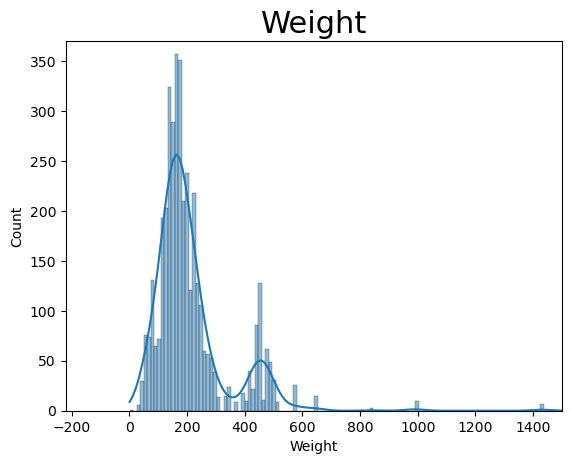

In [116]:
sns.histplot(df['Weight'], kde=True)
plt.title('Weight', fontsize=22)
plt.ylim(0, 370)
plt.xlim(-220, 1500)
plt.show()

In [100]:
df[df['Weight']<400]

ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
0     408112       0.093446     187  34.0              4       1          1  \
1      99522       0.093446      95  39.0              8       1          1   
2     450411       0.093446     225  53.0             10       1          1   
3     230464       0.093446     148  54.0              1       1          0   
4     187256       0.093446     221  69.0              5       1          1   
...      ...            ...     ...   ...            ...     ...        ...   
4018  640576       0.093446     128  64.0              3       1          1   
4019  288611       0.093446     197  79.0              3       0          0   
4020  354302       0.093446     161  36.0              3       1          0   
4022  168832       0.093446     150  27.0              5       1          1   
4023  315705       0.093446     307  30.0              4       1          1   

      isLiterate  nYearsEducation  isUrban  LaborStatus  hasAccount  hasLoan   
0              1         4.000000        1            0           0        1  \
1              1         0.000000        1            0           0        0   
2              1         4.000000        1            0           0        0   
3              1         5.000000        1            1           0        0   
4              1         0.000000        0            0           0        1   
...          ...              ...      ...          ...         ...      ...   
4018           0         0.000000        0            0           0        0   
4019           0         0.000000        0            1           0        0   
4020           1         6.000000        0            0           0        0   
4022           1         4.000000        0            0           0        0   
4023           1         2.333333        0            0           0        1   

      isHouseOwner  yTotalHouseholdSpendings  yTotalHouseholdSpendingsUSD  
0                1                     518.4                    48.442352  
1                1                   12000.0                  1121.350781  
2                1                   80160.0                  7490.623438  
3                1                   13584.0                  1269.369043  
4                1                    3200.0                   299.026880  
...            ...                       ...                          ...  
4018             0                    8899.2                   831.593750  
4019             1                    5932.8                   554.395801  
4020             1                    3494.4                   326.537354  
4022             1                    4288.0                   400.695996  
4023             1                   14400.0                  1345.620898  

[3482 rows x 16 columns]

In [1196]:
df[df['Weight']>=400]

ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
9     671215       0.093446     498  74.0              2       0        0.0  \
10    506740       0.093446     451  35.0              5       1        1.0   
23    847381       0.093446     443  72.0              1       0        0.0   
29    405630       0.093446     451  48.0              3       1        1.0   
33    981133       0.093446     495  39.0              6       0        0.0   
...      ...            ...     ...   ...            ...     ...        ...   
3998  816112       0.093446     647  29.0              6       1        1.0   
3999   94807       0.093446     451  55.0              7       1        1.0   
4004  947846       0.093446     452  34.0              4       1        1.0   
4007  894443       0.093446     574  22.0              4       1        1.0   
4017  973408       0.093446    1786  31.0              4       0        0.0   

      isLiterate  nYearsEducation  isUrban  LaborStatus  hasAccount  hasLoan   
9            1.0              3.0        1            1         0.0      0.0  \
10           1.0              8.0        1            0         1.0      1.0   
23           0.0              0.0        1            1         0.0      0.0   
29           1.0              6.0        1            1         0.0      0.0   
33           1.0              6.0        1            1         1.0      0.0   
...          ...              ...      ...          ...         ...      ...   
3998         1.0              9.0        1            0         0.0      0.0   
3999         1.0              6.0        1            1         0.0      0.0   
4004         1.0              4.0        1            0         0.0      0.0   
4007         1.0              5.0        0            0         0.0      0.0   
4017         1.0              5.0        0            0         0.0      0.0   

      isHouseOwner  yTotalHouseholdSpendings  yTotalHouseholdSpendingsUSD  
9              1.0              14400.000000                  1345.620898  
10             1.0              16492.000000                  1541.109766  
23             1.0               9616.000000                   898.575781  
29             1.0                 96.000000                     8.970806  
33             1.0              24572.001563                  2296.152734  
...            ...                       ...                          ...  
3998           1.0              51072.000000                  4772.468750  
3999           1.0               2304.000000                   215.299341  
4004           0.0              12192.000000                  1139.292383  
4007           0.0               8345.600000                   779.862061  
4017           1.0              15648.000000                  1462.241406  

[528 rows x 16 columns]

In [117]:
df['Weight'].sort_values(ascending=True).tail(27)

1155     991
2852    1431
2010    1431
1360    1431
2350    1431
1577    1431
2927    1431
705     1431
949     1786
888     1786
3059    1786
1701    1786
3245    1786
1756    1786
2248    1786
4017    1786
2440    1786
1352    2150
3618    2150
3918    2150
3471    2150
3893    2150
3952    2150
1760    2150
1752    2150
2154    2150
1607    2150
Name: Weight, dtype: int64

In [103]:
df['Weight'].sort_values(ascending=True).head()

1987   -213
2037   -142
963       1
1472     32
50       32
Name: Weight, dtype: int64

In [104]:
df['Weight'].unique()

array([ 187,   95,  225,  148,  221,  247,  138,  126,  498,  451,  210,
        184,   78,   60,  256,  144,  178,  151,  135,  134,  252,  443,
        281,  245,  146,  199,   84,  495,  226,  307,  475,  173,  112,
        169,  123,  453,  474,   56,  239,  167,   32,  293,  466,  155,
        396,  500,  276,   76,  190,  125,   74,  261,  176,  145,  398,
        129,  124,  181,   91,  203,  481,  154,  222,   44,   99,  127,
        198,  165,  343,  161,  172,   69,  501,  180,  108,  331,  117,
        186,  160,  251,  131,  207,  175,   67,  136,  205,   70,  493,
        116,  110,  195,  189,  191,  106,  197,  171,  119,  166,  147,
        449,  118,  201,  209,  287,  113,  574,  483,  114,  419,  445,
         53,  842,  202,  406,  163,  152,  299,  156,  142,   58,  211,
        194,  235,  369,  122,  192,  482,  473,  428,   57,  183,  246,
        158,  168,  137,  208,  232,  107,  143,  452,  255,  206,   81,
        494,  200,  174,   77,  204,  486,  238,  1

In [106]:
df['Weight'] = abs(df['Weight'])

In [107]:
Q1 = df['Weight'].quantile(0.25)
Q3 = df['Weight'].quantile(0.75)
IQR = Q3 - Q1

# Définition des limites pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Échantillon des valeurs aberrantes
outliers_Weight = df[(df['Weight'] < lower_bound) | (df['Weight'] > upper_bound)]
outliers_sorted = outliers.sort_values(by='Weight', ascending=True)

print("Nombre de valeurs aberrantes:", outliers_sorted.shape[0])
print("Valeurs aberrantes:")
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)
print(outliers_sorted)

Nombre de valeurs aberrantes: 142
Valeurs aberrantes:
lower_bound: -7.0
upper_bound: 377.0
          ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
2776  664883       0.093446      32  71.0             21       1          1  \
3155   71358       0.093446      53  45.0             13       0          0   
3601  681502       0.093446      56  66.0             12       1          1   
3409  379227       0.093446      57  49.0             14       1          1   
2768  215299       0.093446      57  36.0             15       1          1   
...      ...            ...     ...   ...            ...     ...        ...   
1659  287035       0.093446     483  63.0             12       1          1   
2152  216082       0.093446     483  65.0             21       1          1   
1125  906413       0.093446     498  71.0             12       1          1   
836   928547       0.093446     498  62.0             12       1          1   
3022  308872       0.093446     501  52.

Étant donné que le poids a des valeurs aussi élevées, il est peu probable qu'il s'agisse du poids physique des répondants en kilogrammes. L'interprétation la plus probable est un poids statistique utilisé pour ajuster l'échantillonnage dans les études socio-économiques. Ces poids peuvent être utilisés pour représenter la population et peuvent varier considérablement.

Un poids statistique utilisé pour ajuster l'échantillonnage dans la recherche socio-économique. Cette pondération permet de représenter la population générale, en tenant compte d'éventuelles irrégularités dans les données.

In [118]:
#On enlève les max qui déforment le dataset et sont beaucoup trop éloigné des autres valeurs

df = df[~((df['Weight'] <= 32) | (df['Weight'] > 1000))]


## Age

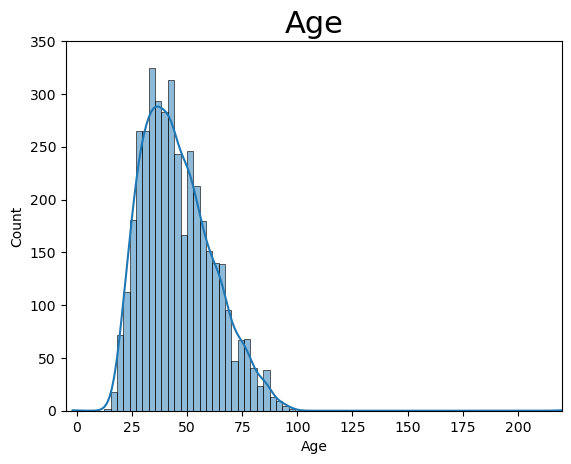

In [119]:
sns.histplot(_df['Age'], kde=True)
plt.title('Age', fontsize=22)
plt.ylim(0, 350)
plt.xlim(-5, 220)
plt.show()

In [120]:
Q1 = df['Age'].quantile(0.25) 
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

# Définition des limites pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Échantillon des valeurs aberrantes
outliers = df[(df['Age'] < lower_bound) | (df['Age'] > upper_bound)]
outliers_sorted = outliers.sort_values(by='Age', ascending=True)

print("Nombre de valeurs aberrantes:", outliers_sorted.shape[0])
print("Valeurs aberrantes:")
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)
print(outliers_sorted)

Nombre de valeurs aberrantes: 17
Valeurs aberrantes:
lower_bound: -1.5
upper_bound: 90.5
          ID  GDP_variation  Weight    Age  HouseholdSize  isMale  isMarried   
3079   37166       0.093446     184   -2.0              2       0          0  \
1101  333100       0.093446     163   91.0              3       1          1   
1820  678176       0.093446     298   92.0              4       1          1   
2426  383354       0.093446      76   92.0              5       1          0   
3509  105364       0.093446     141   92.0              4       1          1   
508   111897       0.093446     252   93.0              5       1          0   
713    58383       0.093446     187   93.0              8       0          0   
875   504005       0.093446     178   93.0              5       1          0   
3356   59744       0.093446     419   93.0              1       1          0   
3468  742070       0.093446     129   93.0              3       0          0   
3552  497509       0.093446    

In [121]:
df['Age'].sort_values(ascending=True)

3079     -2.0
1364     15.0
3849     15.0
3494     16.0
3312     16.0
        ...  
1113     95.0
1222     96.0
4013     97.0
68       97.0
438     220.0
Name: Age, Length: 3977, dtype: float64

In [122]:
df = df[~((df['Age'] <= 0) | (df['Age'] > 120))]

In [123]:
df.shape

(3975, 17)

##  yTotalHouseholdSpendings & yTotalHouseholdSpendingsUSD

(0.0, 30000.0)

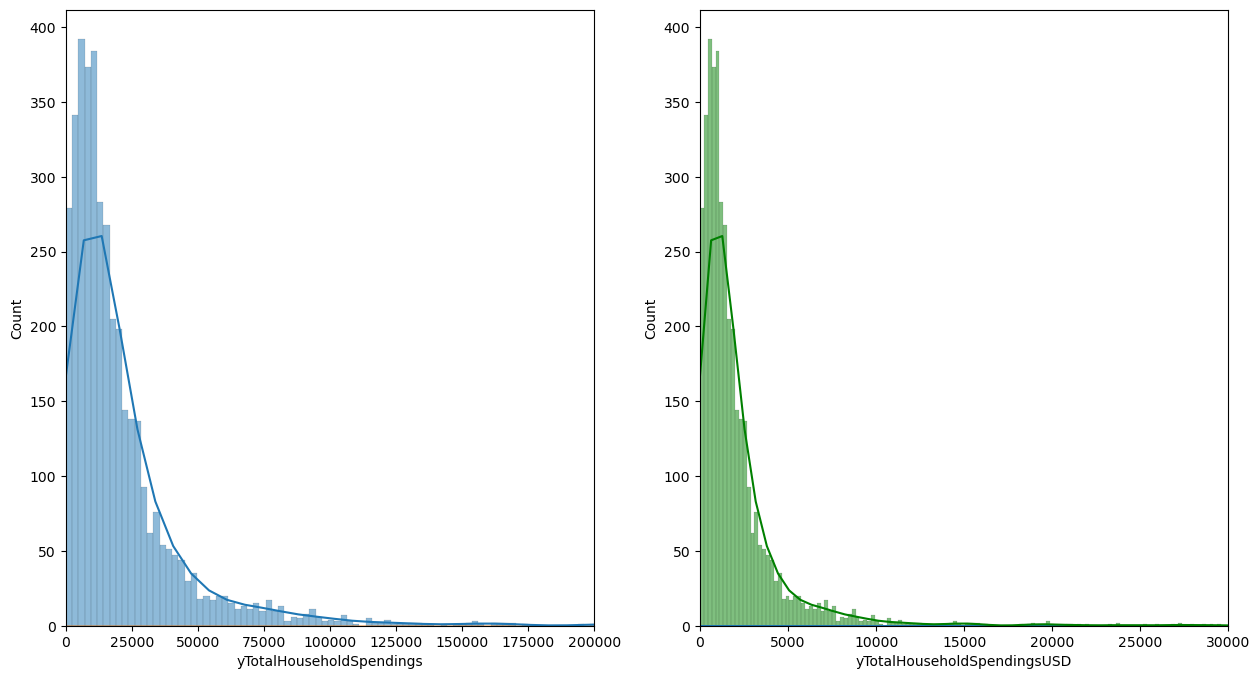

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.histplot(data=df, x='yTotalHouseholdSpendings', ax=ax[0], kde=True)
sns.kdeplot(data=df, x='yTotalHouseholdSpendings', ax=ax[0], fill=True, alpha=.5)
ax[0].set_xlim(0, 200000)

sns.histplot(data=df, x='yTotalHouseholdSpendingsUSD', ax=ax[1], kde=True, color='green')
sns.kdeplot(data=df, x='yTotalHouseholdSpendingsUSD', ax=ax[1], fill=True, alpha=.5)
ax[1].set_xlim(0, 30000) 

Nous appliquons une transformation logarithmique, qui réduit l'influence des grandes valeurs pouvant fausser le modèle. Ceci est particulièrement utile lorsque les données ont une longue « queue » (c'est-à-dire lorsque plusieurs observations ont des valeurs nettement plus grandes que d'autres).

/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


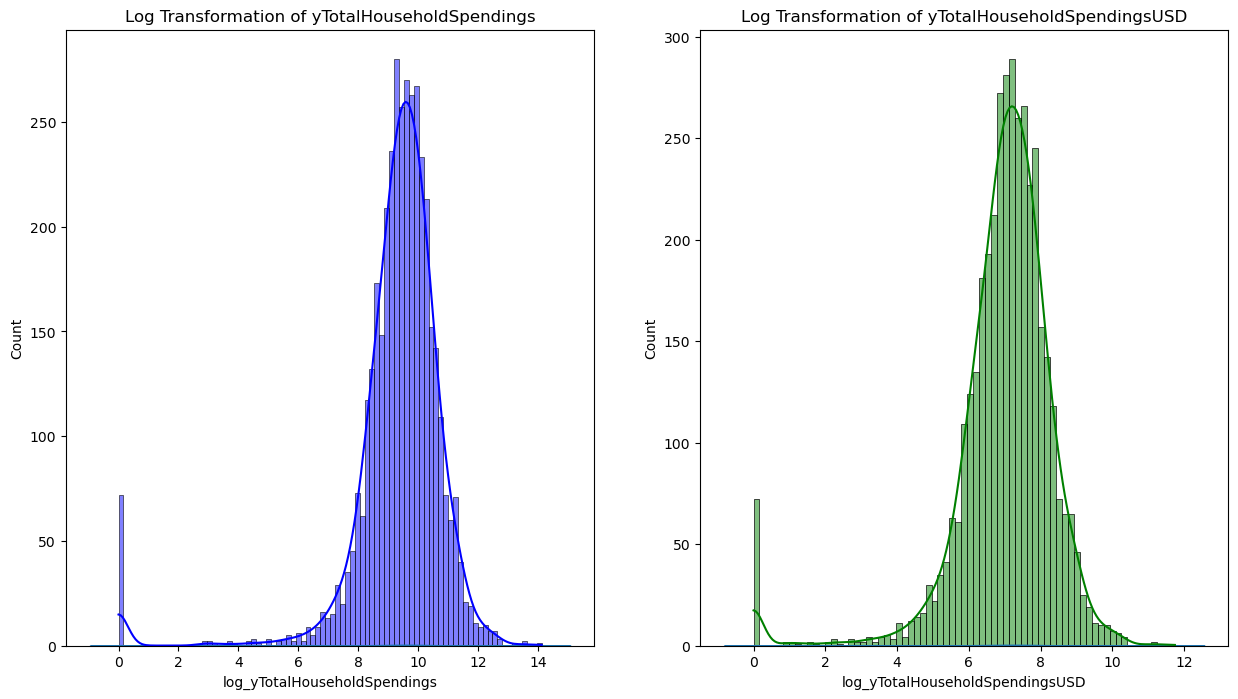

In [125]:
# Créer un objet FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

# Application de la transformation logarithmique aux variables
df['log_yTotalHouseholdSpendings'] = log_transformer.transform(df[['yTotalHouseholdSpendings']])
df['log_yTotalHouseholdSpendingsUSD'] = log_transformer.transform(df[['yTotalHouseholdSpendingsUSD']])

# Construction de graphiques pour comparer des distributions logarithmiques (pour réduire la variabilité et normaliser la distribution).
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# 'yTotalHouseholdSpendings'
sns.histplot(data=df, x='log_yTotalHouseholdSpendings', ax=ax[0], kde=True, color='blue')
sns.kdeplot(data=df, x='log_yTotalHouseholdSpendings', ax=ax[0], fill=True, alpha=.5)
ax[0].set_title('Log Transformation of yTotalHouseholdSpendings')

# 'yTotalHouseholdSpendingsUSD'
sns.histplot(data=df, x='log_yTotalHouseholdSpendingsUSD', ax=ax[1], kde=True, color='green')
sns.kdeplot(data=df, x='log_yTotalHouseholdSpendingsUSD', ax=ax[1], fill=True, alpha=.5)
ax[1].set_title('Log Transformation of yTotalHouseholdSpendingsUSD')

plt.show()


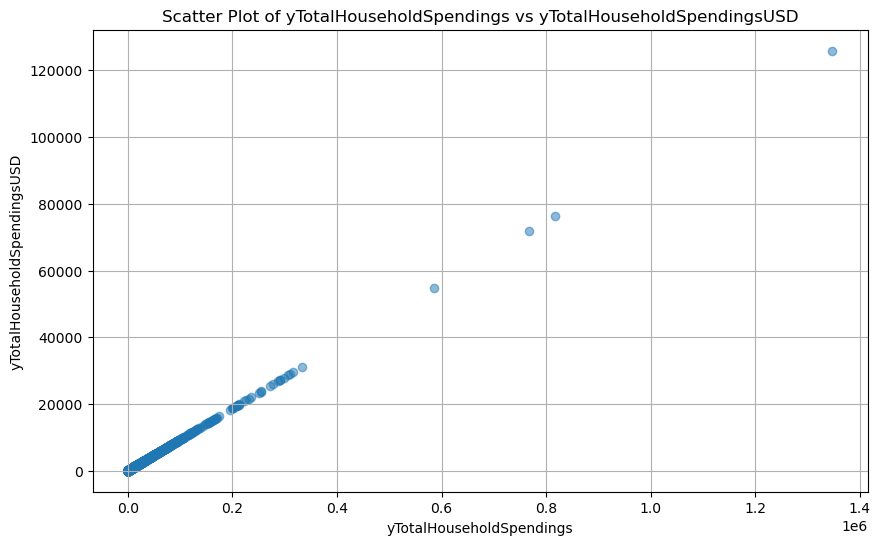

In [126]:
plt.figure(figsize=(10, 6))
plt.scatter(df['yTotalHouseholdSpendings'], df['yTotalHouseholdSpendingsUSD'], alpha=0.5)
plt.xlabel('yTotalHouseholdSpendings')
plt.ylabel('yTotalHouseholdSpendingsUSD')
plt.title('Scatter Plot of yTotalHouseholdSpendings vs yTotalHouseholdSpendingsUSD')
plt.grid(True)
plt.show()


In [128]:
Q1 = df['yTotalHouseholdSpendings'].quantile(0.25) 
Q3 = df['yTotalHouseholdSpendings'].quantile(0.75)
IQR = Q3 - Q1

# Définition des limites pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Échantillon des valeurs aberrantes
outliers = df[(df['yTotalHouseholdSpendings'] < lower_bound) | (df['yTotalHouseholdSpendings'] > upper_bound)]
outliers_sorted = outliers.sort_values(by='Age', ascending=True)

print("Nombre de valeurs aberrantes:", outliers_sorted.shape[0])
print("Valeurs aberrantes:")
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)
print(outliers_sorted)

Nombre de valeurs aberrantes: 305
Valeurs aberrantes:
lower_bound: -21196.800000000003
upper_bound: 53760.0
          ID  GDP_variation  Weight   Age  HouseholdSize  isMale  isMarried   
219   951919       0.093446     160  21.0              3       1          0  \
822    57541       0.093446     117  21.0              5       0          0   
2133  758717       0.093446     276  22.0              2       1          1   
1150  611030       0.093446     398  22.0              3       1          1   
1698  787240       0.093446     172  22.0              3       1          1   
...      ...            ...     ...   ...            ...     ...        ...   
3220  184099       0.093446     239  82.0              9       1          1   
2730  115884       0.093446     452  85.0              5       0          0   
1883   73259       0.093446     160  85.0              5       0          0   
2802  219768       0.093446     203  86.0              5       1          0   
3468  742070       0.09

In [133]:
df['yTotalHouseholdSpendings'].sort_values(ascending=True).tail(15)

3869     254918.400
510      271104.000
3874     278400.000
1078     288115.200
2562     290876.800
2133     291555.825
74       298032.000
3793     305779.200
37       310380.800
3411     315661.600
3785     332812.800
3468     585600.000
1781     768000.000
2723     816576.000
1381    1347196.800
Name: yTotalHouseholdSpendings, dtype: float64

In [139]:
df = df[~((df['yTotalHouseholdSpendings'] <= 0) | (df['yTotalHouseholdSpendings'] > 500001))]

In [140]:
df.shape

(3895, 19)

/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


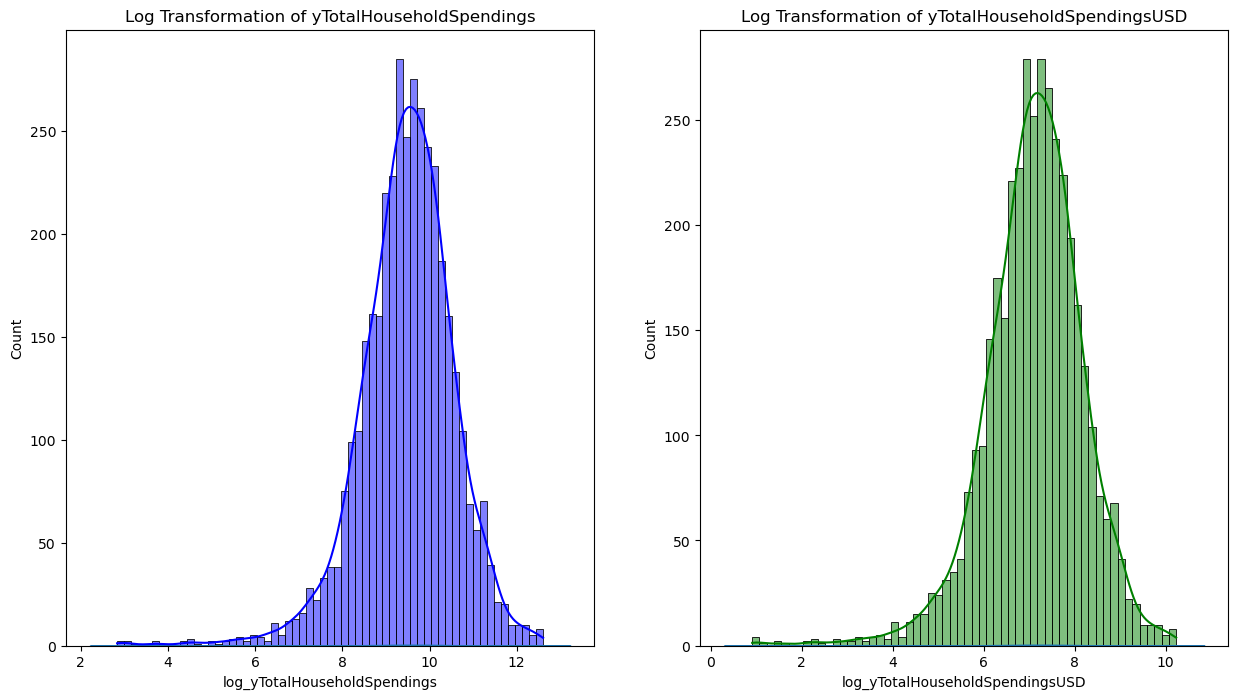

In [141]:
# Application de la transformation logarithmique aux variables
df['log_yTotalHouseholdSpendings'] = log_transformer.transform(df[['yTotalHouseholdSpendings']])
df['log_yTotalHouseholdSpendingsUSD'] = log_transformer.transform(df[['yTotalHouseholdSpendingsUSD']])

# Construction de graphiques pour comparer des distributions logarithmiques (pour réduire la variabilité et normaliser la distribution).
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# 'yTotalHouseholdSpendings'
sns.histplot(data=df, x='log_yTotalHouseholdSpendings', ax=ax[0], kde=True, color='blue')
sns.kdeplot(data=df, x='log_yTotalHouseholdSpendings', ax=ax[0], fill=True, alpha=.5)
ax[0].set_title('Log Transformation of yTotalHouseholdSpendings')

# 'yTotalHouseholdSpendingsUSD'
sns.histplot(data=df, x='log_yTotalHouseholdSpendingsUSD', ax=ax[1], kde=True, color='green')
sns.kdeplot(data=df, x='log_yTotalHouseholdSpendingsUSD', ax=ax[1], fill=True, alpha=.5)
ax[1].set_title('Log Transformation of yTotalHouseholdSpendingsUSD')

plt.show()


In [129]:
df.describe()

ID  GDP_variation       Weight          Age  HouseholdSize   
count    3975.000000   3.975000e+03  3975.000000  3975.000000    3975.000000  \
mean   500136.237484   9.344590e-02   210.480755    45.534088       5.468176   
std    288789.317981   2.775907e-17   122.258315    15.757242       2.733128   
min       106.000000   9.344590e-02    39.000000    15.000000       1.000000   
25%    253150.000000   9.344590e-02   137.000000    33.000000       4.000000   
50%    490652.000000   9.344590e-02   175.000000    43.000000       5.000000   
75%    755798.000000   9.344590e-02   233.000000    56.000000       7.000000   
max    999938.000000   9.344590e-02   991.000000    97.000000      18.000000   

            isMale    isMarried   isLiterate  nYearsEducation      isUrban   
count  3975.000000  3975.000000  3975.000000      3975.000000  3975.000000  \
mean      0.736101     0.713208     0.687547         4.096939     0.542642   
std       0.440801     0.452321     0.463552         4.228176     0.498241   
min       0.000000     0.000000     0.000000         0.000000     0.000000   
25%       0.000000     0.000000     0.000000         0.000000     0.000000   
50%       1.000000     1.000000     1.000000         3.000000     1.000000   
75%       1.000000     1.000000     1.000000         6.000000     1.000000   
max       1.000000     1.000000     1.000000        17.000000     1.000000   

       LaborStatus   hasAccount      hasLoan  isHouseOwner   
count  3975.000000  3975.000000  3975.000000   3975.000000  \
mean      0.252075     0.047799     0.155472      0.782893   
std       0.531215     0.213367     0.362399      0.412328   
min       0.000000     0.000000     0.000000      0.000000   
25%       0.000000     0.000000     0.000000      1.000000   
50%       0.000000     0.000000     0.000000      1.000000   
75%       0.000000     0.000000     0.000000      1.000000   
max       2.000000     1.000000     1.000000      1.000000   

       yTotalHouseholdSpendings  yTotalHouseholdSpendingsUSD   
count              3.975000e+03                  3975.000000  \
mean               2.264502e+04                  2116.084424   
std                4.084120e+04                  3816.442347   
min                0.000000e+00                     0.000000   
25%                6.912000e+03                   645.898047   
50%                1.355520e+04                  1266.677832   
75%                2.565120e+04                  2396.999414   
max                1.347197e+06                125890.012500   

       log_yTotalHouseholdSpendings  log_yTotalHouseholdSpendingsUSD  
count                   3975.000000                      3975.000000  
mean                       9.315774                         6.990511  
std                        1.667936                         1.438311  
min                        0.000000                         0.000000  
25%                        8.841159                         6.472189  
50%                        9.514599                         7.144942  
75%                       10.152385                         7.782390  
max                       14.113537                        11.743172

In [142]:
df_compl=df.copy()

In [172]:
df=df.drop(['Outlier','GDP_variation','log_yTotalHouseholdSpendings','log_yTotalHouseholdSpendingsUSD','yTotalHouseholdSpendingsUSD'], axis=1)

In [173]:
df

ID  Weight   Age  HouseholdSize  isMale  isMarried  isLiterate   
0     408112     187  34.0              4       1          1           1  \
1      99522      95  39.0              8       1          1           1   
2     450411     225  53.0             10       1          1           1   
3     230464     148  54.0              1       1          0           1   
4     187256     221  69.0              5       1          1           1   
...      ...     ...   ...            ...     ...        ...         ...   
4018  640576     128  64.0              3       1          1           0   
4019  288611     197  79.0              3       0          0           0   
4020  354302     161  36.0              3       1          0           1   
4022  168832     150  27.0              5       1          1           1   
4023  315705     307  30.0              4       1          1           1   

      nYearsEducation  isUrban  LaborStatus  hasAccount  hasLoan   
0            4.000000        1            0           0        1  \
1            0.000000        1            0           0        0   
2            4.000000        1            0           0        0   
3            5.000000        1            1           0        0   
4            0.000000        0            0           0        1   
...               ...      ...          ...         ...      ...   
4018         0.000000        0            0           0        0   
4019         0.000000        0            1           0        0   
4020         6.000000        0            0           0        0   
4022         4.000000        0            0           0        0   
4023         2.333333        0            0           0        1   

      isHouseOwner  yTotalHouseholdSpendings  
0                1                     518.4  
1                1                   12000.0  
2                1                   80160.0  
3                1                   13584.0  
4                1                    3200.0  
...            ...                       ...  
4018             0                    8899.2  
4019             1                    5932.8  
4020             1                    3494.4  
4022             1                    4288.0  
4023             1                   14400.0  

[3895 rows x 14 columns]

In [174]:
df.skew()

ID                          0.041194
Weight                      1.888411
Age                         0.575694
HouseholdSize               0.897919
isMale                     -1.082148
isMarried                  -0.958627
isLiterate                 -0.813466
nYearsEducation             0.985929
isUrban                    -0.163377
LaborStatus                 2.116251
hasAccount                  4.230022
hasLoan                     1.885081
isHouseOwner               -1.372202
yTotalHouseholdSpendings    4.303940
dtype: float64

# Analyses bivariée <a id='data-biv'></a>

### Analyse des liaisons entre les variables

In [175]:
df_corr=df.corr()
df_corr

ID    Weight       Age  HouseholdSize   
ID                        1.000000 -0.009737  0.004005      -0.016907  \
Weight                   -0.009737  1.000000  0.008684      -0.064221   
Age                       0.004005  0.008684  1.000000       0.080912   
HouseholdSize            -0.016907 -0.064221  0.080912       1.000000   
isMale                   -0.030843 -0.071372 -0.177733       0.057290   
isMarried                -0.015593 -0.058014 -0.271712       0.179178   
isLiterate                0.001016  0.116364 -0.256549      -0.122405   
nYearsEducation           0.008403  0.166735 -0.273949      -0.181634   
isUrban                   0.008815  0.152280  0.027605      -0.113033   
LaborStatus              -0.009790  0.072200  0.274678      -0.050277   
hasAccount               -0.011292  0.088543 -0.026682      -0.055861   
hasLoan                  -0.015051  0.077389 -0.043308      -0.019093   
isHouseOwner             -0.027362  0.038348  0.204245       0.143827   
yTotalHouseholdSpendings -0.006126  0.118203  0.040612       0.106526   

                            isMale  isMarried  isLiterate  nYearsEducation   
ID                       -0.030843  -0.015593    0.001016         0.008403  \
Weight                   -0.071372  -0.058014    0.116364         0.166735   
Age                      -0.177733  -0.271712   -0.256549        -0.273949   
HouseholdSize             0.057290   0.179178   -0.122405        -0.181634   
isMale                    1.000000   0.716044    0.056430         0.047408   
isMarried                 0.716044   1.000000    0.083935         0.078215   
isLiterate                0.056430   0.083935    1.000000         0.629933   
nYearsEducation           0.047408   0.078215    0.629933         1.000000   
isUrban                  -0.192059  -0.121102    0.274068         0.381212   
LaborStatus              -0.265083  -0.217374   -0.038827        -0.051554   
hasAccount               -0.002680   0.013581    0.138153         0.267884   
hasLoan                  -0.021777   0.002784    0.145839         0.155894   
isHouseOwner             -0.076115  -0.052782   -0.008983        -0.040352   
yTotalHouseholdSpendings  0.045068   0.077604    0.165348         0.328660   

                           isUrban  LaborStatus  hasAccount   hasLoan   
ID                        0.008815    -0.009790   -0.011292 -0.015051  \
Weight                    0.152280     0.072200    0.088543  0.077389   
Age                       0.027605     0.274678   -0.026682 -0.043308   
HouseholdSize            -0.113033    -0.050277   -0.055861 -0.019093   
isMale                   -0.192059    -0.265083   -0.002680 -0.021777   
isMarried                -0.121102    -0.217374    0.013581  0.002784   
isLiterate                0.274068    -0.038827    0.138153  0.145839   
nYearsEducation           0.381212    -0.051554    0.267884  0.155894   
isUrban                   1.000000     0.094992    0.153964  0.120467   
LaborStatus               0.094992     1.000000    0.009562 -0.047979   
hasAccount                0.153964     0.009562    1.000000  0.163735   
hasLoan                   0.120467    -0.047979    0.163735  1.000000   
isHouseOwner              0.061754     0.056923    0.010533  0.010141   
yTotalHouseholdSpendings  0.205034    -0.084539    0.241809  0.114687   

                          isHouseOwner  yTotalHouseholdSpendings  
ID                           -0.027362                 -0.006126  
Weight                        0.038348                  0.118203  
Age                           0.204245                  0.040612  
HouseholdSize                 0.143827                  0.106526  
isMale                       -0.076115                  0.045068  
isMarried                    -0.052782                  0.077604  
isLiterate                   -0.008983                  0.165348  
nYearsEducation              -0.040352                  0.328660  
isUrban                       0.061754                  0.205034  

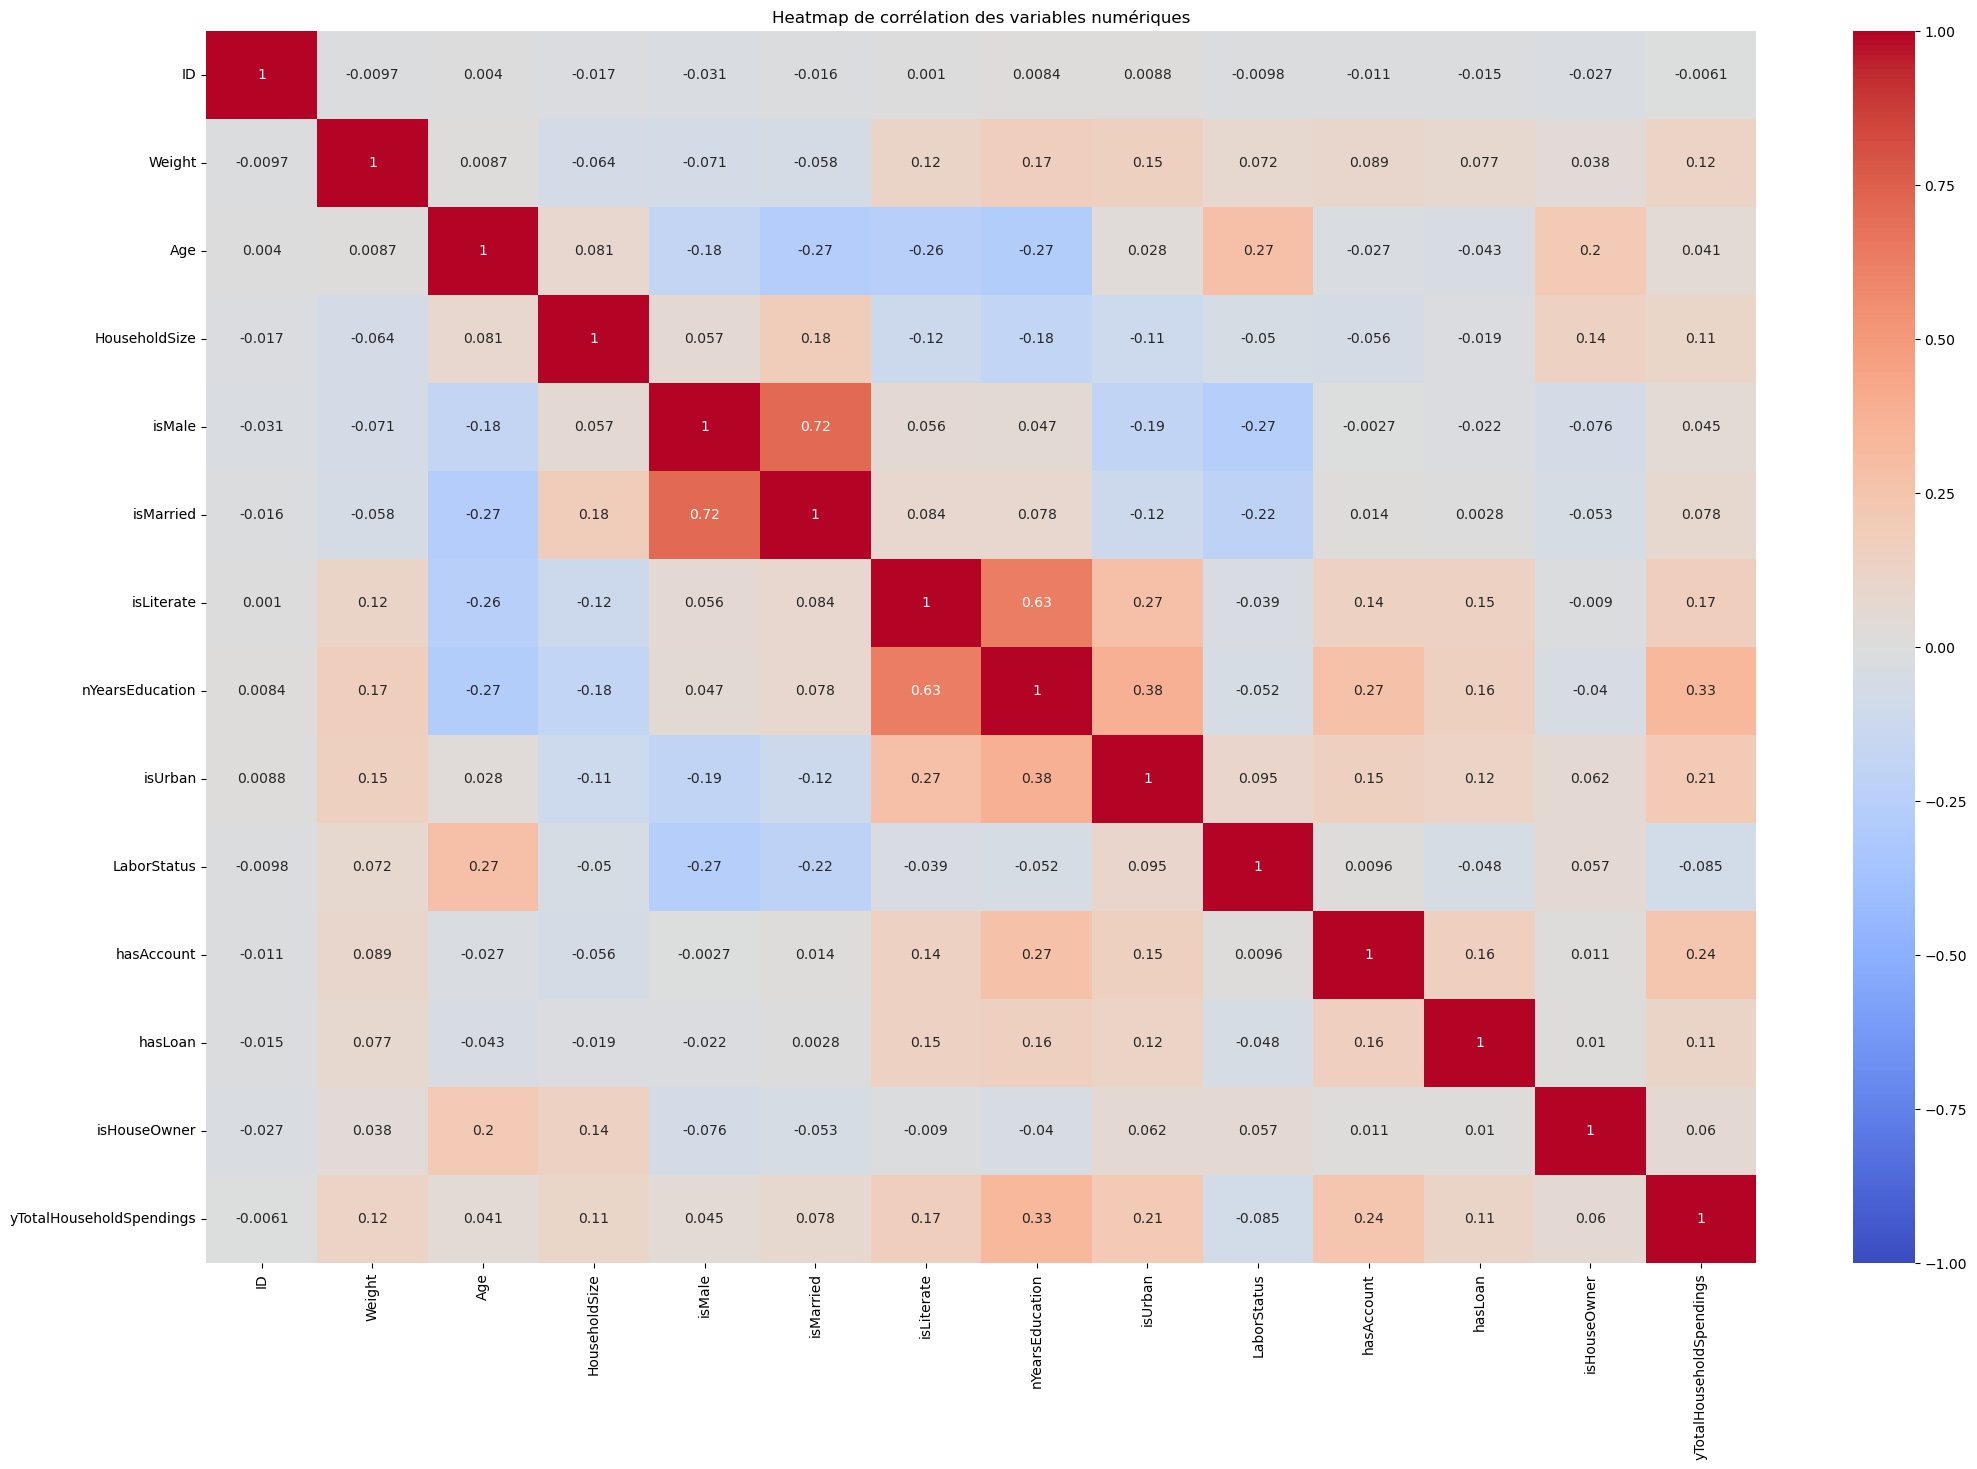

In [176]:
plt.figure(figsize=(25,16))
sns.heatmap(df_corr, vmin=-1,vmax=1, cmap='coolwarm', annot=True)
plt.title('Heatmap de corrélation des variables numériques')
plt.show()

In [177]:
#Déterminer le seuil de corrélation
threshold = 0.7

# Paires de variables fortement corrélées
strong_correlations = (df_corr[(np.abs(df_corr) > threshold) & (np.abs(df_corr) < 1)])
strong_correlation_pairs = np.where(np.abs(df_corr) > threshold)

for i, j in zip(strong_correlation_pairs[0], strong_correlation_pairs[1]):
    if i != j:
        print(f"Variables {df_corr.columns[i]} та {df_corr.columns[j]} avoir une corrélation {strong_correlations.iloc[i, j]}")

Variables isMale та isMarried avoir une corrélation 0.7160442184080089
Variables isMarried та isMale avoir une corrélation 0.7160442184080089


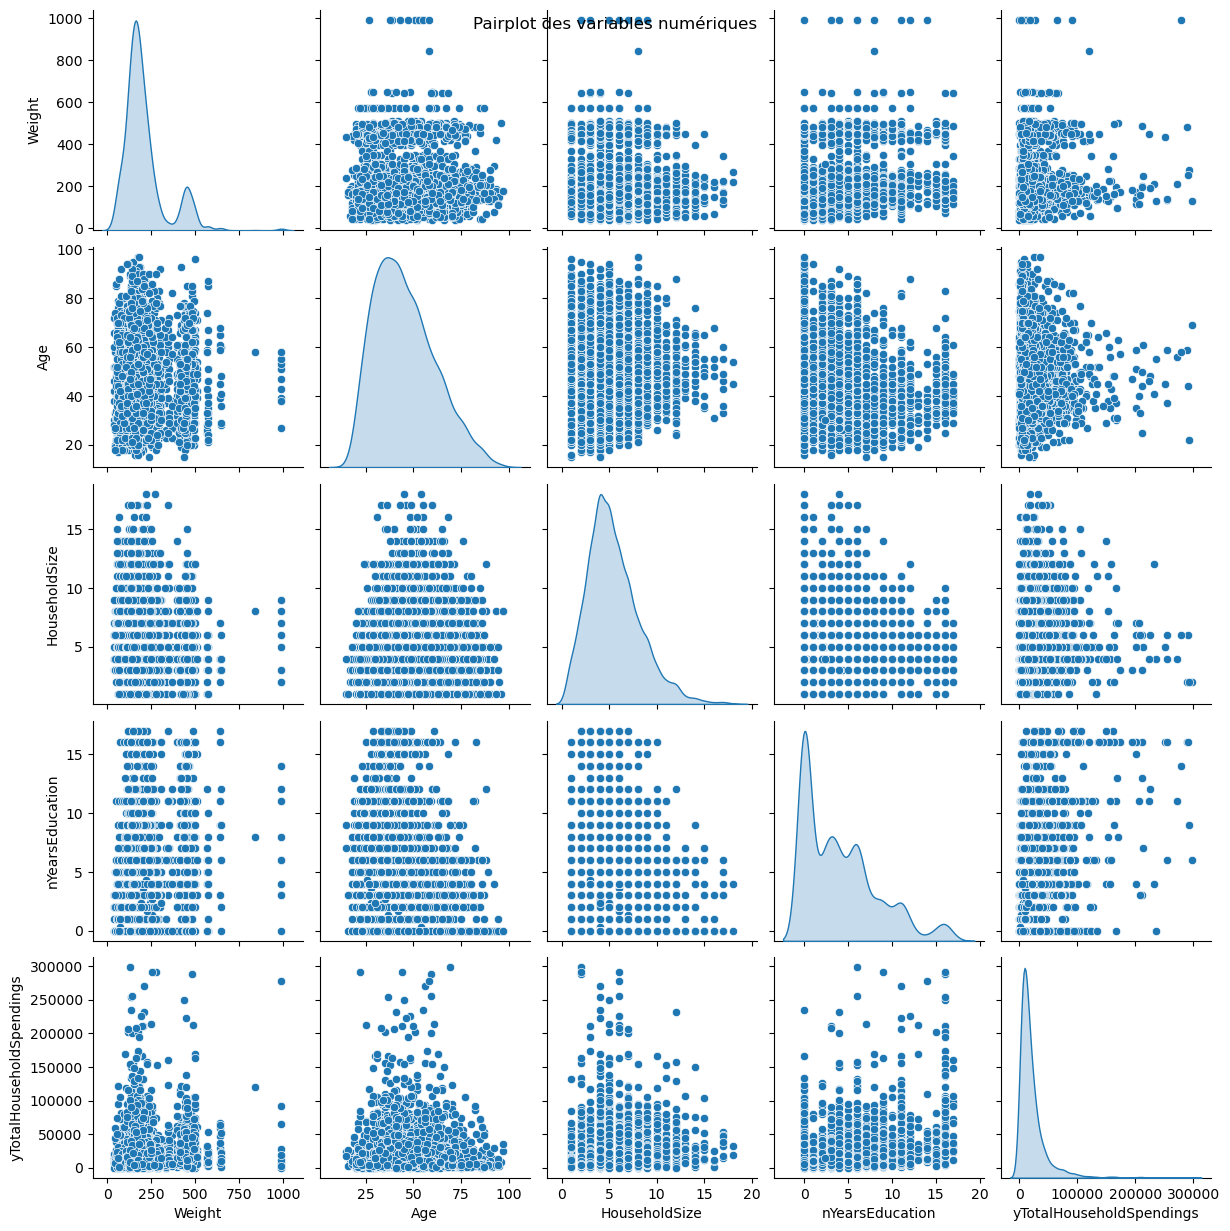

In [179]:
# Génération du pairplot
df_numériques=df[['Weight','Age','HouseholdSize','nYearsEducation','yTotalHouseholdSpendings']]
sns.pairplot(data=df_numériques,  diag_kind='kde')
plt.suptitle('Pairplot des variables numériques')
plt.show()

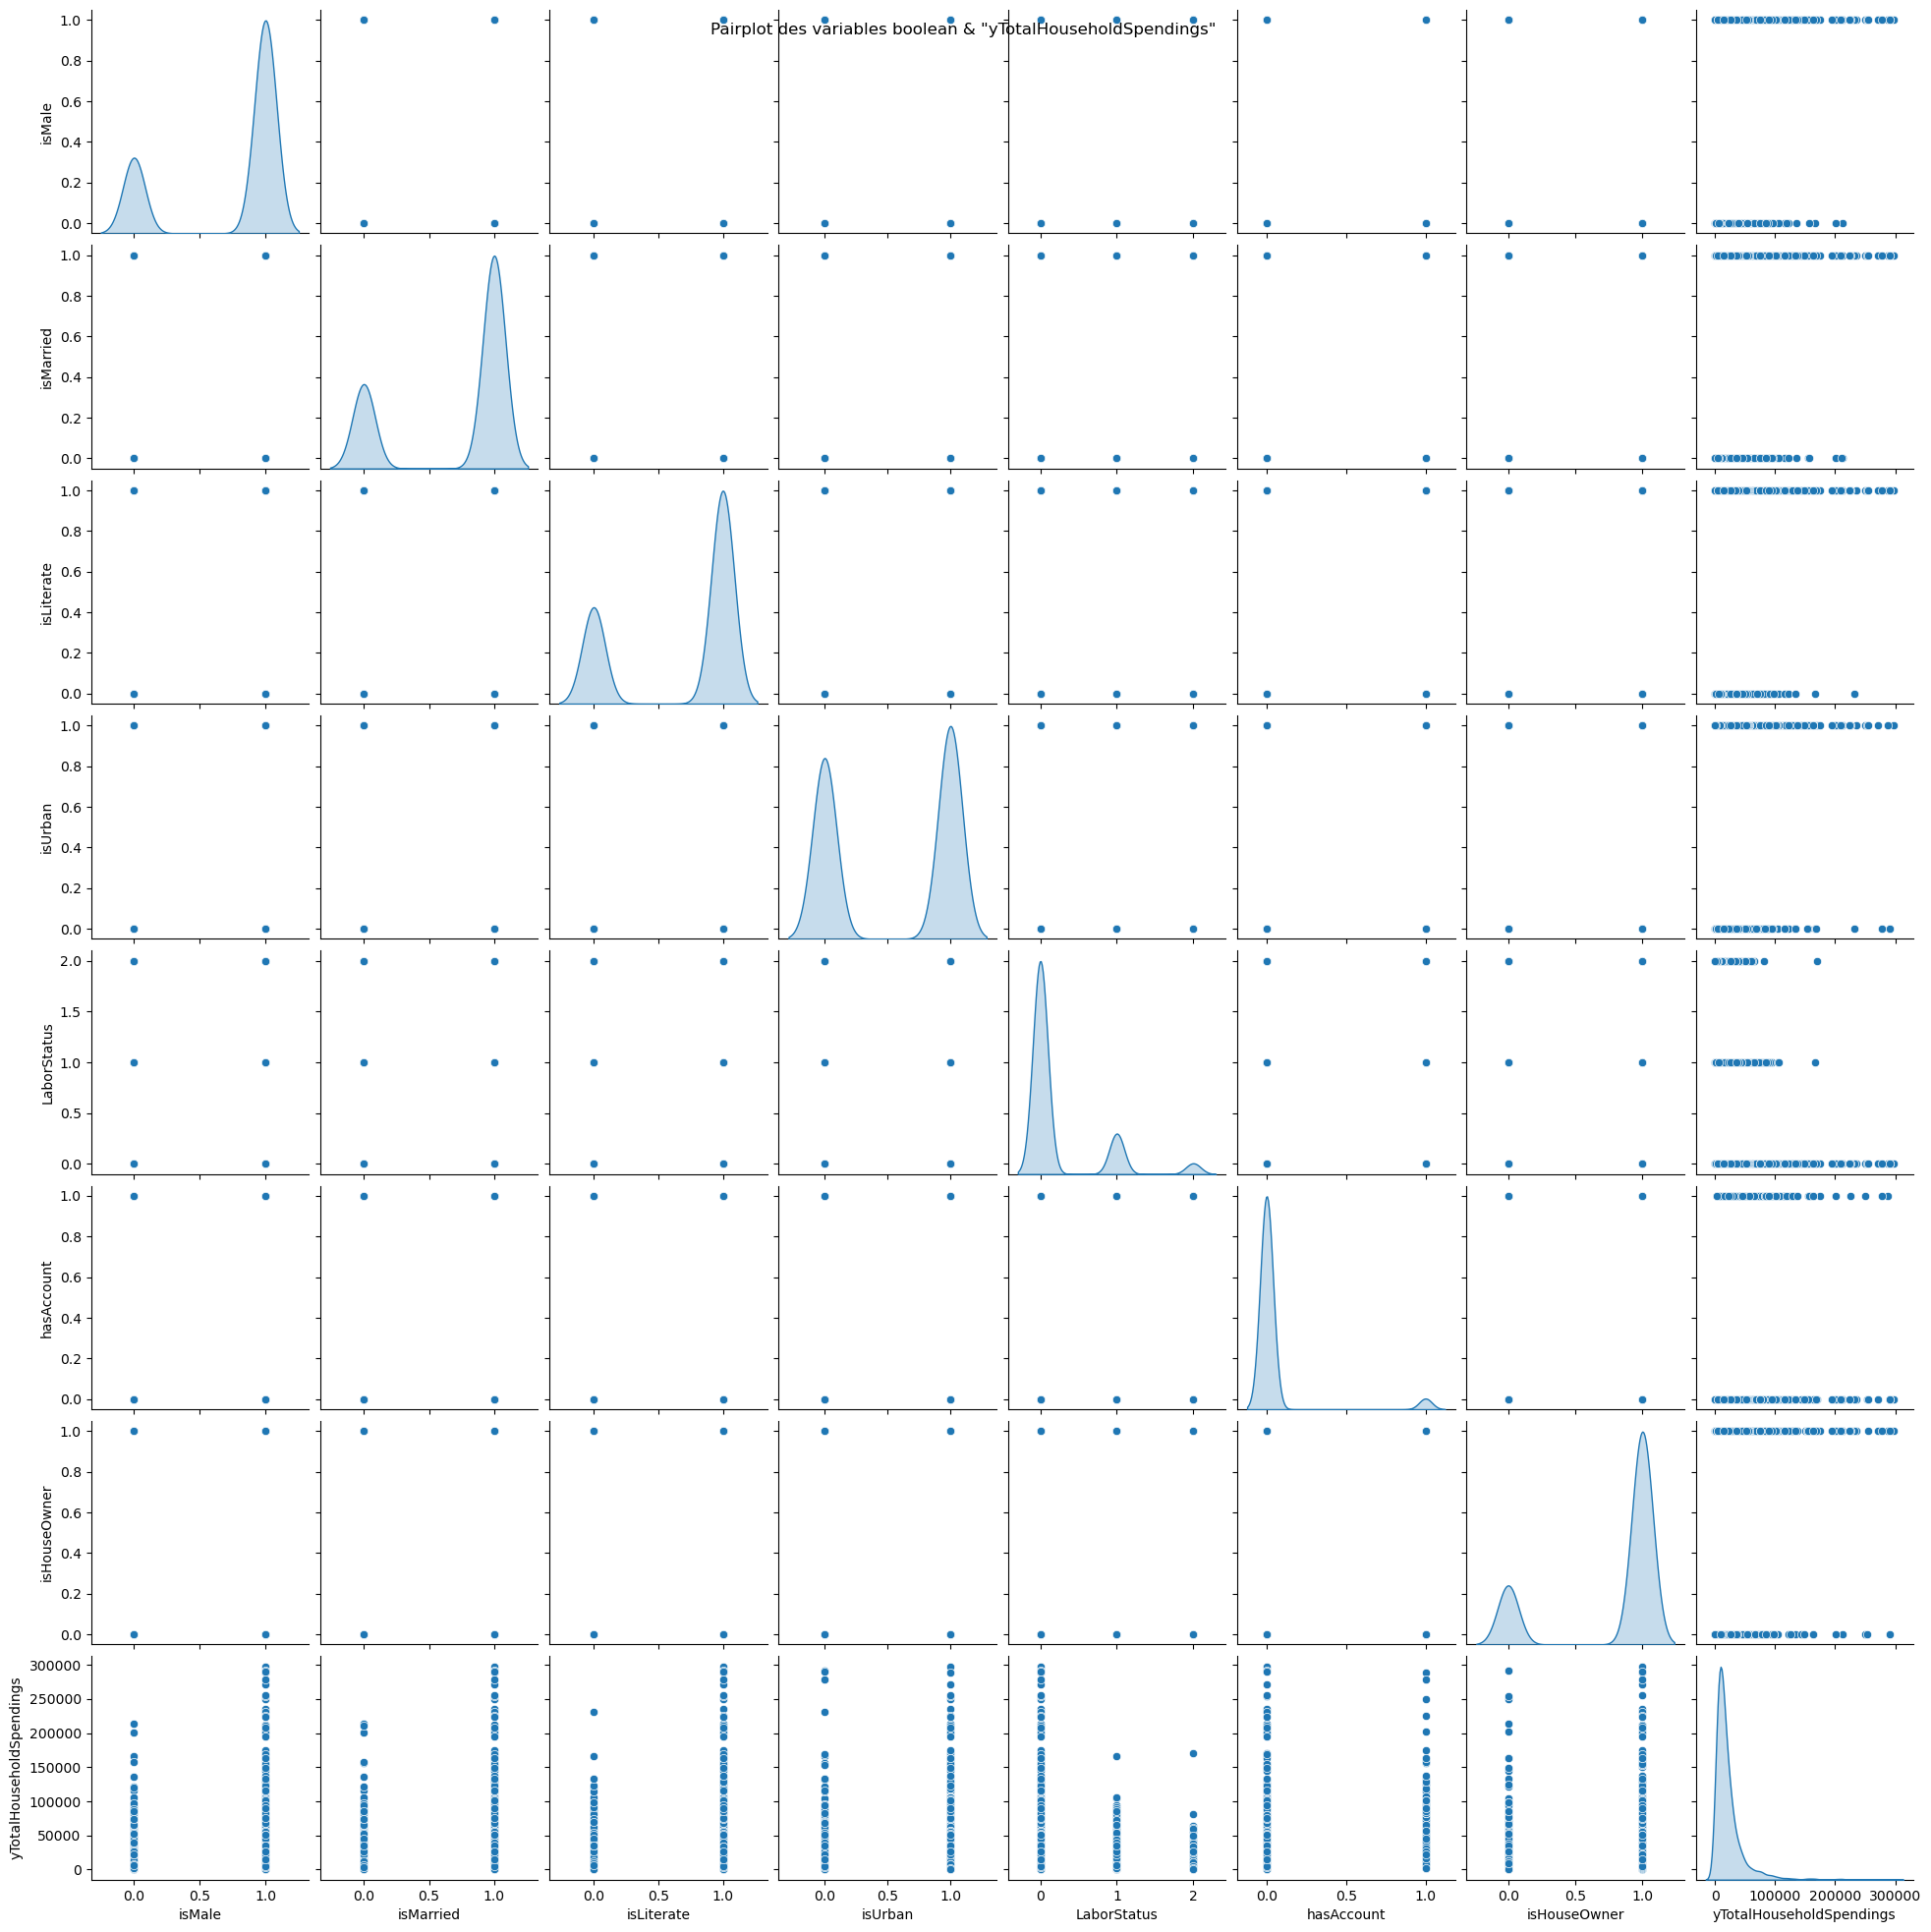

In [180]:
df_bool=df[['isMale','isMarried','isLiterate','isUrban','LaborStatus','hasAccount','isHouseOwner','yTotalHouseholdSpendings']]
sns.pairplot(data=df_bool, diag_kind='kde')
plt.suptitle('Pairplot des variables boolean & "yTotalHouseholdSpendings" ')
plt.show()

<a id='data-cr'></a>

In [181]:
# Variables isMale та isMarried avoir une corrélation 0.7160442184080089, alors créons une nouvelle variable isUnmarriedMale
df['isUnmarriedMale'] = df.apply(lambda x: 1 if x['isMale'] == 1 and x['isMarried'] == 0 else 0, axis=1)

df[['isUnmarriedMale','isMale','isMarried']]

isUnmarriedMale  isMale  isMarried
0                   0       1          1
1                   0       1          1
2                   0       1          1
3                   1       1          0
4                   0       1          1
...               ...     ...        ...
4018                0       1          1
4019                0       0          0
4020                1       1          0
4022                0       1          1
4023                0       1          1

[3895 rows x 3 columns]

In [182]:
# Suppression de l'ancienne variable isMale
df = df.drop('isMale', axis=1)

In [183]:
df

ID  Weight   Age  HouseholdSize  isMarried  isLiterate   
0     408112     187  34.0              4          1           1  \
1      99522      95  39.0              8          1           1   
2     450411     225  53.0             10          1           1   
3     230464     148  54.0              1          0           1   
4     187256     221  69.0              5          1           1   
...      ...     ...   ...            ...        ...         ...   
4018  640576     128  64.0              3          1           0   
4019  288611     197  79.0              3          0           0   
4020  354302     161  36.0              3          0           1   
4022  168832     150  27.0              5          1           1   
4023  315705     307  30.0              4          1           1   

      nYearsEducation  isUrban  LaborStatus  hasAccount  hasLoan   
0            4.000000        1            0           0        1  \
1            0.000000        1            0           0        0   
2            4.000000        1            0           0        0   
3            5.000000        1            1           0        0   
4            0.000000        0            0           0        1   
...               ...      ...          ...         ...      ...   
4018         0.000000        0            0           0        0   
4019         0.000000        0            1           0        0   
4020         6.000000        0            0           0        0   
4022         4.000000        0            0           0        0   
4023         2.333333        0            0           0        1   

      isHouseOwner  yTotalHouseholdSpendings  isUnmarriedMale  
0                1                     518.4                0  
1                1                   12000.0                0  
2                1                   80160.0                0  
3                1                   13584.0                1  
4                1                    3200.0                0  
...            ...                       ...              ...  
4018             0                    8899.2                0  
4019             1                    5932.8                0  
4020             1                    3494.4                1  
4022             1                    4288.0                0  
4023             1                   14400.0                0  

[3895 rows x 14 columns]

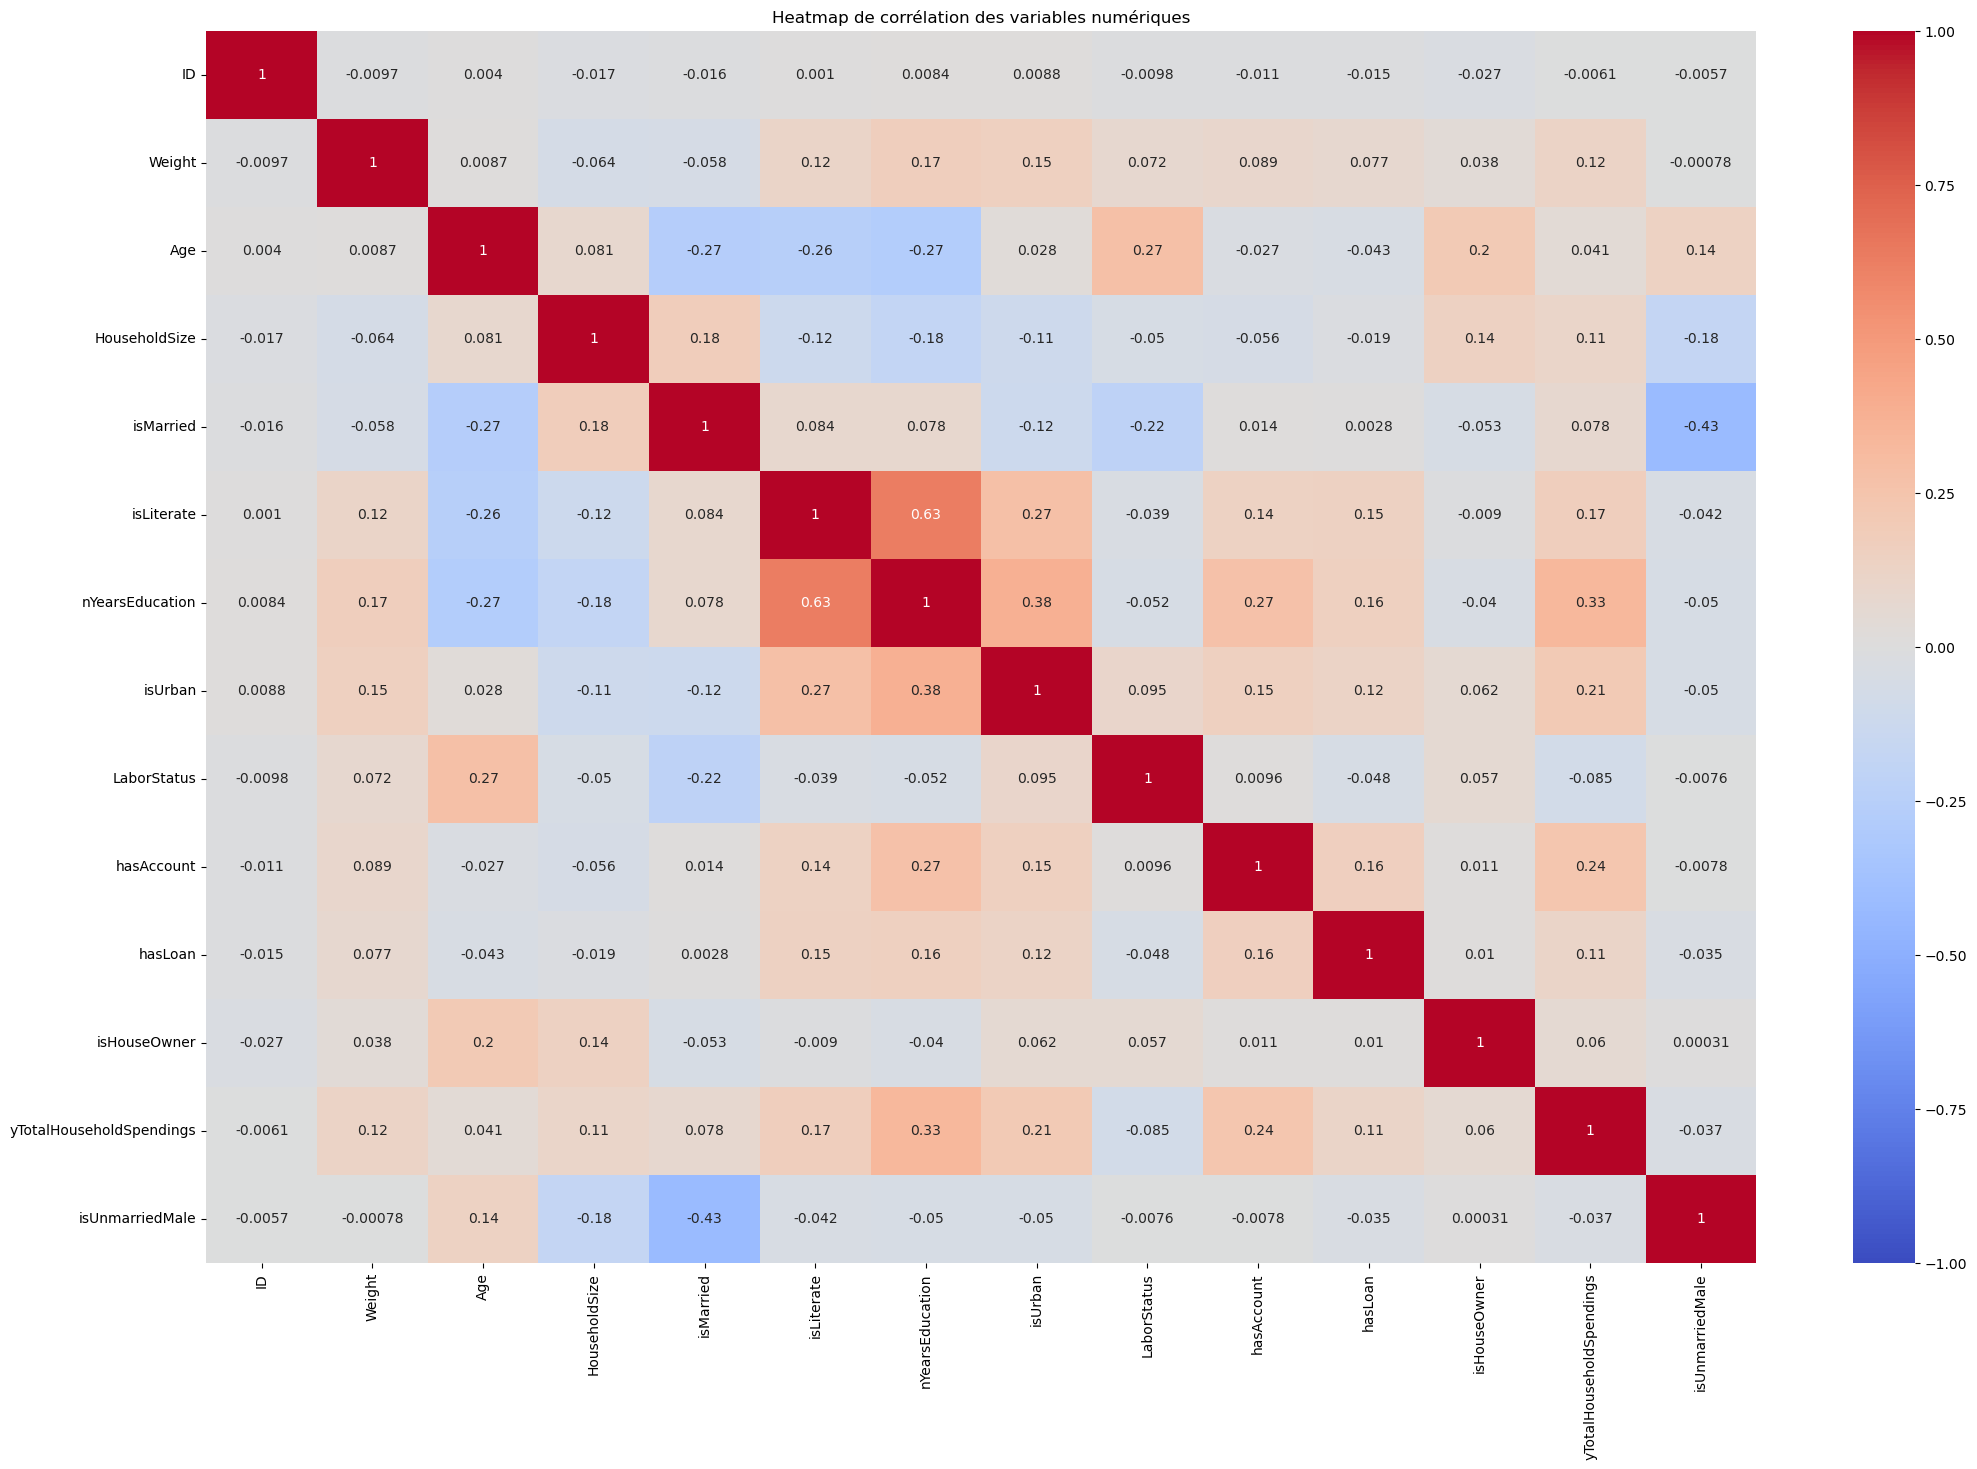

In [163]:
df_corr1=df.corr()
df_corr1
plt.figure(figsize=(25,16))
sns.heatmap(df_corr1, vmin=-1,vmax=1, cmap='coolwarm', annot=True)
plt.title('Heatmap de corrélation des variables numériques')
plt.show()

La corrélation entre les variables indépendantes et la variable cible est très faible, ce qui peut indiquer plusieurs problèmes possibles :

Variables insuffisamment pertinentes : Il est possible que les variables sélectionnées n'aient pas d'effet significatif sur la variable cible et qu'il faille trouver d'autres variables plus étroitement liées aux dépenses des ménages.

Une analyse supplémentaire est nécessaire pour comprendre les relations entre les variables, comme l'analyse en composantes principales (ACP) pour voir si certaines variables peuvent être combinées pour mieux décrire la variable cible.

En général, s’il n’existe pas de forte corrélation, il peut également être utile d’inclure des types d’analyses supplémentaires et éventuellement d’augmenter le volume ou la qualité des données.

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3895 entries, 0 to 4023
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        3895 non-null   int64  
 1   Weight                    3895 non-null   int64  
 2   Age                       3895 non-null   float64
 3   HouseholdSize             3895 non-null   int64  
 4   isMarried                 3895 non-null   int64  
 5   isLiterate                3895 non-null   int64  
 6   nYearsEducation           3895 non-null   float64
 7   isUrban                   3895 non-null   int64  
 8   LaborStatus               3895 non-null   int64  
 9   hasAccount                3895 non-null   int64  
 10  hasLoan                   3895 non-null   int64  
 11  isHouseOwner              3895 non-null   int64  
 12  yTotalHouseholdSpendings  3895 non-null   float64
 13  isUnmarriedMale           3895 non-null   int64  
dtypes: float64(3)

# Préparation des données pour la modélisation. <a id='data-préparation'></a>

In [197]:
# Identification des variables booléennes
boolean_columns = ['isMarried', 'isLiterate', 'hasAccount', 'hasLoan', 'isHouseOwner','isUnmarriedMale','isUrban']
# Sélection de variables numériques pour la normalisation
numeric_columns = ['Weight', 'Age','nYearsEducation', 'HouseholdSize']

df[numeric_columns]

Weight   Age  nYearsEducation  HouseholdSize
0        187  34.0         4.000000              4
1         95  39.0         0.000000              8
2        225  53.0         4.000000             10
3        148  54.0         5.000000              1
4        221  69.0         0.000000              5
...      ...   ...              ...            ...
4018     128  64.0         0.000000              3
4019     197  79.0         0.000000              3
4020     161  36.0         6.000000              3
4022     150  27.0         4.000000              5
4023     307  30.0         2.333333              4

[3895 rows x 4 columns]

In [198]:
df_index = df.index
# Conversion de LaborStatus en  one-hot encoding
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
labor_status_encoded = one_hot_encoder.fit_transform(df[['LaborStatus']])

labor_status_encoded 

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [199]:
# Création d'un DataFrame avec des variables codées et des index correspondants
labor_status_encoded_df = pd.DataFrame(labor_status_encoded, index=df_index, columns=one_hot_encoder.get_feature_names_out(['LaborStatus']))

labor_status_encoded_df

LaborStatus_1  LaborStatus_2
0               0.0            0.0
1               0.0            0.0
2               0.0            0.0
3               1.0            0.0
4               0.0            0.0
...             ...            ...
4018            0.0            0.0
4019            1.0            0.0
4020            0.0            0.0
4022            0.0            0.0
4023            0.0            0.0

[3895 rows x 2 columns]

In [200]:
# Concaténation DataFrame avec des variables codées
df = pd.concat([df, labor_status_encoded_df], axis=1).drop(columns=['LaborStatus'])

# Sélection de variables numériques pour la normalisation
numeric_data = df[numeric_columns]
numeric_data

Weight   Age  nYearsEducation  HouseholdSize
0        187  34.0         4.000000              4
1         95  39.0         0.000000              8
2        225  53.0         4.000000             10
3        148  54.0         5.000000              1
4        221  69.0         0.000000              5
...      ...   ...              ...            ...
4018     128  64.0         0.000000              3
4019     197  79.0         0.000000              3
4020     161  36.0         6.000000              3
4022     150  27.0         4.000000              5
4023     307  30.0         2.333333              4

[3895 rows x 4 columns]

### Standardiser les données <a id='data-stand'></a>

In [203]:
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

In [204]:
numeric_data_scaled

array([[-0.18477163, -0.72931387, -0.02203284, -0.54443831],
       [-0.94563468, -0.41148649, -0.97029687,  0.92030851],
       [ 0.1294979 ,  0.47843016, -0.02203284,  1.65268192],
       ...,
       [-0.39979814, -0.60218292,  0.45209918, -0.91062501],
       [-0.4907709 , -1.17427219, -0.02203284, -0.1782516 ],
       [ 0.80765845, -0.98357577, -0.41714285, -0.54443831]])

In [207]:
# Transformez des données normalisées en DataFrame
numeric_data_scaled_df = pd.DataFrame(numeric_data_scaled, index=df.index, columns=numeric_columns)
numeric_data_scaled_df

Weight       Age  nYearsEducation  HouseholdSize
0    -0.184772 -0.729314        -0.022033      -0.544438
1    -0.945635 -0.411486        -0.970297       0.920309
2     0.129498  0.478430        -0.022033       1.652682
3    -0.507311  0.541996         0.215033      -1.642998
4     0.096417  1.495478        -0.970297      -0.178252
...        ...       ...              ...            ...
4018 -0.672716  1.177650        -0.970297      -0.910625
4019 -0.102069  2.131133        -0.970297      -0.910625
4020 -0.399798 -0.602183         0.452099      -0.910625
4022 -0.490771 -1.174272        -0.022033      -0.178252
4023  0.807658 -0.983576        -0.417143      -0.544438

[3895 rows x 4 columns]

In [208]:
# Suppression des anciennes variables numériques du DataFrame d'origine
df = df.drop(columns=numeric_columns)

In [210]:
# Fusion de variables numériques normalisées avec les données originales
df = pd.concat([df, numeric_data_scaled_df], axis=1)
df

ID  isMarried  isLiterate  isUrban  hasAccount  hasLoan   
0     408112          1           1        1           0        1  \
1      99522          1           1        1           0        0   
2     450411          1           1        1           0        0   
3     230464          0           1        1           0        0   
4     187256          1           1        0           0        1   
...      ...        ...         ...      ...         ...      ...   
4018  640576          1           0        0           0        0   
4019  288611          0           0        0           0        0   
4020  354302          0           1        0           0        0   
4022  168832          1           1        0           0        0   
4023  315705          1           1        0           0        1   

      isHouseOwner  yTotalHouseholdSpendings  isUnmarriedMale  LaborStatus_1   
0                1                     518.4                0            0.0  \
1                1                   12000.0                0            0.0   
2                1                   80160.0                0            0.0   
3                1                   13584.0                1            1.0   
4                1                    3200.0                0            0.0   
...            ...                       ...              ...            ...   
4018             0                    8899.2                0            0.0   
4019             1                    5932.8                0            1.0   
4020             1                    3494.4                1            0.0   
4022             1                    4288.0                0            0.0   
4023             1                   14400.0                0            0.0   

      LaborStatus_2    Weight       Age  nYearsEducation  HouseholdSize  
0               0.0 -0.184772 -0.729314        -0.022033      -0.544438  
1               0.0 -0.945635 -0.411486        -0.970297       0.920309  
2               0.0  0.129498  0.478430        -0.022033       1.652682  
3               0.0 -0.507311  0.541996         0.215033      -1.642998  
4               0.0  0.096417  1.495478        -0.970297      -0.178252  
...             ...       ...       ...              ...            ...  
4018            0.0 -0.672716  1.177650        -0.970297      -0.910625  
4019            0.0 -0.102069  2.131133        -0.970297      -0.910625  
4020            0.0 -0.399798 -0.602183         0.452099      -0.910625  
4022            0.0 -0.490771 -1.174272        -0.022033      -0.178252  
4023            0.0  0.807658 -0.983576        -0.417143      -0.544438  

[3895 rows x 15 columns]

### Définir la variable cible et les prédicteurs. <a id='data-pred'></a>

In [211]:
# On sépare les variables de la cible
X=df.drop(['yTotalHouseholdSpendings','ID'], axis=1)
X

isMarried  isLiterate  isUrban  hasAccount  hasLoan  isHouseOwner   
0             1           1        1           0        1             1  \
1             1           1        1           0        0             1   
2             1           1        1           0        0             1   
3             0           1        1           0        0             1   
4             1           1        0           0        1             1   
...         ...         ...      ...         ...      ...           ...   
4018          1           0        0           0        0             0   
4019          0           0        0           0        0             1   
4020          0           1        0           0        0             1   
4022          1           1        0           0        0             1   
4023          1           1        0           0        1             1   

      isUnmarriedMale  LaborStatus_1  LaborStatus_2    Weight       Age   
0                   0            0.0            0.0 -0.184772 -0.729314  \
1                   0            0.0            0.0 -0.945635 -0.411486   
2                   0            0.0            0.0  0.129498  0.478430   
3                   1            1.0            0.0 -0.507311  0.541996   
4                   0            0.0            0.0  0.096417  1.495478   
...               ...            ...            ...       ...       ...   
4018                0            0.0            0.0 -0.672716  1.177650   
4019                0            1.0            0.0 -0.102069  2.131133   
4020                1            0.0            0.0 -0.399798 -0.602183   
4022                0            0.0            0.0 -0.490771 -1.174272   
4023                0            0.0            0.0  0.807658 -0.983576   

      nYearsEducation  HouseholdSize  
0           -0.022033      -0.544438  
1           -0.970297       0.920309  
2           -0.022033       1.652682  
3            0.215033      -1.642998  
4           -0.970297      -0.178252  
...               ...            ...  
4018        -0.970297      -0.910625  
4019        -0.970297      -0.910625  
4020         0.452099      -0.910625  
4022        -0.022033      -0.178252  
4023        -0.417143      -0.544438  

[3895 rows x 13 columns]

In [266]:
y=df['yTotalHouseholdSpendings']
y

0         518.4
1       12000.0
2       80160.0
3       13584.0
4        3200.0
         ...   
4018     8899.2
4019     5932.8
4020     3494.4
4022     4288.0
4023    14400.0
Name: yTotalHouseholdSpendings, Length: 3895, dtype: float64

### Log transform la variable cible (pour réduire la variabilité et normaliser la distribution). <a id='data-log'></a>

La transformation logarithmique contribuera à rendre la distribution plus symétrique et plus proche de la normale, à lisser la relation non linéaire entre la variable cible et les prédicteurs, ce qui améliore les résultats de la modélisation, à réduire la plage de valeurs de la variable cible, ce qui facilite l’apprentissage du modèle et améliore sa stabilité.

In [263]:
y_log = np.log1p(y)
y_log

0        6.252674
1        9.392745
2       11.291792
3        9.516722
4        8.071219
          ...    
4018     9.093829
4019     8.688420
4020     8.159203
4022     8.363809
4023     9.575053
Name: yTotalHouseholdSpendings, Length: 3895, dtype: float64

###  Division des données en ensemble d'entraînement et ensemble de test <a id='data-test'></a>

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
print(f"La taille de données d'entrainement : {X_train.shape[0]}")
print(f"La taille des données de test : {X_test.shape[0]}")

La taille de données d'entrainement : 3116
La taille des données de test : 779


In [215]:
X_train

isMarried  isLiterate  isUrban  hasAccount  hasLoan  isHouseOwner   
1028          1           1        0           0        0             0  \
2395          0           1        1           0        1             1   
3904          0           1        1           0        0             1   
1915          1           1        1           1        1             0   
1252          1           1        1           1        0             1   
...         ...         ...      ...         ...      ...           ...   
1158          1           1        1           0        0             1   
1326          1           1        1           0        1             0   
879           1           0        1           0        0             1   
3620          1           1        1           0        0             1   
3271          1           1        0           0        1             1   

      isUnmarriedMale  LaborStatus_1  LaborStatus_2    Weight       Age   
1028                0            0.0            0.0 -1.259904 -1.047141  \
2395                0            0.0            0.0  0.327984  0.351299   
3904                0            0.0            0.0 -0.515582 -1.047141   
1915                0            0.0            0.0 -0.366717 -0.920010   
1252                0            1.0            0.0  3.586463  1.241216   
...               ...            ...            ...       ...       ...   
1158                0            0.0            0.0  0.303173 -0.729314   
1326                0            0.0            0.0 -0.689257 -0.220790   
879                 0            0.0            0.0 -0.408068  0.033472   
3620                0            0.0            1.0  0.096417 -0.157225   
3271                0            0.0            0.0 -0.168231 -0.347921   

      nYearsEducation  HouseholdSize  
1028        -0.496165       0.554122  
2395         0.452099       1.286495  
3904         1.637429      -0.910625  
1915         2.822759      -1.276812  
1252         1.637429      -0.544438  
...               ...            ...  
1158         0.452099       0.554122  
1326         1.637429      -0.544438  
879         -0.970297      -0.178252  
3620        -0.733231      -0.544438  
3271        -0.022033       0.187935  

[3116 rows x 13 columns]

In [259]:
y_train

1028      6009.6
2395     34022.4
3904     22656.0
1915    163360.0
1252     59520.0
          ...   
1158     28128.0
1326     46224.0
879       7276.8
3620      5952.0
3271      6240.0
Name: yTotalHouseholdSpendings, Length: 3116, dtype: float64

<a id='data-modélisation'></a>


# Modélisation


**Explication du choix des modèles:**
Flexibilité et capacité à détecter des dépendances complexes : Les modèles sélectionnés incluent des méthodes linéaires simples (Ridge Regression) ainsi que des modèles non linéaires complexes (XGBRegressor, CatBoost, MLPRegressor). Cela permet de prendre en compte la possibilité de dépendances complexes entre les caractéristiques et la variable cible, qui pourraient ne pas être évidentes en utilisant uniquement des modèles linéaires.
Méthodes ensemblistes : L'utilisation de méthodes ensemblistes comme Random Forest, Gradient Boosting, Bagging permet de réduire la variance et d'améliorer la stabilité des modèles.
Traitement du déséquilibre : Les modèles comme XGBRegressor et CatBoost ont des mécanismes intégrés pour traiter le déséquilibre dans les données.
Diversité des approches : L'utilisation de différents types de modèles permet de comparer leur efficacité et de choisir le meilleur modèle pour la tâche spécifique. Cela aide également à identifier les forces et les faiblesses de chaque approche.
En somme, la sélection de ces modèles assure une exploration complète de ce jeu de données et permet de trouver la solution la plus efficace pour la prédiction.

In [297]:
#Création de la fonction score, qui vous permettra de calculer et de sauvegarder les métriques de performance du modèle
#df_scores = pd.DataFrame(columns=['modele', 'R2', 'RMSE', 'MAE', 'MedAE', 'EVS', 'time'])

def score(modele, R2, RMSE, MAE, MedAE, EVS, time):
    df_scores.loc[df_scores.shape[0]] = [modele, R2, RMSE, MAE, MedAE, EVS, time]
    df_scores.sort_values(by='R2', ascending=False, inplace=True)
    df_scores.drop_duplicates(subset=['modele'], keep='last', inplace=True)
    df_scores.reset_index(drop=True, inplace=True)
    return df_scores
scores = []
df_scores = pd.DataFrame(
    scores, columns=['modele', 'R2', 'RMSE', 'MAE','MedAE', 'EVS', 'time'])

In [312]:
def plot_feature_importances(model, X, model_name):
    """
    Visualise l'importance des variables du modèle.

    Paramètres:
    - model : un modèle entraîné qui possède l'attribut feature_importances_
    - X : Ensemble de données avec fonctionnalités (variables indépendantes)
    - model_name : Le nom du modèle qui sera utilisé dans le titre du graphique
    """
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=X.columns)

    # Trier et visualiser l'importance des variables
    feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(8, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()


In [323]:
#XGBRegressor

# Initialisation du modèle
xgb_model = XGBRegressor(scale_pos_weight=3)
xgb_search = RandomizedSearchCV(xgb_model, {
    'n_estimators': [50, 100, 300],
    'max_depth': [2, 4, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}, n_iter=10, cv=5, random_state=42, n_jobs=-1)

xgb_search.fit(X_train, y_train)
best_xgbr_model = xgb_search.best_estimator_

start_time = time.time()
best_xgbr_model.fit(X_train, y_train)
end_time = time.time()
# Prévisions sur les données de test
y_pred = best_xgbr_model.predict(X_test)
# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('XGBRegressor', r2, rmse, mae, medae, evs, end_time - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE       EVS      time
0       CatBoost  0.285379  0.987893  0.722126  0.544756  0.285429  1.000086
1  MLP Regressor  0.271126  0.997696  0.733253  0.569943  0.271324  2.697938
2   XGBRegressor  0.240012  1.018768  0.736615  0.560858  0.242125  0.098013

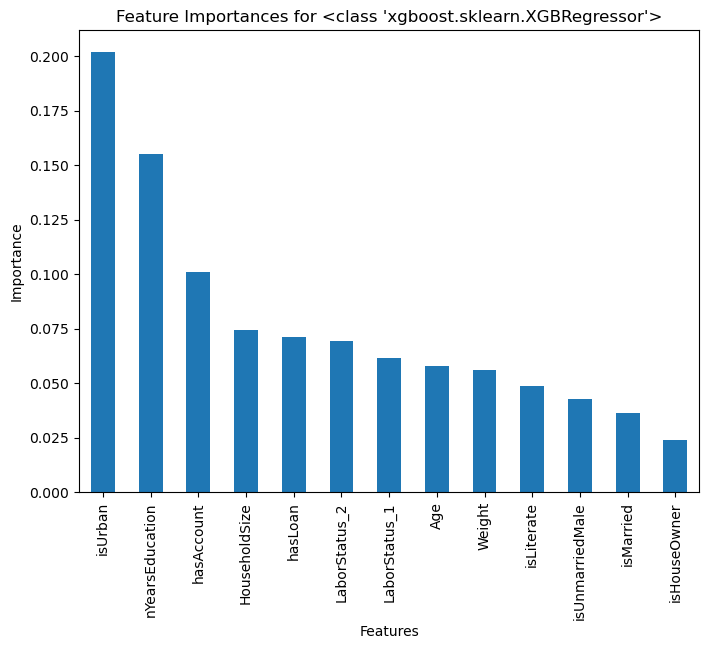

In [324]:
plot_feature_importances(best_xgbr_model, X, XGBRegressor)

In [322]:
# CatBoost

# Initialisation du modèle
cbr_model = CatBoostRegressor(verbose=0)
start_time = time.time()
cbr_model.fit(X_train, y_train)
end_time = time.time()
# Prévisions sur les données de test
y_pred = cbr_model.predict(X_test)
# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('CatBoost', r2, rmse, mae, medae, evs, end_time - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE       EVS      time
0       CatBoost  0.285379  0.987893  0.722126  0.544756  0.285429  1.000086
1  MLP Regressor  0.271126  0.997696  0.733253  0.569943  0.271324  2.697938

<a id='data-varia'></a>

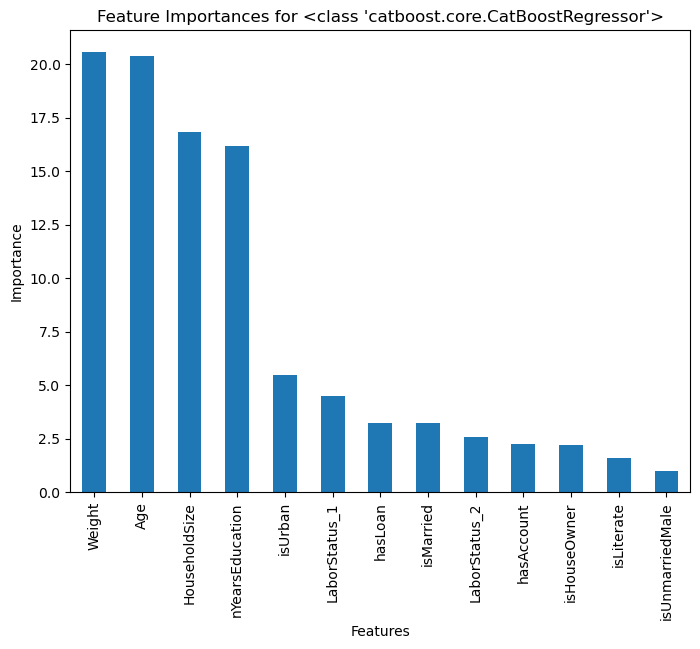

In [325]:
plot_feature_importances(cbr_model, X, CatBoostRegressor)

In [321]:
# MLPRegressor

# Initialisation du modèle
mlp_model = MLPRegressor(max_iter=500, random_state=42)
start_time = time.time()
mlp_model.fit(X_train, y_train)
end_time = time.time()
# Prévisions sur les données de test
y_pred = mlp_model.predict(X_test)
# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('MLP Regressor', r2, rmse, mae, medae, evs, end_time - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE       EVS      time
0  MLP Regressor  0.271126  0.997696  0.733253  0.569943  0.271324  2.697938

In [326]:
# Gradient Boosting Regressor

# Initialisation du modèle
gbr_model = GradientBoostingRegressor()

start_time = time.time()
gbr_model.fit(X_train, y_train)
end_time = time.time()
# Prévisions sur les données de test
y_pred = gbr_model.predict(X_test)
# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('Gradient Boosting Regressor', r2, rmse, mae, medae, evs, end_time - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE   
0                     CatBoost  0.285379  0.987893  0.722126  0.544756  \
1  Gradient Boosting Regressor  0.271830  0.997213  0.720343  0.548913   
2                MLP Regressor  0.271126  0.997696  0.733253  0.569943   
3                 XGBRegressor  0.240012  1.018768  0.736615  0.560858   

        EVS      time  
0  0.285429  1.000086  
1  0.271885  0.214572  
2  0.271324  2.697938  
3  0.242125  0.098013

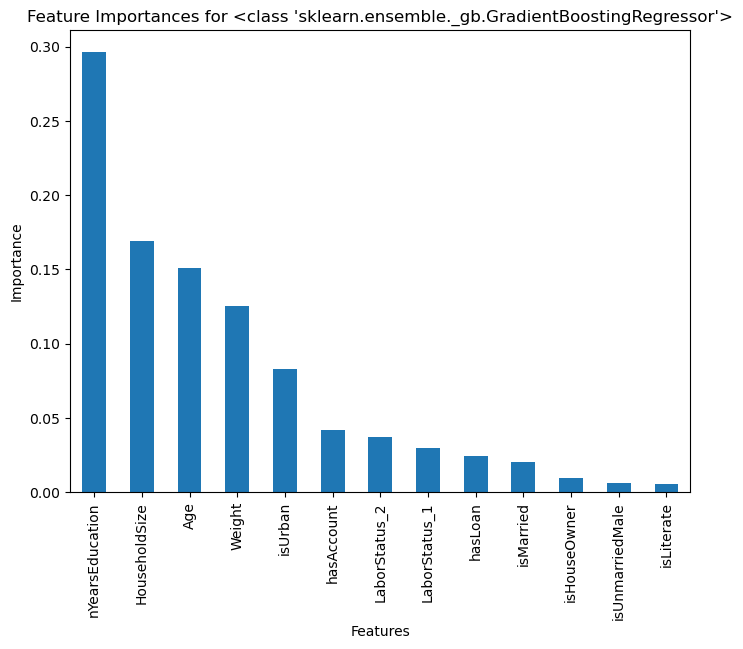

In [327]:
plot_feature_importances(gbr_model, X, GradientBoostingRegressor)

In [328]:
##Bagging Regressor

# Initialisation du modèle
br_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap=True, bootstrap_features=True)

start_time = time.time()
br_model.fit(X_train, y_train)
end_time = time.time()

# Prévisions sur les données de test
y_pred = br_model.predict(X_test)

# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('Bagging Regressor', r2, rmse, mae, medae, evs, end_time - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE   
0                     CatBoost  0.285379  0.987893  0.722126  0.544756  \
1  Gradient Boosting Regressor  0.271830  0.997213  0.720343  0.548913   
2                MLP Regressor  0.271126  0.997696  0.733253  0.569943   
3                 XGBRegressor  0.240012  1.018768  0.736615  0.560858   
4            Bagging Regressor  0.231627  1.024372  0.738280  0.555511   

        EVS      time  
0  0.285429  1.000086  
1  0.271885  0.214572  
2  0.271324  2.697938  
3  0.242125  0.098013  
4  0.231662  0.712123

In [329]:
# XGBoost
# Initialisation du modèle
xgb_model = XGBRegressor(scale_pos_weight=3)
xgb_search = RandomizedSearchCV(xgb_model, {
    'n_estimators': [50, 100, 300],
    'max_depth': [2, 4, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}, n_iter=10, cv=5, random_state=42, n_jobs=-1)

xgb_search.fit(X_train, y_train)
best_xgbr_model = xgb_search.best_estimator_
start_time = time.time()
best_xgbr_model.fit(X_train, y_train)
end_time = time.time()

# Prévisions sur les données de test
y_pred = best_xgbr_model.predict(X_test)

# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('XGBoost', r2, rmse, mae, medae, evs, end_time - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE   
0                     CatBoost  0.285379  0.987893  0.722126  0.544756  \
1  Gradient Boosting Regressor  0.271830  0.997213  0.720343  0.548913   
2                MLP Regressor  0.271126  0.997696  0.733253  0.569943   
3                 XGBRegressor  0.240012  1.018768  0.736615  0.560858   
4                      XGBoost  0.240012  1.018768  0.736615  0.560858   
5            Bagging Regressor  0.231627  1.024372  0.738280  0.555511   

        EVS      time  
0  0.285429  1.000086  
1  0.271885  0.214572  
2  0.271324  2.697938  
3  0.242125  0.098013  
4  0.242125  0.059635  
5  0.231662  0.712123

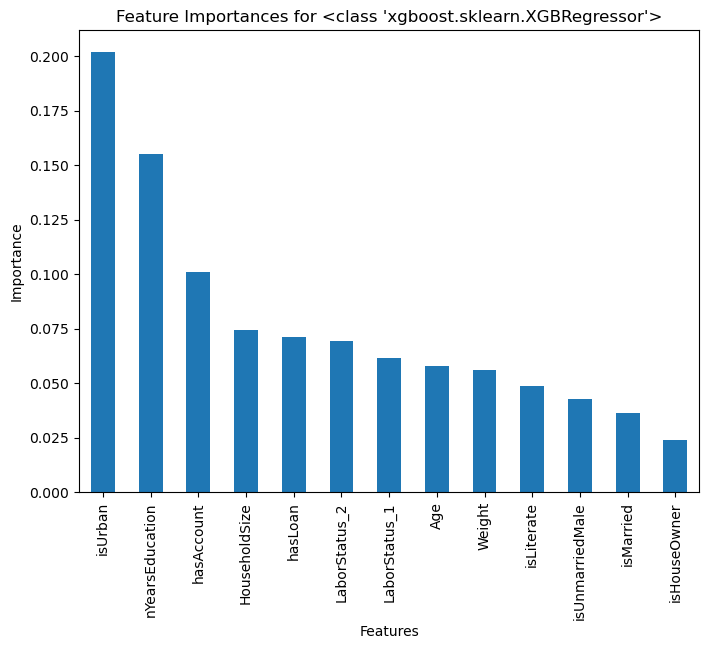

In [330]:
plot_feature_importances(best_xgbr_model, X, XGBRegressor)

In [331]:
# Ridge
# Initialisation du modèle
ridge_model = Ridge()
start_time = time.time()
ridge_model.fit(X_train, y_train)
end_time = time.time()

# Prévisions sur les données de test
y_pred_ridge = ridge_model.predict(X_test)

# Évaluation de la qualité du modèle sur les données de test
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
medae_ridge = median_absolute_error(y_test, y_pred_ridge)
evs_ridge = explained_variance_score(y_test, y_pred_ridge)

df_scores = score('Ridge Regression', r2_ridge, rmse_ridge, mae_ridge, medae_ridge, evs_ridge, time.time() - start_time)
df_scores

modele        R2      RMSE       MAE     MedAE   
0                     CatBoost  0.285379  0.987893  0.722126  0.544756  \
1  Gradient Boosting Regressor  0.271830  0.997213  0.720343  0.548913   
2                MLP Regressor  0.271126  0.997696  0.733253  0.569943   
3             Ridge Regression  0.256952  1.007350  0.729401  0.574798   
4                 XGBRegressor  0.240012  1.018768  0.736615  0.560858   
5                      XGBoost  0.240012  1.018768  0.736615  0.560858   
6            Bagging Regressor  0.231627  1.024372  0.738280  0.555511   

        EVS      time  
0  0.285429  1.000086  
1  0.271885  0.214572  
2  0.271324  2.697938  
3  0.256982  0.009026  
4  0.242125  0.098013  
5  0.242125  0.059635  
6  0.231662  0.712123

In [332]:
# SVR
svr_model = SVR()
start_time = time.time()
svr_model.fit(X_train, y_train)
end_time = time.time()

# Prévisions sur les données de test
y_pred_svr = np.expm1(svr_model.predict(X_test))

# Évaluation de la qualité du modèle sur les données de test
r2_svr = r2_score(y_test_original, y_pred_svr)
rmse_svr = mean_squared_error(y_test_original, y_pred_svr, squared=False)
mae_svr = mean_absolute_error(y_test_original, y_pred_svr)
medae_svr = median_absolute_error(y_test_original, y_pred_svr)
evs_svr = explained_variance_score(y_test_original, y_pred_svr)

df_scores = score('SVR', r2_svr, rmse_svr, mae_svr, medae_svr, evs_svr, time.time() - start_time)
df_scores

modele        R2          RMSE           MAE   
0                     CatBoost  0.285379      0.987893      0.722126  \
1  Gradient Boosting Regressor  0.271830      0.997213      0.720343   
2                MLP Regressor  0.271126      0.997696      0.733253   
3             Ridge Regression  0.256952      1.007350      0.729401   
4                 XGBRegressor  0.240012      1.018768      0.736615   
5                      XGBoost  0.240012      1.018768      0.736615   
6            Bagging Regressor  0.231627      1.024372      0.738280   
7                          SVR  0.153851  29536.978306  14167.309369   

         MedAE       EVS      time  
0     0.544756  0.285429  1.000086  
1     0.548913  0.271885  0.214572  
2     0.569943  0.271324  2.697938  
3     0.574798  0.256982  0.009026  
4     0.560858  0.242125  0.098013  
5     0.560858  0.242125  0.059635  
6     0.555511  0.231662  0.712123  
7  6579.999506  0.200342  0.779240

<a id='data-optim'></a>

In [333]:
# Random Forest Regressor

rf_model = RandomForestRegressor()
rf_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=7, random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params = rf_search.best_params_

# Obtenir le meilleur score de qualité
best_score = rf_search.best_score_

print("Les meilleurs paramètres:", best_params)
print("Le meilleur indicateur de qualité:", best_score)


Les meilleurs paramètres: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8}
Le meilleur indicateur de qualité: 0.22713803363541188


In [334]:
# Entraîner le modèle final avec les meilleurs paramètres

best_rf_model = RandomForestRegressor(max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500)
start_time = time.time()
best_rf_model.fit(X_train, y_train)
end_time = time.time()

# Prévisions sur les données de test
y_pred = best_rf_model.predict(X_test)

# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('Random Forest Regressor', r2, rmse, mae, medae, evs, end_time - start_time)

df_scores


modele        R2          RMSE           MAE   
0                     CatBoost  0.285379      0.987893      0.722126  \
1  Gradient Boosting Regressor  0.271830      0.997213      0.720343   
2                MLP Regressor  0.271126      0.997696      0.733253   
3      Random Forest Regressor  0.260942      1.004641      0.724421   
4             Ridge Regression  0.256952      1.007350      0.729401   
5                 XGBRegressor  0.240012      1.018768      0.736615   
6                      XGBoost  0.240012      1.018768      0.736615   
7            Bagging Regressor  0.231627      1.024372      0.738280   
8                          SVR  0.153851  29536.978306  14167.309369   

         MedAE       EVS      time  
0     0.544756  0.285429  1.000086  
1     0.548913  0.271885  0.214572  
2     0.569943  0.271324  2.697938  
3     0.556210  0.260980  1.877606  
4     0.574798  0.256982  0.009026  
5     0.560858  0.242125  0.098013  
6     0.560858  0.242125  0.059635  
7     0.555511  0.231662  0.712123  
8  6579.999506  0.200342  0.779240

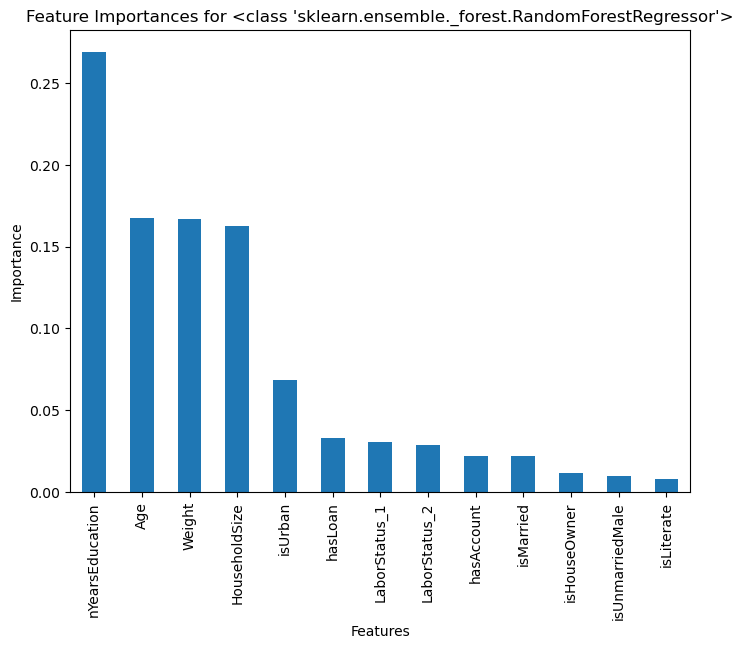

In [335]:
plot_feature_importances(best_rf_model, X, RandomForestRegressor)

In [336]:
#CatBoostRegressor

catboost_model = CatBoostRegressor(verbose=0)
catboost_params = {
    'iterations': [300, 500, 1000],
    'depth': [8, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [5, 8, 10]
}
catboost_search = RandomizedSearchCV(catboost_model, catboost_params, n_iter=15, cv=7, random_state=42, n_jobs=-1)
catboost_search.fit(X_train, y_train)
# Obtenir les meilleurs paramètres
best_params = catboost_search.best_params_

# Obtenir le meilleur score de qualité
best_score = catboost_search.best_score_

print("Les meilleurs paramètres:", best_params)
print("Le meilleur indicateur de qualité:", best_score)


/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Les meilleurs paramètres: {'learning_rate': 0.01, 'l2_leaf_reg': 8, 'iterations': 500, 'depth': 8}
Le meilleur indicateur de qualité: 0.24313843259978526


In [337]:
# Entraîner le modèle final avec les meilleurs paramètres

best_cbr_model = CatBoostRegressor(learning_rate=0.01, l2_leaf_reg=8, iterations=500, depth=8)
start_time = time.time()
best_cbr_model.fit(X_train, y_train)
end_time = time.time()

# Prévisions sur les données de test
y_pred = best_cbr_model.predict(X_test)

# Évaluation de la qualité du modèle sur les données de test
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

df_scores = score('CatBoostRegressor', r2, rmse, mae, medae, evs, end_time - start_time)

df_scores


0:	learn: 1.0607816	total: 12ms	remaining: 5.98s
1:	learn: 1.0589566	total: 22.3ms	remaining: 5.54s
2:	learn: 1.0572397	total: 29.7ms	remaining: 4.92s
3:	learn: 1.0554974	total: 35.9ms	remaining: 4.45s
4:	learn: 1.0539608	total: 37.3ms	remaining: 3.69s
5:	learn: 1.0522447	total: 41.4ms	remaining: 3.41s
6:	learn: 1.0507207	total: 47.1ms	remaining: 3.32s
7:	learn: 1.0489566	total: 52.4ms	remaining: 3.22s
8:	learn: 1.0473630	total: 57.8ms	remaining: 3.15s
9:	learn: 1.0460233	total: 60.6ms	remaining: 2.97s
10:	learn: 1.0443999	total: 65.2ms	remaining: 2.9s
11:	learn: 1.0429079	total: 69.2ms	remaining: 2.81s
12:	learn: 1.0416438	total: 73.4ms	remaining: 2.75s
13:	learn: 1.0403737	total: 77.9ms	remaining: 2.7s
14:	learn: 1.0389365	total: 82.5ms	remaining: 2.67s
15:	learn: 1.0376113	total: 87.1ms	remaining: 2.63s
16:	learn: 1.0361927	total: 95.6ms	remaining: 2.71s
17:	learn: 1.0346322	total: 104ms	remaining: 2.79s
18:	learn: 1.0333776	total: 109ms	remaining: 2.75s
19:	learn: 1.0320072	total: 

191:	learn: 0.9150154	total: 594ms	remaining: 954ms
192:	learn: 0.9146766	total: 597ms	remaining: 949ms
193:	learn: 0.9143927	total: 599ms	remaining: 944ms
194:	learn: 0.9141075	total: 600ms	remaining: 939ms
195:	learn: 0.9137799	total: 602ms	remaining: 934ms
196:	learn: 0.9135273	total: 604ms	remaining: 929ms
197:	learn: 0.9132091	total: 606ms	remaining: 925ms
198:	learn: 0.9130028	total: 607ms	remaining: 918ms
199:	learn: 0.9126616	total: 609ms	remaining: 913ms
200:	learn: 0.9124057	total: 611ms	remaining: 909ms
201:	learn: 0.9121032	total: 614ms	remaining: 905ms
202:	learn: 0.9118361	total: 616ms	remaining: 901ms
203:	learn: 0.9115902	total: 618ms	remaining: 896ms
204:	learn: 0.9112800	total: 620ms	remaining: 892ms
205:	learn: 0.9109254	total: 622ms	remaining: 888ms
206:	learn: 0.9106648	total: 624ms	remaining: 883ms
207:	learn: 0.9103733	total: 626ms	remaining: 879ms
208:	learn: 0.9101771	total: 628ms	remaining: 875ms
209:	learn: 0.9097809	total: 630ms	remaining: 871ms
210:	learn: 

415:	learn: 0.8708747	total: 979ms	remaining: 198ms
416:	learn: 0.8707399	total: 981ms	remaining: 195ms
417:	learn: 0.8705885	total: 984ms	remaining: 193ms
418:	learn: 0.8704728	total: 986ms	remaining: 191ms
419:	learn: 0.8703646	total: 988ms	remaining: 188ms
420:	learn: 0.8701776	total: 990ms	remaining: 186ms
421:	learn: 0.8700216	total: 993ms	remaining: 183ms
422:	learn: 0.8699113	total: 995ms	remaining: 181ms
423:	learn: 0.8697658	total: 998ms	remaining: 179ms
424:	learn: 0.8696863	total: 999ms	remaining: 176ms
425:	learn: 0.8695643	total: 1s	remaining: 174ms
426:	learn: 0.8694075	total: 1s	remaining: 172ms
427:	learn: 0.8692844	total: 1.01s	remaining: 169ms
428:	learn: 0.8691017	total: 1.01s	remaining: 167ms
429:	learn: 0.8689818	total: 1.01s	remaining: 165ms
430:	learn: 0.8688599	total: 1.01s	remaining: 162ms
431:	learn: 0.8687399	total: 1.02s	remaining: 160ms
432:	learn: 0.8686065	total: 1.02s	remaining: 158ms
433:	learn: 0.8685325	total: 1.02s	remaining: 155ms
434:	learn: 0.8684

modele        R2          RMSE           MAE   
0                     CatBoost  0.285379      0.987893      0.722126  \
1  Gradient Boosting Regressor  0.271830      0.997213      0.720343   
2                MLP Regressor  0.271126      0.997696      0.733253   
3            CatBoostRegressor  0.268295      0.999631      0.720088   
4      Random Forest Regressor  0.260942      1.004641      0.724421   
5             Ridge Regression  0.256952      1.007350      0.729401   
6                 XGBRegressor  0.240012      1.018768      0.736615   
7                      XGBoost  0.240012      1.018768      0.736615   
8            Bagging Regressor  0.231627      1.024372      0.738280   
9                          SVR  0.153851  29536.978306  14167.309369   

         MedAE       EVS      time  
0     0.544756  0.285429  1.000086  
1     0.548913  0.271885  0.214572  
2     0.569943  0.271324  2.697938  
3     0.543763  0.268308  1.298397  
4     0.556210  0.260980  1.877606  
5     0.574798  0.256982  0.009026  
6     0.560858  0.242125  0.098013  
7     0.560858  0.242125  0.059635  
8     0.555511  0.231662  0.712123  
9  6579.999506  0.200342  0.779240

#La fonction np.expm1 renvoie la valeur à l'échelle d'origine.
#y_pred_real = np.expm1(y_pred)


En analysant l'importance des variables, nous serons en mesure de comprendre quels facteurs ont la plus grande influence sur les dépenses globales des ménages. Cela contribuera à améliorer le modèle et à le rendre plus interprétable.

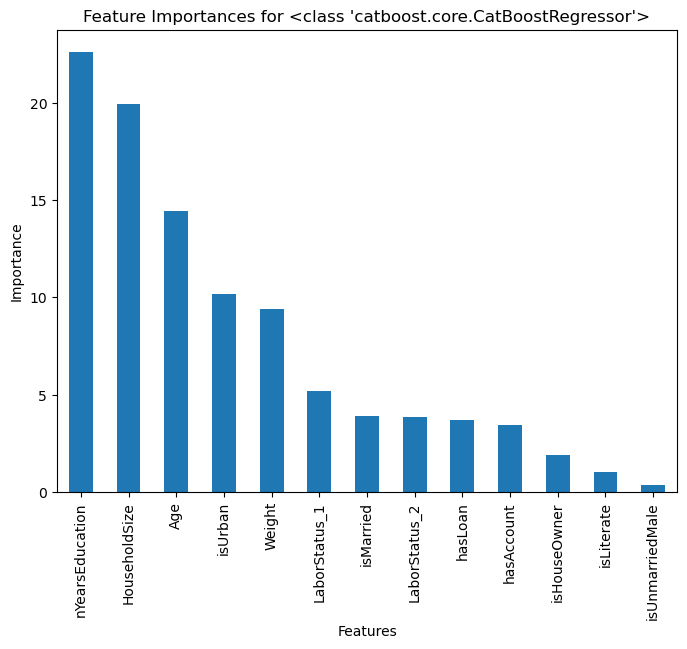

In [338]:
plot_feature_importances(best_cbr_model, X, CatBoostRegressor)

# Conclusions. <a id='data-conclusions'></a>

**Quelques pistes d'améliorations:**  
Les résultats d’apprentissage et de prévision des différents modèles se sont révélés plutôt faibles. Voici quelques pistes d'améliorations possibles pour cette analyse, que je n'aurais pas le temps de mener à bien :

Variables insuffisamment pertinentes : Il est possible que les variables sélectionnées n'aient pas d'effet significatif sur la variable cible. Il serait pertinent d’identifier et d’intégrer d’autres variables plus étroitement liées aux dépenses des ménages.

Analyse supplémentaire des relations entre les variables : Une analyse en composantes principales (ACP) pourrait être nécessaire pour comprendre les relations complexes entre les variables et déterminer si certaines d'entre elles peuvent être combinées pour mieux décrire la variable cible.

Volume et qualité des données : En l'absence de corrélations fortes, il peut être utile d’augmenter le volume de données ou d’améliorer leur qualité, ainsi que d’inclure des types d’analyses supplémentaires pour mieux capter les dépendances sous-jacentes.

Impact de la variation du PIB :

GDP_variation: 0.093446 (9.3446%) indique que le PIB a augmenté de 9,3446% par rapport à la période précédente. Il s'agit d'un indicateur positif de croissance économique, ce qui peut être utile pour prévoir les dépenses des ménages. La croissance économique affecte souvent les dépenses de consommation, un taux de croissance plus élevé du PIB pouvant indiquer une augmentation du revenu des ménages et, par conséquent, des dépenses accrues.
Des variables supplémentaires peuvent être créées sur la base de ces informations, telles que :

(1+GDP_variation) * HouseholdSize : Pour estimer l'impact de la croissance économique sur les dépenses des ménages ajustées en fonction de la taille du ménage.
Interactions entre GDP_variation et d'autres variables pertinentes : Pour révéler des dépendances plus complexes. Ces nouvelles variables peuvent améliorer la précision du modèle car elles prennent en compte l’impact des facteurs macroéconomiques sur les dépenses individuelles.  

En conclusion, l'amélioration de la pertinence des variables, l'analyse des relations entre celles-ci, et l'intégration de facteurs macroéconomiques comme la variation du PIB peuvent potentiellement accroître la précision des modèles de prévision des dépenses des ménages.